In [1]:
import pandas as pd
import json
import os
import argparse
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
import numpy as np

def load_json_file(file_path):
    """Load JSON file and return as Python object"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

def extract_video_name(path):
    """Extract video filename without extension from path"""
    return os.path.splitext(os.path.basename(path))[0]

ModuleNotFoundError: No module named 'nltk'

In [13]:
prediction_path = 'output/batch_video_results.json'
references_path = 'datasets/video_prompts.json'
#output_path = 'output/batch_video_results.csv'


# Load JSON files
predictions_data = load_json_file(prediction_path)
references_data = load_json_file(references_path)

if not predictions_data or not references_data:
    print("Failed to load one or both JSON files. Exiting.")

# Create a dictionary of reference prompts keyed by video name
reference_dict = {}
for item in references_data:
    # Adapt this according to your reference JSON structure
    if isinstance(item, dict) and 'video' in item and 'conversations' in item:
        reference_dict[item['video']] = item['conversations'][1]['value']


# Create a list to store all comparison data
comparison_data = []

# Process each prediction
for pred in predictions_data:
    video_name = pred['video_name']
    prediction = pred.get('prediction', '')
    
    # Find matching reference
    reference = reference_dict.get(video_name, '')
    
    
    # Add to comparison data
    comparison_data.append({
        'video_name': video_name,
        'reference': reference,
        'prediction': prediction,
    })

# Convert to DataFrame
df = pd.DataFrame(comparison_data)





In [19]:
#Save to CSV
df.to_parquet('output/compare_evalutaion_results.parquet', index=False)


In [1]:
import pandas as pd

result_df = pd.read_parquet('output/compare_evalutaion_results.parquet')

In [2]:
result_df.head()

,video_name,reference,prediction
0,cog-0010fb2b-f6cd-51af-a0b6-b38812f965ea.mp4,The beautiful woman ，under the starry sky ，loo...,a woman with long hair and a white dress
1,cog-001777d8-0130-5a50-8792-a6b46e02df6d.mp4,a futuristic city full of robots walking throu...,a robot running on the street
2,cog-001e551e-961d-5645-9d84-604bc820bbb7.mp4,computer screen capture of surveillance applic...,The video is shot from the inside of a building.
3,cog-001ead14-07ea-592e-bf94-b32c29bd3692.mp4,"las palmeras se mueven, el oc&#233;ano se muev...",light up the palm trees at night
4,cog-001fd7f2-1b04-5749-b4cc-0469eae5d144.mp4,"a girl shooting ,in the 1990s moives",a girl with pink flowers in her hair


In [3]:
from datasets import load_metric
from nltk.tokenize import word_tokenize
from bert_score import score
from nltk.translate.meteor_score import meteor_score
import evaluate
import pandas as pd
import numpy as np
import torch

def Calmetic(references:list[list[str]], predictions:list[str]):
    '''
    Input format:

    predictions = [
        "What is the capital of France?",
        "Who wrote the book?",
        "What is the largest planet?"
    ]

    references = [
        ["What is the capital city of France?"],
        ["Who is the author of the book?"],
        ["Which planet is the largest in the solar system?"]
    ]
    '''

    # # 加载 BLEU 评分器
    # bleu_metric = load_metric("bleu")

    # # 计算 BLEU 分数
    predictions_tokenized = [word_tokenize(pred) for pred in predictions]
    references_tokenized = [[word_tokenize(refs[0])] for refs in references]
    # B_S = {}
    # for n in range(1, 5):
    #     bleu_metric.add_batch(predictions=predictions_tokenized, references=references_tokenized)
    #     results = bleu_metric.compute(max_order=n)
    #     B_S[f"BLEU-{n}"] = results
    bleu_metric = evaluate.load("bleu")
    B_S = bleu_metric.compute(predictions=predictions, references=references,tokenizer=word_tokenize)
    for i,n in enumerate(B_S['precisions']):
        print(f"BLEU-{i+1} score: {n:.5f}")
        


    # 加载 ROUGE 评分器
    rouge_metric = load_metric("rouge")
    '''
    ROUGE-1: 衡量生成文本和参考文本之间的 unigram 匹配。
    ROUGE-2: 衡量生成文本和参考文本之间的 bigram 匹配。
    ROUGE-L: 衡量生成文本和参考文本之间的最长公共子序列(LCS)。
    ROUGE-Lsum: 基于 LCS 的一个变体，专门用于长文本的评估。
    '''
    # 计算 ROUGE 分数
    rouge_results = rouge_metric.compute(predictions=predictions, references=references)
    rouge1_mid_f1 = rouge_results['rouge1'][1][2]
    rouge2_mid_f1 = rouge_results['rouge2'][1][2]
    rougeL_mid_f1 = rouge_results['rougeL'][1][2]
    rougeLsum_mid_f1 = rouge_results['rougeLsum'][1][2]
    print(f"ROUGE-1 F1 score: {rouge1_mid_f1:.5f}")
    print(f"ROUGE-2 F1 score: {rouge2_mid_f1:.5f}")
    print(f"ROUGE-L F1 score: {rougeL_mid_f1:.5f}")
    print(f"ROUGE-Lsum F1 score: {rougeLsum_mid_f1:.5f}")

    # 计算 METEOR 分数
    meteor_scores = [meteor_score(references=refs, hypothesis=pred) for pred, refs in zip(predictions_tokenized, references_tokenized)]
    average_meteor_score = sum(meteor_scores) / len(meteor_scores)
    print(f"Average METEOR score: {average_meteor_score:.5f}")

    # 计算 BERTScore 分数
    '''
    同样效果：
    bert_metric = load_metric("bertscore",cache_dir="/media/fenghe/New Volume/A2Q/Metric")
    bert_results = bert_metric.compute(predictions=predictions, references=references,lang="en",device=f"cuda:{torch.cuda.device_count() - 1}")

    设置 verbose=True 会使函数在计算过程中输出更多的信息，例如处理进度、当前正在处理的数据等。
    '''
    P, R, F1 = score(predictions, [ref[0] for ref in references], lang="en", verbose=False)
    average_bert_score = F1.mean().item()
    print(f"Average BERTScore F1: {average_bert_score:.5f}")

    return {
        "BLEU":B_S,
        "ROUGE":rouge_results,
        "METERO":meteor_scores,
        "BERTScore":{"Precision":P,"Recall":R,"F1":F1},
    }

/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [7]:
content

0               a woman with long hair and a white dress
1                          a robot running on the street
2       The video is shot from the inside of a building.
3                       light up the palm trees at night
4                   a girl with pink flowers in her hair
                              ...                       
9995                        a bear walking in the forest
9996                          a horse walking in a field
9997                                a snake in the water
9998                 a tiger and a bull walking together
9999                        cat drinking from a red bowl
Name: prediction, Length: 10000, dtype: object

In [6]:
refs = [ [i] for i in result_df['reference']]
content = result_df['prediction']

In [9]:
import re

def clean_sentence(s):
    s = s.replace("，", ",")  # 替换中文逗号
    s = re.sub(r"-[a-z]+\s*\d+", "", s)  # 去掉如 -fps 24 这种参数
    s = s.strip()
    return s

predictions = [clean_sentence(p) for p in result_df['prediction']]
references = [[clean_sentence(r)] for r in result_df['reference']]


In [12]:
res = Calmetic(references=references,predictions=predictions)

BLEU-1 score: 0.22469
BLEU-2 score: 0.04766
BLEU-3 score: 0.01273
BLEU-4 score: 0.00367
ROUGE-1 F1 score: 0.17683
ROUGE-2 F1 score: 0.04080
ROUGE-L F1 score: 0.16043
ROUGE-Lsum F1 score: 0.16042
Average METEOR score: 0.10999


/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1: 0.85108


In [13]:
# 两个重要数值
print(res['BLEU'])
print(res['ROUGE']['rougeLsum'][1])

{'bleu': 0.005924832258805923, 'precisions': [0.22469292672596358, 0.047655485586693094, 0.012729905242484626, 0.0036738306364076617], 'brevity_penalty': 0.22272266197377252, 'length_ratio': 0.39970774172566037, 'translation_length': 89718, 'reference_length': 224459}
Score(precision=0.24667125058071504, recall=0.15098046973503293, fmeasure=0.1604246130379885)


In [33]:
from transformers import BertTokenizer, BertModel
import torch
from torch.nn.functional import cosine_similarity as torch_cosine_similarity
from sentence_transformers import SentenceTransformer, util

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  #SentenceTransformer("bert-base-uncased") 

reference_texts_ = [ clean_sentence(i) for i in result_df['reference'] ]
embeddings1 = sentence_model.encode(predictions, convert_to_tensor=True)
embeddings2 = sentence_model.encode(result_df['reference'], convert_to_tensor=True)

cosine_scores_2 = util.pytorch_cos_sim(embeddings1, embeddings2)  

# 输出余弦相似度的值
print(f"Average Cosine Similarity: {cosine_scores_2.diagonal().mean()}")
print(f"Biggest Cosine Similarity: {cosine_scores_2.diagonal().max()}")
print(f"Middle Cosine Similarity: {cosine_scores_2.diagonal().median()}")


Average Cosine Similarity: 0.08872243016958237
Biggest Cosine Similarity: 0.5096941590309143
Middle Cosine Similarity: 0.07852323353290558


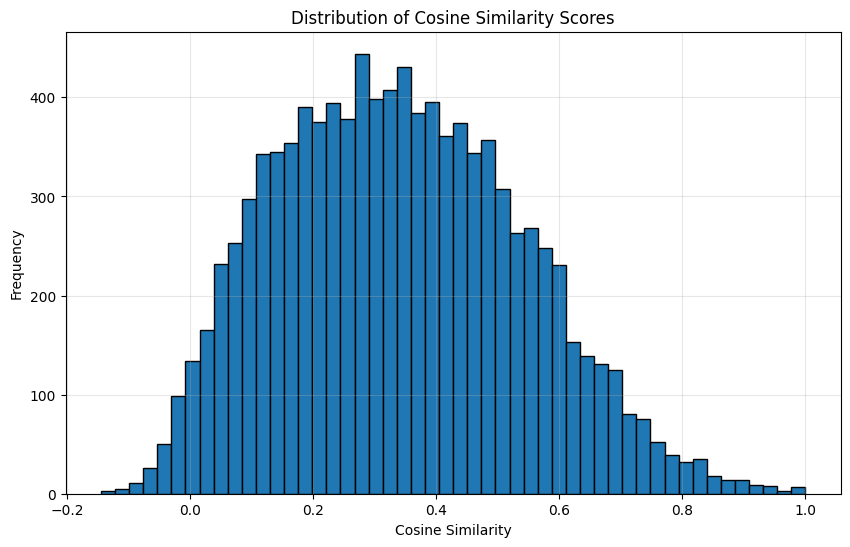

In [17]:
import matplotlib.pyplot as plt

# 获取余弦相似度数据
cos_sim_scores = cosine_scores_2.diagonal()

# 创建直方图
plt.figure(figsize=(10, 6))
plt.hist(cos_sim_scores.cpu().numpy(), bins=50, edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
result_df.head()

,video_name,reference,prediction
0,cog-0010fb2b-f6cd-51af-a0b6-b38812f965ea.mp4,The beautiful woman ，under the starry sky ，loo...,a woman with long hair and a white dress
1,cog-001777d8-0130-5a50-8792-a6b46e02df6d.mp4,a futuristic city full of robots walking throu...,a robot running on the street
2,cog-001e551e-961d-5645-9d84-604bc820bbb7.mp4,computer screen capture of surveillance applic...,The video is shot from the inside of a building.
3,cog-001ead14-07ea-592e-bf94-b32c29bd3692.mp4,"las palmeras se mueven, el oc&#233;ano se muev...",light up the palm trees at night
4,cog-001fd7f2-1b04-5749-b4cc-0469eae5d144.mp4,"a girl shooting ,in the 1990s moives",a girl with pink flowers in her hair


In [25]:
# Get indices where cosine similarity > 0.7
high_sim_indices = (cos_sim_scores > 0.6).nonzero().squeeze().tolist()

# Create a new dataframe with high similarity pairs
high_sim_df = pd.DataFrame({
    'video_name': [result_df['video_name'][i] for i in high_sim_indices],
    'reference': [result_df['reference'][i] for i in high_sim_indices],
    'prediction': [result_df['prediction'][i] for i in high_sim_indices],
    'similarity_score': cos_sim_scores[high_sim_indices].cpu().numpy()
})

# Sort by similarity score in descending order
high_sim_df = high_sim_df.sort_values('similarity_score', ascending=False)

print(f"Number of pairs with similarity > 0.7: {len(high_sim_df)}")
display(high_sim_df.head())

Number of pairs with similarity > 0.7: 1028


,video_name,reference,prediction,similarity_score
66,cog-120e1929-0de0-5cbf-bc77-c16fd10abbda.mp4,A lion standing on a rock,a lion standing on a rock,1.000001
186,cog-2eb99d38-bdd3-5060-958e-c3cfc236ad71.mp4,a yellow umbrella -seed 477881,a yellow umbrella,1.000000
395,cog-5e8a321a-f798-541f-984b-c84ae974c48d.mp4,a woman walking on the beach at sunset,a woman walking on the beach at sunset,1.000000
1013,cog-fc91d84f-9ef0-54aa-b537-5f991f56c35c.mp4,woman standing in front of waterfall,a woman standing in front of a waterfall,0.989053
594,cog-91ea7e61-806b-5c19-95b8-856dd22c9049.mp4,a cat play piano,a cat playing the piano,0.985828


In [26]:
high_sim_df.to_parquet('output/high_sim_over0.6_df.parquet', index=False)

In [27]:
high_sim_df

,video_name,reference,prediction,similarity_score
66,cog-120e1929-0de0-5cbf-bc77-c16fd10abbda.mp4,A lion standing on a rock,a lion standing on a rock,1.000001
186,cog-2eb99d38-bdd3-5060-958e-c3cfc236ad71.mp4,a yellow umbrella -seed 477881,a yellow umbrella,1.000000
395,cog-5e8a321a-f798-541f-984b-c84ae974c48d.mp4,a woman walking on the beach at sunset,a woman walking on the beach at sunset,1.000000
1013,cog-fc91d84f-9ef0-54aa-b537-5f991f56c35c.mp4,woman standing in front of waterfall,a woman standing in front of a waterfall,0.989053
594,cog-91ea7e61-806b-5c19-95b8-856dd22c9049.mp4,a cat play piano,a cat playing the piano,0.985828
...,...,...,...,...
833,cog-cb4c2b68-ea78-5523-813f-9661cdadddc3.mp4,"whitney houston wearing a black gown, with a h...",a woman in a black dress dancing in front of a...,0.600310
680,cog-a22b356d-20f0-54c9-9fdb-64956542c183.mp4,Illustrate a farmer standing with a bag in han...,a man holding a sheep,0.600306
250,cog-3cbbf733-f6e3-5bda-959b-183b19e0551b.mp4,george michael and wham are singing around a c...,man singing and dancing in a Christmas tree,0.600218
344,cog-53b81e89-1377-5b0b-91ea-c7e575b91480.mp4,love coulple see sunsets and crying also,a sunset in the sky,0.600146


In [34]:
import re

def clean_sentence(s):
    s = s.replace("，", ",")  # 替换中文逗号
    s = re.sub(r"-[a-z]+\s*\d+", "", s)  # 去掉如 -fps 24 这种参数
    s = s.strip()
    return s

predictions = [p for p in high_sim_df['prediction']]
references = [[r] for r in high_sim_df['reference']]

res = Calmetic(references=references,predictions=predictions)
print(res['BLEU'])
print(res['ROUGE']['rougeLsum'][1])



BLEU-1 score: 0.45447
BLEU-2 score: 0.16789
BLEU-3 score: 0.06962
BLEU-4 score: 0.02857
ROUGE-1 F1 score: 0.39470
ROUGE-2 F1 score: 0.15023
ROUGE-L F1 score: 0.36395
ROUGE-Lsum F1 score: 0.36408
Average METEOR score: 0.30135


/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average BERTScore F1: 0.89435
{'bleu': 0.04604888421847928, 'precisions': [0.4544704264099037, 0.16789490547901315, 0.06962025316455696, 0.02857142857142857], 'brevity_penalty': 0.4148742082005946, 'length_ratio': 0.5319771696180301, 'translation_length': 7270, 'reference_length': 13666}
Score(precision=0.4653732101557565, recall=0.3548934141151914, fmeasure=0.3640773315796495)


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from torch.nn.functional import cosine_similarity as torch_cosine_similarity
from sentence_transformers import SentenceTransformer, util

sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  #SentenceTransformer("bert-base-uncased") 

embeddings1 = sentence_model.encode(high_sim_df['prediction'], convert_to_tensor=True)
embeddings2 = sentence_model.encode(high_sim_df['reference'], convert_to_tensor=True)

cosine_scores_2 = util.pytorch_cos_sim(embeddings1, embeddings2)  

# 输出余弦相似度的值
print(f"Average Cosine Similarity: {cosine_scores_2.diagonal().mean()}")
print(f"Biggest Cosine Similarity: {cosine_scores_2.diagonal().max()}")
print(f"Middle Cosine Similarity: {cosine_scores_2.diagonal().median()}")

/home/fenghe/anaconda3/envs/vec2txt/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Average Cosine Similarity: 0.6907076835632324
Biggest Cosine Similarity: 1.000000238418579
Middle Cosine Similarity: 0.6720725297927856


In [7]:
import av
import torch
import numpy as np

from transformers import AutoProcessor, AutoModel
from huggingface_hub import hf_hub_download

np.random.seed(0)


def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices


# video clip consists of 300 frames (10 seconds at 30 FPS)
file_path = hf_hub_download(
    repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
)
container = av.open(file_path)

# sample 8 frames
indices = sample_frame_indices(clip_len=8, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")

inputs = processor(
    text=["playing sports", "eating spaghetti", "go shopping"],
    videos=list(video),
    return_tensors="pt",
    padding=True,
)

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits_per_video = outputs.logits_per_video  # this is the video-text similarity score
probs = logits_per_video.softmax(dim=1)  # we can take the softmax to get the label probabilities
print(probs)

/home/fenghe/anaconda3/envs/cogvid/lib/python3.10/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `VideoMAEImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


tensor([[1.9496e-04, 9.9960e-01, 2.0825e-04]])


# Evaluation For Video

In [1]:
import pandas as pd

compare_promts = pd.read_parquet('output/prompt_vid_cos_res/DI+FT_Video2Text_RL_generation_vidsim&bert_over0.5_df.parquet')

In [2]:
compare_promts

,video_name,Origin_generation,DI_generation,reference,similarity_score,RL_generation,DI_video_similarity_score,RL_bert_sim_score,DI_bert_sim_score
0,cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,a blue background with a swirling pattern,blue answer: a swirling pattern with a swirlin...,intricate fractal patterns pulsating rhythmica...,0.516562,blue answer: a swirling pattern with a swirlin...,0.701440,"[0.853244960308075, 0.774155855178833, 0.81177...","[0.853244960308075, 0.774155855178833, 0.81177..."
1,cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4,a boat moving on the ocean,A boat is moving on the ocean\n,boat sailing on ocean during a storm,0.648944,True: A boat is moving on the ocean\n,0.736356,"[0.8889210224151611, 0.90328449010849, 0.89604...","[0.9218382239341736, 0.9153122901916504, 0.918..."
2,cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4,a mannequin with a piano in his hand,a mannequin piano in his hand\n,"skeleton piano in desert valley, 5k -ar 16:9",0.581808,piano mannequin -ar 9:16\n,0.499474,"[0.8794858455657959, 0.8601069450378418, 0.869...","[0.8375121355056763, 0.8002551794052124, 0.818..."
3,cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4,a woman playing a flute in the woods,a woman playing a flute in the forest\n,Woman playing a flute on the side of a river. ...,0.659277,"a woman playing a flute in the forest, a woman...",0.412483,"[0.9179321527481079, 0.9147077798843384, 0.916...","[0.9533786177635193, 0.9126923680305481, 0.932..."
4,cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,a horse running on the beach at sunset,a horse running on the beach at sunset\n,"a horse running on the beach at sunset, 10 sec.",0.930937,"a horse running on the beach at sunset, answer...",0.871103,"[0.9310928583145142, 0.9602124691009521, 0.945...","[0.9907983541488647, 0.9588044881820679, 0.974..."
...,...,...,...,...,...,...,...,...,...
349,cog-fae5f3bb-bb90-5124-8752-f72666a7e687.mp4,a black and white image of a piano playing a song,piano playing a song\n,"piano being built abstractly. Realistic, fast-...",0.503968,piano playing a song\n,0.576373,"[0.924940288066864, 0.8881328105926514, 0.9061...","[0.924940288066864, 0.8881328105926514, 0.9061..."
350,cog-fb03a5ff-649a-56fc-b6f9-a51ff944efd8.mp4,a man with money on his head,a man has money on his head\n,bald evil man laughing with money flying aroun...,0.603580,a man has money on his head\n,0.688969,"[0.9196566939353943, 0.8871486186981201, 0.903...","[0.9196566939353943, 0.8871486186981201, 0.903..."
351,cog-fb0e0bdf-489e-5d4f-94c8-2106474c6425.mp4,a girl eating a cookie,A girl is eating a cookie\n,girl delisiously eating a cookie 4k --ar 16:9,0.735256,A girl is eating a cookie\n,0.874633,"[0.9360616207122803, 0.8052786588668823, 0.865...","[0.9360616207122803, 0.8052786588668823, 0.865..."
352,cog-ff852681-92d2-551c-8890-b910f04778ad.mp4,a man playing saxophone in a garden,a man playing saxophone in a garden\n,"a saxophone playing, a plant, in the city,4k",0.618809,a man playing saxophone in a garden\n,0.849867,"[0.9489210247993469, 0.9018757343292236, 0.924...","[0.9489210247993469, 0.9018757343292236, 0.924..."


In [3]:
from bert_score import score

def bert_sim_eval(candidate_sentence, target_sentence):
    # 将句子放入列表中，因为 bert-score 的 score 函数期望列表输入
    candidates = [candidate_sentence]
    references = [target_sentence]

    # 计算 BertScore
    P, R, F1 = score(candidates, references, lang='en', verbose=True, model_type='bert-base-uncased')
    return {"P":P.item(),"R":R.item(),"F1":F1.item()}

In [4]:
from tqdm import tqdm
P_ours = []
R_ours = []
F1_ours = []
for index,item in tqdm(compare_promts.iterrows(),total=len(compare_promts)):    
    res = bert_sim_eval(item['reference'],item['prediction'])
    P_ours.append(res['P'])
    R_ours.append(res['R'])
    F1_ours.append(res['F1'])

  0%|          | 0/423 [00:00<?, ?it/s]/home/fenghe/anaconda3/envs/ldm_2/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 1/423 [00:02<14:39,  2.08s/it]

done in 0.16 seconds, 6.22 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 2/423 [00:02<08:14,  1.17s/it]

done in 0.01 seconds, 102.88 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 3/423 [00:03<06:11,  1.13it/s]

done in 0.01 seconds, 103.17 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 4/423 [00:03<05:17,  1.32it/s]

done in 0.01 seconds, 106.86 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 5/423 [00:04<04:45,  1.46it/s]

done in 0.01 seconds, 98.83 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 6/423 [00:04<04:25,  1.57it/s]

done in 0.01 seconds, 112.06 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 7/423 [00:05<04:14,  1.63it/s]

done in 0.01 seconds, 106.94 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 8/423 [00:05<04:04,  1.70it/s]

done in 0.01 seconds, 103.61 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 9/423 [00:06<03:54,  1.76it/s]

done in 0.01 seconds, 112.54 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 10/423 [00:07<04:01,  1.71it/s]

done in 0.01 seconds, 103.97 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 11/423 [00:07<03:56,  1.74it/s]

done in 0.01 seconds, 111.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 12/423 [00:08<03:53,  1.76it/s]

done in 0.01 seconds, 82.34 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 13/423 [00:08<03:50,  1.78it/s]

done in 0.01 seconds, 108.81 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 14/423 [00:09<03:45,  1.82it/s]

done in 0.01 seconds, 98.55 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  4%|▎         | 15/423 [00:09<03:43,  1.83it/s]

done in 0.01 seconds, 83.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 16/423 [00:10<03:43,  1.82it/s]

done in 0.01 seconds, 98.89 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 17/423 [00:10<03:42,  1.83it/s]

done in 0.01 seconds, 106.91 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 18/423 [00:11<03:39,  1.84it/s]

done in 0.01 seconds, 106.47 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 19/423 [00:11<03:40,  1.83it/s]

done in 0.01 seconds, 99.33 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 20/423 [00:12<03:43,  1.80it/s]

done in 0.01 seconds, 105.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 21/423 [00:13<03:42,  1.81it/s]

done in 0.01 seconds, 104.16 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 22/423 [00:13<03:40,  1.82it/s]

done in 0.01 seconds, 94.55 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 23/423 [00:14<03:37,  1.84it/s]

done in 0.01 seconds, 108.19 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 24/423 [00:14<03:57,  1.68it/s]

done in 0.01 seconds, 96.58 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 25/423 [00:15<04:13,  1.57it/s]

done in 0.01 seconds, 91.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 26/423 [00:16<04:02,  1.64it/s]

done in 0.01 seconds, 112.91 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  6%|▋         | 27/423 [00:16<03:52,  1.70it/s]

done in 0.01 seconds, 112.03 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 28/423 [00:17<04:15,  1.55it/s]

done in 0.01 seconds, 113.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 29/423 [00:18<05:05,  1.29it/s]

done in 0.01 seconds, 109.48 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 30/423 [00:19<04:43,  1.39it/s]

done in 0.01 seconds, 110.11 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 31/423 [00:19<04:42,  1.39it/s]

done in 0.01 seconds, 113.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 32/423 [00:20<04:20,  1.50it/s]

done in 0.01 seconds, 106.75 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 33/423 [00:20<04:04,  1.60it/s]

done in 0.01 seconds, 109.34 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 34/423 [00:21<03:55,  1.65it/s]

done in 0.01 seconds, 111.80 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 35/423 [00:22<03:53,  1.66it/s]

done in 0.01 seconds, 114.50 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  9%|▊         | 36/423 [00:22<03:48,  1.69it/s]

done in 0.01 seconds, 104.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  9%|▊         | 37/423 [00:23<03:45,  1.71it/s]

done in 0.01 seconds, 108.20 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 38/423 [00:24<04:20,  1.48it/s]

done in 0.01 seconds, 114.55 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 39/423 [00:24<04:06,  1.56it/s]

done in 0.01 seconds, 103.74 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 40/423 [00:25<03:54,  1.63it/s]

done in 0.01 seconds, 106.14 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 41/423 [00:25<03:43,  1.71it/s]

done in 0.01 seconds, 112.23 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 42/423 [00:26<03:56,  1.61it/s]

done in 0.01 seconds, 109.12 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 43/423 [00:27<03:49,  1.65it/s]

done in 0.01 seconds, 79.00 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 44/423 [00:27<03:42,  1.70it/s]

done in 0.01 seconds, 94.67 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 45/423 [00:28<03:37,  1.73it/s]

done in 0.01 seconds, 106.68 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 46/423 [00:28<04:10,  1.51it/s]

done in 0.01 seconds, 109.75 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 47/423 [00:29<03:56,  1.59it/s]

done in 0.01 seconds, 107.63 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 11%|█▏        | 48/423 [00:30<03:47,  1.65it/s]

done in 0.01 seconds, 111.72 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 49/423 [00:30<03:40,  1.70it/s]

done in 0.01 seconds, 76.68 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 50/423 [00:31<03:36,  1.72it/s]

done in 0.01 seconds, 106.27 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 51/423 [00:31<03:32,  1.75it/s]

done in 0.01 seconds, 110.08 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 52/423 [00:32<03:28,  1.78it/s]

done in 0.01 seconds, 111.78 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 53/423 [00:32<03:29,  1.76it/s]

done in 0.02 seconds, 61.48 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 54/423 [00:33<03:31,  1.75it/s]

done in 0.01 seconds, 93.62 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 55/423 [00:34<03:31,  1.74it/s]

done in 0.02 seconds, 63.23 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 56/423 [00:34<03:28,  1.76it/s]

done in 0.01 seconds, 67.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 57/423 [00:35<03:25,  1.78it/s]

done in 0.01 seconds, 112.20 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▎        | 58/423 [00:35<03:22,  1.80it/s]

done in 0.01 seconds, 112.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 59/423 [00:36<03:21,  1.81it/s]

done in 0.01 seconds, 94.98 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 60/423 [00:36<03:19,  1.82it/s]

done in 0.01 seconds, 92.55 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 61/423 [00:37<03:22,  1.78it/s]

done in 0.01 seconds, 107.47 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 62/423 [00:37<03:22,  1.78it/s]

done in 0.01 seconds, 104.45 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 63/423 [00:38<03:30,  1.71it/s]

done in 0.01 seconds, 108.20 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 64/423 [00:39<03:27,  1.73it/s]

done in 0.01 seconds, 100.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 65/423 [00:39<03:25,  1.74it/s]

done in 0.01 seconds, 104.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 66/423 [00:40<03:20,  1.78it/s]

done in 0.01 seconds, 108.81 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 67/423 [00:40<03:16,  1.81it/s]

done in 0.01 seconds, 105.46 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 68/423 [00:41<03:14,  1.82it/s]

done in 0.01 seconds, 102.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▋        | 69/423 [00:41<03:13,  1.83it/s]

done in 0.01 seconds, 107.45 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 70/423 [00:42<03:12,  1.84it/s]

done in 0.01 seconds, 105.88 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 71/423 [00:42<03:11,  1.84it/s]

done in 0.01 seconds, 108.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 72/423 [00:43<03:11,  1.84it/s]

done in 0.01 seconds, 102.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 73/423 [00:43<03:10,  1.84it/s]

done in 0.01 seconds, 109.45 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 74/423 [00:44<03:11,  1.82it/s]

done in 0.01 seconds, 109.07 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 75/423 [00:45<03:19,  1.74it/s]

done in 0.01 seconds, 107.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 76/423 [00:45<03:17,  1.76it/s]

done in 0.01 seconds, 90.12 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 77/423 [00:46<03:14,  1.78it/s]

done in 0.01 seconds, 110.40 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 78/423 [00:46<03:11,  1.80it/s]

done in 0.01 seconds, 103.17 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▊        | 79/423 [00:47<03:09,  1.82it/s]

done in 0.01 seconds, 106.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 80/423 [00:47<03:07,  1.83it/s]

done in 0.01 seconds, 107.64 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 81/423 [00:48<03:04,  1.86it/s]

done in 0.01 seconds, 113.55 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 82/423 [00:48<03:02,  1.87it/s]

done in 0.01 seconds, 105.27 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 83/423 [00:49<03:42,  1.52it/s]

done in 0.01 seconds, 108.17 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 84/423 [00:50<03:41,  1.53it/s]

done in 0.01 seconds, 109.22 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 85/423 [00:51<03:27,  1.63it/s]

done in 0.01 seconds, 110.07 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 86/423 [00:51<03:20,  1.68it/s]

done in 0.01 seconds, 113.37 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 87/423 [00:52<03:25,  1.63it/s]

done in 0.01 seconds, 113.70 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 88/423 [00:52<03:16,  1.71it/s]

done in 0.01 seconds, 108.73 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 89/423 [00:53<03:11,  1.74it/s]HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


done in 0.01 seconds, 109.19 sentences/sec


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 4

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██▏       | 90/423 [01:23<52:53,  9.53s/it]

done in 0.01 seconds, 114.44 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 91/423 [01:24<37:49,  6.84s/it]

done in 0.01 seconds, 107.35 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 92/423 [01:24<27:17,  4.95s/it]

done in 0.01 seconds, 82.20 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 93/423 [01:25<19:56,  3.63s/it]

done in 0.01 seconds, 108.15 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 94/423 [01:25<14:50,  2.71s/it]

done in 0.01 seconds, 114.73 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 95/423 [01:26<11:15,  2.06s/it]

done in 0.01 seconds, 91.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 96/423 [01:27<08:44,  1.60s/it]

done in 0.01 seconds, 109.08 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 97/423 [01:27<07:05,  1.31s/it]

done in 0.01 seconds, 107.34 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 98/423 [01:28<05:51,  1.08s/it]

done in 0.01 seconds, 74.07 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 99/423 [01:28<05:00,  1.08it/s]

done in 0.02 seconds, 59.97 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▎       | 100/423 [01:29<04:22,  1.23it/s]

done in 0.01 seconds, 92.43 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 101/423 [01:29<03:55,  1.37it/s]

done in 0.01 seconds, 108.98 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 102/423 [01:30<03:38,  1.47it/s]

done in 0.01 seconds, 91.72 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 103/423 [01:30<03:25,  1.55it/s]

done in 0.02 seconds, 57.80 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 104/423 [01:31<03:19,  1.60it/s]

done in 0.02 seconds, 62.51 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 105/423 [01:32<03:12,  1.65it/s]

done in 0.01 seconds, 69.89 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 106/423 [01:32<03:06,  1.70it/s]

done in 0.01 seconds, 70.93 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 107/423 [01:33<03:21,  1.57it/s]

done in 0.01 seconds, 111.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 108/423 [01:33<03:11,  1.64it/s]

done in 0.01 seconds, 113.14 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 109/423 [01:34<03:18,  1.58it/s]

done in 0.01 seconds, 89.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 110/423 [01:35<03:12,  1.63it/s]

done in 0.02 seconds, 59.62 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 111/423 [01:35<03:03,  1.70it/s]

done in 0.01 seconds, 80.47 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 112/423 [01:36<02:59,  1.74it/s]

done in 0.01 seconds, 101.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 113/423 [01:36<02:56,  1.76it/s]

done in 0.01 seconds, 112.94 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 114/423 [01:37<03:02,  1.69it/s]

done in 0.01 seconds, 107.64 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 115/423 [01:38<02:56,  1.74it/s]

done in 0.01 seconds, 102.65 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 116/423 [01:38<03:13,  1.59it/s]

done in 0.01 seconds, 113.08 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 117/423 [01:39<03:04,  1.66it/s]

done in 0.01 seconds, 107.28 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 118/423 [01:39<03:00,  1.69it/s]

done in 0.01 seconds, 106.93 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 119/423 [01:40<02:54,  1.75it/s]

done in 0.01 seconds, 106.51 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 120/423 [01:40<02:52,  1.76it/s]

done in 0.01 seconds, 113.68 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▊       | 121/423 [01:41<02:51,  1.76it/s]

done in 0.01 seconds, 70.35 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 122/423 [01:42<02:49,  1.77it/s]

done in 0.01 seconds, 67.37 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 123/423 [01:42<02:55,  1.71it/s]

done in 0.01 seconds, 110.62 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 124/423 [01:43<02:51,  1.74it/s]

done in 0.01 seconds, 111.80 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 125/423 [01:43<02:48,  1.77it/s]

done in 0.01 seconds, 98.11 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 126/423 [01:44<02:45,  1.80it/s]

done in 0.01 seconds, 109.58 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 127/423 [01:44<02:50,  1.73it/s]

done in 0.01 seconds, 108.30 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 128/423 [01:45<02:47,  1.76it/s]

done in 0.01 seconds, 110.94 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 129/423 [01:46<02:46,  1.77it/s]

done in 0.01 seconds, 110.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 130/423 [01:46<02:46,  1.76it/s]

done in 0.01 seconds, 108.37 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 131/423 [01:47<02:43,  1.79it/s]

done in 0.01 seconds, 109.02 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 132/423 [01:47<02:42,  1.79it/s]

done in 0.01 seconds, 112.30 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 31%|███▏      | 133/423 [01:48<02:40,  1.80it/s]

done in 0.01 seconds, 113.01 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 134/423 [01:48<02:48,  1.72it/s]

done in 0.01 seconds, 113.97 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 135/423 [01:49<02:44,  1.75it/s]

done in 0.01 seconds, 94.98 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 136/423 [01:50<02:43,  1.76it/s]

done in 0.01 seconds, 69.59 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 137/423 [01:50<02:41,  1.77it/s]

done in 0.01 seconds, 94.35 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 138/423 [01:51<02:39,  1.79it/s]

done in 0.01 seconds, 114.37 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 139/423 [01:51<02:44,  1.73it/s]

done in 0.01 seconds, 108.83 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 140/423 [01:52<02:44,  1.72it/s]

done in 0.01 seconds, 113.45 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 141/423 [01:52<02:42,  1.74it/s]

done in 0.01 seconds, 115.57 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▎      | 142/423 [01:53<02:52,  1.63it/s]

done in 0.01 seconds, 111.44 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 143/423 [01:54<02:45,  1.69it/s]

done in 0.01 seconds, 108.01 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 144/423 [01:54<02:40,  1.74it/s]

done in 0.01 seconds, 111.36 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 145/423 [01:55<02:37,  1.77it/s]

done in 0.01 seconds, 108.83 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 146/423 [01:55<02:34,  1.79it/s]

done in 0.01 seconds, 112.56 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 147/423 [01:56<02:38,  1.75it/s]

done in 0.01 seconds, 114.90 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 148/423 [01:56<02:35,  1.77it/s]

done in 0.01 seconds, 75.54 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 149/423 [01:57<02:31,  1.80it/s]

done in 0.01 seconds, 108.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 150/423 [01:58<02:31,  1.80it/s]

done in 0.01 seconds, 113.98 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 151/423 [01:58<02:29,  1.82it/s]

done in 0.01 seconds, 107.21 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 152/423 [01:59<02:32,  1.77it/s]

done in 0.01 seconds, 111.30 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 153/423 [01:59<02:30,  1.80it/s]

done in 0.01 seconds, 108.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▋      | 154/423 [02:00<02:29,  1.80it/s]

done in 0.02 seconds, 60.63 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 155/423 [02:00<02:27,  1.81it/s]

done in 0.01 seconds, 108.79 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 156/423 [02:01<02:35,  1.71it/s]

done in 0.01 seconds, 103.79 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 157/423 [02:02<02:33,  1.73it/s]

done in 0.01 seconds, 110.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 158/423 [02:02<02:31,  1.75it/s]

done in 0.01 seconds, 96.47 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 159/423 [02:03<02:41,  1.64it/s]

done in 0.01 seconds, 110.69 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 160/423 [02:03<02:35,  1.69it/s]

done in 0.01 seconds, 111.07 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 161/423 [02:04<02:31,  1.73it/s]

done in 0.01 seconds, 106.28 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 162/423 [02:04<02:27,  1.77it/s]

done in 0.01 seconds, 95.55 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▊      | 163/423 [02:05<02:24,  1.80it/s]

done in 0.01 seconds, 108.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 164/423 [02:06<02:42,  1.60it/s]

done in 0.01 seconds, 109.23 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 165/423 [02:06<02:35,  1.66it/s]

done in 0.01 seconds, 75.06 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 166/423 [02:07<02:29,  1.72it/s]

done in 0.01 seconds, 112.26 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 167/423 [02:07<02:25,  1.76it/s]

done in 0.01 seconds, 113.40 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 168/423 [02:08<02:30,  1.69it/s]

done in 0.01 seconds, 111.40 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 169/423 [02:09<02:33,  1.66it/s]

done in 0.01 seconds, 108.55 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 170/423 [02:09<02:29,  1.70it/s]

done in 0.02 seconds, 62.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 171/423 [02:10<02:26,  1.72it/s]

done in 0.01 seconds, 72.54 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 172/423 [02:10<02:23,  1.75it/s]

done in 0.01 seconds, 105.65 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 173/423 [02:11<02:20,  1.78it/s]

done in 0.02 seconds, 54.56 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 174/423 [02:11<02:18,  1.79it/s]

done in 0.01 seconds, 109.76 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 41%|████▏     | 175/423 [02:12<02:16,  1.81it/s]

done in 0.01 seconds, 108.77 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 176/423 [02:12<02:16,  1.82it/s]

done in 0.01 seconds, 102.14 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 177/423 [02:13<02:14,  1.83it/s]

done in 0.01 seconds, 99.87 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 178/423 [02:14<02:15,  1.81it/s]

done in 0.01 seconds, 101.81 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 179/423 [02:14<02:14,  1.82it/s]

done in 0.01 seconds, 101.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 180/423 [02:15<02:14,  1.81it/s]

done in 0.02 seconds, 60.11 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 181/423 [02:15<02:14,  1.80it/s]

done in 0.01 seconds, 100.44 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 182/423 [02:16<02:13,  1.80it/s]

done in 0.01 seconds, 104.46 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 183/423 [02:16<02:12,  1.81it/s]

done in 0.01 seconds, 107.51 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 184/423 [02:17<02:11,  1.81it/s]

done in 0.01 seconds, 98.56 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▎     | 185/423 [02:17<02:10,  1.82it/s]

done in 0.01 seconds, 108.70 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 186/423 [02:18<02:19,  1.70it/s]

done in 0.01 seconds, 105.52 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 187/423 [02:19<02:16,  1.73it/s]

done in 0.01 seconds, 111.71 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 188/423 [02:19<02:12,  1.77it/s]

done in 0.01 seconds, 110.60 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 189/423 [02:20<02:10,  1.79it/s]

done in 0.01 seconds, 106.60 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 190/423 [02:20<02:07,  1.82it/s]

done in 0.01 seconds, 111.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 191/423 [02:21<02:07,  1.82it/s]

done in 0.01 seconds, 98.71 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 192/423 [02:21<02:06,  1.82it/s]

done in 0.01 seconds, 109.80 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 193/423 [02:22<02:05,  1.83it/s]

done in 0.01 seconds, 113.56 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 194/423 [02:22<02:04,  1.84it/s]

done in 0.01 seconds, 102.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 195/423 [02:23<02:14,  1.70it/s]

done in 0.01 seconds, 99.46 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▋     | 196/423 [02:24<02:23,  1.58it/s]

done in 0.01 seconds, 111.89 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 197/423 [02:25<02:23,  1.57it/s]

done in 0.01 seconds, 68.01 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 198/423 [02:25<02:19,  1.62it/s]

done in 0.02 seconds, 43.71 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 199/423 [02:26<02:14,  1.66it/s]

done in 0.02 seconds, 65.36 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 200/423 [02:26<02:11,  1.69it/s]

done in 0.01 seconds, 110.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 201/423 [02:27<02:09,  1.72it/s]

done in 0.01 seconds, 106.36 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 202/423 [02:28<02:17,  1.61it/s]

done in 0.01 seconds, 106.19 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 203/423 [02:28<02:10,  1.68it/s]HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


done in 0.01 seconds, 111.24 sentences/sec


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 4

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 204/423 [03:06<43:36, 11.95s/it]

done in 0.02 seconds, 60.23 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 205/423 [03:08<31:38,  8.71s/it]

done in 0.01 seconds, 104.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▊     | 206/423 [03:08<22:38,  6.26s/it]

done in 0.01 seconds, 99.32 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 207/423 [03:09<16:34,  4.60s/it]

done in 0.01 seconds, 109.95 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 208/423 [03:09<12:07,  3.38s/it]

done in 0.01 seconds, 109.89 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 209/423 [03:10<09:00,  2.53s/it]

done in 0.01 seconds, 111.79 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 210/423 [03:11<06:51,  1.93s/it]

done in 0.01 seconds, 98.95 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 211/423 [03:11<05:20,  1.51s/it]

done in 0.01 seconds, 108.96 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 212/423 [03:12<04:17,  1.22s/it]

done in 0.01 seconds, 113.91 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 213/423 [03:12<03:48,  1.09s/it]

done in 0.01 seconds, 100.28 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 214/423 [03:13<03:12,  1.08it/s]

done in 0.01 seconds, 109.43 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 215/423 [03:13<02:48,  1.24it/s]

done in 0.01 seconds, 110.49 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 216/423 [03:14<02:30,  1.37it/s]

done in 0.01 seconds, 109.23 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████▏    | 217/423 [03:15<02:19,  1.48it/s]

done in 0.01 seconds, 105.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 218/423 [03:15<02:10,  1.57it/s]

done in 0.01 seconds, 103.72 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 219/423 [03:16<02:04,  1.63it/s]

done in 0.02 seconds, 64.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 220/423 [03:16<01:59,  1.70it/s]

done in 0.01 seconds, 112.16 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 221/423 [03:17<01:56,  1.74it/s]

done in 0.01 seconds, 113.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 222/423 [03:17<01:53,  1.77it/s]

done in 0.01 seconds, 113.59 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 223/423 [03:18<01:53,  1.76it/s]

done in 0.01 seconds, 104.01 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 224/423 [03:18<01:52,  1.77it/s]

done in 0.01 seconds, 105.68 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 225/423 [03:19<01:52,  1.77it/s]

done in 0.01 seconds, 102.40 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 226/423 [03:20<01:49,  1.79it/s]

done in 0.01 seconds, 100.85 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▎    | 227/423 [03:20<01:49,  1.79it/s]

done in 0.01 seconds, 106.24 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 228/423 [03:21<01:48,  1.80it/s]

done in 0.01 seconds, 110.33 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 229/423 [03:21<01:47,  1.81it/s]

done in 0.01 seconds, 85.00 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 230/423 [03:22<01:47,  1.80it/s]

done in 0.02 seconds, 53.79 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 231/423 [03:22<01:46,  1.80it/s]

done in 0.02 seconds, 60.93 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 232/423 [03:23<01:49,  1.75it/s]

done in 0.01 seconds, 104.08 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 233/423 [03:23<01:49,  1.73it/s]

done in 0.01 seconds, 110.38 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 234/423 [03:24<01:47,  1.76it/s]

done in 0.01 seconds, 105.96 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 235/423 [03:25<02:12,  1.42it/s]

done in 0.01 seconds, 110.78 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 236/423 [03:26<02:03,  1.51it/s]

done in 0.02 seconds, 58.77 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 237/423 [03:26<01:56,  1.59it/s]

done in 0.01 seconds, 101.65 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▋    | 238/423 [03:27<01:50,  1.67it/s]

done in 0.01 seconds, 102.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 239/423 [03:27<01:47,  1.71it/s]

done in 0.01 seconds, 103.62 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 240/423 [03:28<01:57,  1.55it/s]

done in 0.01 seconds, 109.62 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 241/423 [03:29<01:52,  1.62it/s]

done in 0.01 seconds, 106.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 242/423 [03:29<01:49,  1.65it/s]

done in 0.01 seconds, 114.61 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 243/423 [03:30<01:45,  1.71it/s]

done in 0.01 seconds, 114.21 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 244/423 [03:30<01:41,  1.76it/s]

done in 0.01 seconds, 114.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 245/423 [03:31<01:40,  1.77it/s]

done in 0.01 seconds, 112.92 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 246/423 [03:31<01:38,  1.80it/s]

done in 0.01 seconds, 107.07 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 247/423 [03:32<01:36,  1.82it/s]

done in 0.01 seconds, 112.15 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▊    | 248/423 [03:32<01:34,  1.84it/s]

done in 0.01 seconds, 112.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 249/423 [03:33<01:52,  1.55it/s]

done in 0.01 seconds, 108.86 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 250/423 [03:34<01:46,  1.62it/s]

done in 0.01 seconds, 105.38 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 251/423 [03:35<01:50,  1.55it/s]

done in 0.01 seconds, 109.02 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 252/423 [03:35<01:46,  1.60it/s]

done in 0.01 seconds, 117.80 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 253/423 [03:36<01:42,  1.66it/s]

done in 0.01 seconds, 104.71 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 254/423 [03:36<01:38,  1.71it/s]

done in 0.01 seconds, 107.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 255/423 [03:37<01:37,  1.72it/s]

done in 0.01 seconds, 109.49 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 256/423 [03:37<01:34,  1.76it/s]

done in 0.01 seconds, 113.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 257/423 [03:38<01:32,  1.79it/s]

done in 0.01 seconds, 73.86 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 258/423 [03:38<01:33,  1.76it/s]

done in 0.01 seconds, 109.84 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 259/423 [03:39<01:51,  1.48it/s]

done in 0.01 seconds, 112.90 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████▏   | 260/423 [03:40<01:43,  1.58it/s]

done in 0.01 seconds, 111.38 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 261/423 [03:40<01:38,  1.65it/s]

done in 0.01 seconds, 118.07 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 262/423 [03:41<01:34,  1.70it/s]

done in 0.01 seconds, 110.72 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 263/423 [03:42<01:32,  1.73it/s]

done in 0.01 seconds, 99.91 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 264/423 [03:42<01:30,  1.76it/s]

done in 0.01 seconds, 112.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 265/423 [03:43<01:28,  1.79it/s]

done in 0.01 seconds, 108.91 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 266/423 [03:43<01:27,  1.80it/s]

done in 0.01 seconds, 111.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 267/423 [03:44<01:25,  1.83it/s]

done in 0.01 seconds, 97.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 268/423 [03:44<01:28,  1.75it/s]

done in 0.01 seconds, 109.61 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▎   | 269/423 [03:45<01:27,  1.76it/s]

done in 0.01 seconds, 113.36 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 270/423 [03:45<01:25,  1.78it/s]

done in 0.01 seconds, 104.22 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 271/423 [03:46<01:25,  1.79it/s]

done in 0.01 seconds, 102.19 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 272/423 [03:47<01:23,  1.80it/s]

done in 0.01 seconds, 108.59 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 273/423 [03:47<01:23,  1.81it/s]

done in 0.01 seconds, 114.17 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 274/423 [03:48<01:21,  1.82it/s]

done in 0.01 seconds, 107.44 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 275/423 [03:48<01:20,  1.83it/s]

done in 0.02 seconds, 61.71 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 276/423 [03:49<01:21,  1.81it/s]

done in 0.01 seconds, 84.89 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 277/423 [03:49<01:20,  1.81it/s]

done in 0.01 seconds, 109.67 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 278/423 [03:50<01:20,  1.81it/s]

done in 0.01 seconds, 107.02 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 279/423 [03:50<01:21,  1.77it/s]

done in 0.01 seconds, 98.68 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 280/423 [03:51<01:19,  1.80it/s]

done in 0.01 seconds, 116.67 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▋   | 281/423 [03:52<01:18,  1.80it/s]

done in 0.01 seconds, 109.20 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 282/423 [03:52<01:18,  1.81it/s]

done in 0.01 seconds, 109.19 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 283/423 [03:53<01:17,  1.81it/s]

done in 0.01 seconds, 115.20 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 284/423 [03:53<01:16,  1.81it/s]

done in 0.01 seconds, 97.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 285/423 [03:54<01:21,  1.70it/s]

done in 0.01 seconds, 105.69 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 286/423 [03:54<01:18,  1.74it/s]

done in 0.01 seconds, 102.45 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 287/423 [03:55<01:17,  1.76it/s]

done in 0.01 seconds, 108.14 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 288/423 [03:56<01:25,  1.58it/s]

done in 0.01 seconds, 112.42 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 289/423 [03:57<01:36,  1.39it/s]

done in 0.01 seconds, 105.26 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▊   | 290/423 [03:57<01:40,  1.32it/s]

done in 0.01 seconds, 96.62 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 291/423 [03:58<01:31,  1.44it/s]

done in 0.01 seconds, 102.26 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 292/423 [03:59<01:31,  1.44it/s]

done in 0.01 seconds, 106.22 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 293/423 [03:59<01:25,  1.52it/s]

done in 0.01 seconds, 104.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 294/423 [04:00<01:20,  1.60it/s]

done in 0.01 seconds, 104.45 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 295/423 [04:00<01:16,  1.67it/s]

done in 0.01 seconds, 68.89 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 296/423 [04:01<01:25,  1.49it/s]

done in 0.01 seconds, 113.49 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 297/423 [04:02<01:20,  1.57it/s]

done in 0.01 seconds, 103.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 298/423 [04:02<01:15,  1.64it/s]

done in 0.01 seconds, 115.35 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 299/423 [04:03<01:12,  1.71it/s]

done in 0.01 seconds, 109.00 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 300/423 [04:03<01:10,  1.75it/s]

done in 0.01 seconds, 111.95 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 301/423 [04:04<01:08,  1.78it/s]

done in 0.01 seconds, 112.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████▏  | 302/423 [04:04<01:06,  1.81it/s]

done in 0.01 seconds, 106.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 303/423 [04:05<01:07,  1.78it/s]

done in 0.01 seconds, 103.22 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 304/423 [04:06<01:05,  1.81it/s]

done in 0.01 seconds, 111.91 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 305/423 [04:06<01:05,  1.80it/s]

done in 0.01 seconds, 116.74 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 306/423 [04:07<01:04,  1.80it/s]

done in 0.01 seconds, 107.32 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 307/423 [04:07<01:04,  1.81it/s]

done in 0.01 seconds, 113.94 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 308/423 [04:08<01:03,  1.82it/s]

done in 0.01 seconds, 111.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 309/423 [04:08<01:05,  1.75it/s]

done in 0.01 seconds, 112.85 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 310/423 [04:09<01:03,  1.78it/s]

done in 0.01 seconds, 111.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▎  | 311/423 [04:09<01:01,  1.81it/s]

done in 0.01 seconds, 110.23 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 312/423 [04:10<01:01,  1.82it/s]

done in 0.01 seconds, 108.08 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 313/423 [04:11<01:19,  1.38it/s]

done in 0.01 seconds, 113.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 314/423 [04:12<01:13,  1.49it/s]

done in 0.01 seconds, 99.27 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 315/423 [04:12<01:09,  1.55it/s]

done in 0.02 seconds, 61.65 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 316/423 [04:13<01:05,  1.63it/s]

done in 0.01 seconds, 103.04 sentences/sec


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 317/423 [04:36<13:09,  7.45s/it]HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


done in 0.01 seconds, 116.09 sentences/sec


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 318/423 [04:52<17:20,  9.91s/it]

done in 0.01 seconds, 106.74 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 319/423 [04:52<12:17,  7.10s/it]

done in 0.01 seconds, 112.25 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 320/423 [04:53<08:48,  5.13s/it]

done in 0.01 seconds, 108.49 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 321/423 [04:54<06:23,  3.76s/it]

done in 0.01 seconds, 107.36 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 322/423 [04:54<04:42,  2.80s/it]

done in 0.01 seconds, 109.60 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▋  | 323/423 [04:55<03:32,  2.12s/it]

done in 0.01 seconds, 112.27 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 324/423 [04:55<02:43,  1.66s/it]

done in 0.01 seconds, 115.17 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 325/423 [04:56<02:09,  1.32s/it]

done in 0.01 seconds, 103.14 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 326/423 [04:56<01:45,  1.09s/it]

done in 0.01 seconds, 111.57 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 327/423 [04:57<01:29,  1.07it/s]

done in 0.01 seconds, 112.25 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 328/423 [04:57<01:17,  1.22it/s]

done in 0.01 seconds, 110.82 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 329/423 [04:58<01:12,  1.29it/s]

done in 0.01 seconds, 102.79 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 330/423 [04:59<01:06,  1.40it/s]

done in 0.01 seconds, 108.64 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 331/423 [04:59<01:00,  1.51it/s]

done in 0.01 seconds, 113.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 332/423 [05:00<00:56,  1.60it/s]

done in 0.01 seconds, 111.56 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▊  | 333/423 [05:00<00:53,  1.68it/s]

done in 0.01 seconds, 109.70 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 334/423 [05:01<00:53,  1.65it/s]

done in 0.01 seconds, 107.99 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 335/423 [05:02<00:55,  1.60it/s]

done in 0.01 seconds, 103.19 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 336/423 [05:02<00:52,  1.67it/s]

done in 0.01 seconds, 111.30 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 337/423 [05:03<00:49,  1.72it/s]

done in 0.01 seconds, 99.27 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 338/423 [05:03<00:48,  1.76it/s]

done in 0.01 seconds, 97.32 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 339/423 [05:04<00:51,  1.62it/s]

done in 0.01 seconds, 112.93 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 340/423 [05:04<00:49,  1.66it/s]

done in 0.01 seconds, 82.38 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 341/423 [05:05<00:49,  1.67it/s]

done in 0.01 seconds, 110.89 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 342/423 [05:06<00:47,  1.70it/s]

done in 0.01 seconds, 67.79 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 343/423 [05:07<00:55,  1.44it/s]

done in 0.01 seconds, 117.35 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████▏ | 344/423 [05:07<00:51,  1.54it/s]

done in 0.01 seconds, 107.81 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 345/423 [05:08<00:48,  1.62it/s]

done in 0.01 seconds, 108.84 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 346/423 [05:08<00:45,  1.69it/s]

done in 0.01 seconds, 110.46 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 347/423 [05:09<00:43,  1.74it/s]

done in 0.01 seconds, 106.49 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 348/423 [05:09<00:42,  1.76it/s]

done in 0.01 seconds, 114.73 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 349/423 [05:10<00:41,  1.79it/s]

done in 0.01 seconds, 106.20 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 350/423 [05:10<00:40,  1.81it/s]

done in 0.01 seconds, 102.63 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 351/423 [05:11<00:39,  1.83it/s]

done in 0.01 seconds, 115.47 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 352/423 [05:12<00:42,  1.68it/s]

done in 0.01 seconds, 101.37 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 353/423 [05:12<00:40,  1.73it/s]

done in 0.01 seconds, 111.19 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▎ | 354/423 [05:13<00:38,  1.77it/s]

done in 0.01 seconds, 110.06 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 355/423 [05:13<00:39,  1.74it/s]

done in 0.01 seconds, 96.97 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 356/423 [05:14<00:38,  1.74it/s]

done in 0.01 seconds, 108.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 357/423 [05:14<00:37,  1.77it/s]

done in 0.01 seconds, 112.17 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 358/423 [05:15<00:36,  1.77it/s]

done in 0.01 seconds, 108.50 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 359/423 [05:16<00:36,  1.75it/s]

done in 0.01 seconds, 112.89 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 360/423 [05:16<00:35,  1.75it/s]

done in 0.01 seconds, 105.65 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 361/423 [05:17<00:34,  1.78it/s]

done in 0.01 seconds, 110.84 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 362/423 [05:17<00:35,  1.71it/s]

done in 0.01 seconds, 104.01 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 363/423 [05:18<00:34,  1.75it/s]

done in 0.01 seconds, 112.71 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 364/423 [05:18<00:33,  1.77it/s]

done in 0.01 seconds, 111.00 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▋ | 365/423 [05:19<00:33,  1.74it/s]

done in 0.01 seconds, 113.03 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 366/423 [05:19<00:32,  1.78it/s]

done in 0.01 seconds, 97.48 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 367/423 [05:20<00:31,  1.80it/s]

done in 0.01 seconds, 109.60 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 368/423 [05:21<00:30,  1.78it/s]

done in 0.01 seconds, 106.54 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 369/423 [05:21<00:30,  1.79it/s]

done in 0.01 seconds, 110.78 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 370/423 [05:22<00:29,  1.81it/s]

done in 0.01 seconds, 102.33 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 371/423 [05:22<00:28,  1.83it/s]

done in 0.01 seconds, 111.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 372/423 [05:23<00:28,  1.82it/s]

done in 0.01 seconds, 114.71 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 373/423 [05:23<00:27,  1.81it/s]

done in 0.01 seconds, 106.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 374/423 [05:24<00:26,  1.82it/s]

done in 0.01 seconds, 112.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▊ | 375/423 [05:24<00:26,  1.83it/s]

done in 0.01 seconds, 112.07 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 376/423 [05:25<00:31,  1.47it/s]

done in 0.01 seconds, 102.24 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 377/423 [05:26<00:29,  1.55it/s]

done in 0.01 seconds, 79.11 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 378/423 [05:27<00:27,  1.64it/s]

done in 0.01 seconds, 113.70 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 379/423 [05:27<00:25,  1.70it/s]

done in 0.01 seconds, 113.45 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 380/423 [05:28<00:24,  1.74it/s]

done in 0.01 seconds, 97.47 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 381/423 [05:28<00:23,  1.75it/s]

done in 0.02 seconds, 65.36 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 382/423 [05:29<00:24,  1.69it/s]

done in 0.01 seconds, 106.02 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 383/423 [05:29<00:22,  1.74it/s]

done in 0.01 seconds, 111.30 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 384/423 [05:30<00:21,  1.78it/s]

done in 0.01 seconds, 96.78 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 385/423 [05:30<00:21,  1.74it/s]

done in 0.01 seconds, 111.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████▏| 386/423 [05:31<00:20,  1.77it/s]

done in 0.01 seconds, 113.38 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████▏| 387/423 [05:32<00:20,  1.79it/s]

done in 0.01 seconds, 112.72 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 388/423 [05:32<00:21,  1.66it/s]

done in 0.01 seconds, 77.20 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 389/423 [05:33<00:19,  1.72it/s]

done in 0.01 seconds, 106.58 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 390/423 [05:33<00:18,  1.75it/s]

done in 0.01 seconds, 104.67 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 391/423 [05:34<00:18,  1.75it/s]

done in 0.01 seconds, 111.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 392/423 [05:34<00:17,  1.77it/s]

done in 0.01 seconds, 111.13 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 393/423 [05:35<00:16,  1.79it/s]

done in 0.01 seconds, 112.24 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 394/423 [05:36<00:16,  1.79it/s]

done in 0.01 seconds, 106.30 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 395/423 [05:36<00:15,  1.81it/s]

done in 0.01 seconds, 107.61 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▎| 396/423 [05:37<00:14,  1.82it/s]

done in 0.01 seconds, 103.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 397/423 [05:37<00:14,  1.84it/s]

done in 0.01 seconds, 96.67 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 398/423 [05:38<00:13,  1.86it/s]

done in 0.01 seconds, 103.94 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 399/423 [05:38<00:12,  1.86it/s]

done in 0.01 seconds, 103.54 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 400/423 [05:39<00:12,  1.87it/s]

done in 0.01 seconds, 108.06 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 401/423 [05:39<00:11,  1.87it/s]

done in 0.01 seconds, 107.59 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 402/423 [05:40<00:11,  1.86it/s]

done in 0.01 seconds, 111.19 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 403/423 [05:40<00:10,  1.85it/s]

done in 0.01 seconds, 106.56 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 404/423 [05:41<00:10,  1.75it/s]

done in 0.01 seconds, 110.02 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 405/423 [05:42<00:10,  1.77it/s]

done in 0.01 seconds, 103.77 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 406/423 [05:42<00:10,  1.55it/s]

done in 0.01 seconds, 110.96 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 407/423 [05:43<00:10,  1.55it/s]

done in 0.01 seconds, 108.90 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▋| 408/423 [05:44<00:09,  1.64it/s]

done in 0.01 seconds, 109.65 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 409/423 [05:44<00:08,  1.68it/s]

done in 0.01 seconds, 116.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 410/423 [05:45<00:07,  1.71it/s]

done in 0.01 seconds, 113.59 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 411/423 [05:45<00:06,  1.75it/s]

done in 0.01 seconds, 112.44 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 412/423 [05:46<00:06,  1.75it/s]

done in 0.01 seconds, 111.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 413/423 [05:46<00:05,  1.78it/s]

done in 0.01 seconds, 110.75 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 414/423 [05:47<00:05,  1.79it/s]

done in 0.01 seconds, 108.92 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 415/423 [05:47<00:04,  1.81it/s]

done in 0.01 seconds, 99.60 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 416/423 [05:48<00:03,  1.83it/s]

done in 0.01 seconds, 108.84 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▊| 417/423 [05:49<00:03,  1.84it/s]

done in 0.01 seconds, 110.08 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 418/423 [05:49<00:02,  1.84it/s]

done in 0.01 seconds, 111.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 419/423 [05:50<00:02,  1.85it/s]

done in 0.01 seconds, 107.62 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 420/423 [05:50<00:01,  1.85it/s]

done in 0.01 seconds, 108.03 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 421/423 [05:51<00:01,  1.85it/s]

done in 0.01 seconds, 109.13 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 422/423 [05:51<00:00,  1.84it/s]

done in 0.01 seconds, 105.32 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 423/423 [05:52<00:00,  1.20it/s]

done in 0.01 seconds, 110.75 sentences/sec


In [5]:
print(sum(P_ours)/len(P_ours))
print(sum(R_ours)/len(R_ours))
print(sum(F1_ours)/len(F1_ours))

0.5290341418826552
0.6189797560092123
0.5649195225385346


In [1]:
# xclip

In [3]:
import torch
from diffusers import CogVideoXPipeline
from diffusers.utils import export_to_video
import gc


def gen_pic(compare_df):
    pipe = CogVideoXPipeline.from_pretrained(
        "THUDM/CogVideoX-2b",
        torch_dtype=torch.float16
    ).to("cuda")

    # pipe.enable_model_cpu_offload()
    # pipe.enable_sequential_cpu_offload()
    pipe.vae.enable_slicing()
    pipe.vae.enable_tiling()
    
    for idx,row in compare_df.iterrows():
        prompt = row['RL_generation']
        video_name = row['video_name']

        print(f"[{idx+1}/{len(compare_df)}] Generating: RL_gen_{video_name}")

        try:
            video = pipe(
                prompt=prompt,
                num_videos_per_prompt=1,
                num_inference_steps=50,
                num_frames=49,
                guidance_scale=6,
                generator=torch.Generator(device="cuda").manual_seed(42),
            ).frames[0]

            export_to_video(video, f"output/RL_genvideos/RL_gen_{video_name}", fps=8)

        except Exception as e:
            print(f"❌ Error generating {video_name}: {e}")

        finally:
            # 显式释放显存
            del video
            torch.cuda.empty_cache()
            gc.collect()

        # if 'pipe' in globals():
        #     del pipe
        #     gc.collect()
        #     torch.cuda.empty_cache()

/home/fenghe/anaconda3/envs/cogvid/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-18 23:01:12,015] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/fenghe/anaconda3/envs/cogvid/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/fenghe/anaconda3/envs/cogvid/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [4]:
gen_pic(compare_promts)

Loading pipeline components...: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]


[1/354] Generating: RL_gen_cog-01272017-269f-5b42-8458-878ac1228a2e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[2/354] Generating: RL_gen_cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[3/354] Generating: RL_gen_cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[4/354] Generating: RL_gen_cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[5/354] Generating: RL_gen_cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[6/354] Generating: RL_gen_cog-0619814e-a4f4-5ac8-b807-8190ce383644.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[7/354] Generating: RL_gen_cog-067f8007-05ad-5a70-8e58-5c3a68391f8d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[8/354] Generating: RL_gen_cog-0707b606-fc70-59b6-997d-6dd7beebf96d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[9/354] Generating: RL_gen_cog-0749ccb3-10c0-5ae9-87e1-66600bf02340.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[10/354] Generating: RL_gen_cog-07f17525-b6d4-5331-9b96-59bd46187490.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[11/354] Generating: RL_gen_cog-080c79d8-b602-5848-8bb7-cead82986480.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[12/354] Generating: RL_gen_cog-085cc001-9479-538d-abd4-5fab9dec11fa.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[13/354] Generating: RL_gen_cog-09df3e66-bc29-5769-aba1-80b05073ef65.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[14/354] Generating: RL_gen_cog-0af74408-e002-5bd7-abc8-62330c467e41.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[15/354] Generating: RL_gen_cog-0b10921c-9890-5d3a-bb20-0fa7585b57f2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[16/354] Generating: RL_gen_cog-0b1b32aa-2d66-5ee6-b9d6-5872643c4840.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[17/354] Generating: RL_gen_cog-0b4ca90b-2cbc-5d88-a98f-3d526c2dbda6.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[18/354] Generating: RL_gen_cog-0bf3b351-c5ad-5b54-926e-990f08e0f2e2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[19/354] Generating: RL_gen_cog-0c3db362-b163-5f1a-ab86-6c86c5990c9a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[20/354] Generating: RL_gen_cog-0c4e68e0-f3ea-5c91-93f6-2767438efcf2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[21/354] Generating: RL_gen_cog-0d024210-c10d-5b95-be1c-55d6ffc89033.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[22/354] Generating: RL_gen_cog-10ad45d1-c858-5287-a340-c65289d6f064.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[23/354] Generating: RL_gen_cog-113de380-404b-5fa7-8f70-2d8f73295382.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[24/354] Generating: RL_gen_cog-11cfee16-ae84-594e-9c54-ed5f77f89ec6.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[25/354] Generating: RL_gen_cog-12dbce4e-4a49-5340-bccb-ea0202c7005c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[26/354] Generating: RL_gen_cog-12fa78ac-272a-5cd3-81d5-2031228aa761.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[27/354] Generating: RL_gen_cog-131ebc0e-04d3-5120-9e78-6bcb8eff9f64.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[28/354] Generating: RL_gen_cog-14e59334-d822-5658-a6da-15bb103e3165.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[29/354] Generating: RL_gen_cog-1590841f-b5d4-5c15-8232-f20517a42d01.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[30/354] Generating: RL_gen_cog-15986efb-236c-5e29-a8b4-43216910509e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[31/354] Generating: RL_gen_cog-15ec6300-d5f2-572d-838b-4f5c92e04bf9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[32/354] Generating: RL_gen_cog-1742977e-81c9-590c-bfa2-cea724ef3707.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[33/354] Generating: RL_gen_cog-17dfe102-1b91-5ff9-abe1-b720457607a7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[34/354] Generating: RL_gen_cog-1825ee02-bb2b-534c-86e1-80c01387dd43.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[35/354] Generating: RL_gen_cog-1902bbdc-4176-51de-a86b-c1a7e92ea6bc.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[36/354] Generating: RL_gen_cog-19a96ac0-d60e-5f08-84b2-bb89e873eb7b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[37/354] Generating: RL_gen_cog-1a8a7234-bd30-566d-b9b2-5060c45b0e63.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[38/354] Generating: RL_gen_cog-1c9d5855-1774-5458-b215-10cd12d9257d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[39/354] Generating: RL_gen_cog-1d49c911-10ff-5511-8a5b-dc0de3ce8f6a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[40/354] Generating: RL_gen_cog-1d58c62e-0380-50e1-95a7-c0b1006df930.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[41/354] Generating: RL_gen_cog-1d75d219-dfdd-5834-aa97-3a2d04435fc4.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[42/354] Generating: RL_gen_cog-1eb08328-c71b-54d5-b464-ca1918be4525.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[43/354] Generating: RL_gen_cog-1ef96c33-474b-5839-bea7-cf4249101c0c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[44/354] Generating: RL_gen_cog-1f0ac4a3-a6d2-574b-95ee-9c8ac7fe46e3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[45/354] Generating: RL_gen_cog-1f56241b-a7e7-5eae-a34b-a41544ba21f0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[46/354] Generating: RL_gen_cog-20dfa9e0-54cc-5891-8317-e4aeacdec205.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[47/354] Generating: RL_gen_cog-217625f7-3575-5ff1-82c5-285671f5967c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[48/354] Generating: RL_gen_cog-2251b802-4191-56cc-bf99-519608e2511f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[49/354] Generating: RL_gen_cog-229f6ab3-50da-50ae-9bcd-c1b0585496e8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[50/354] Generating: RL_gen_cog-23410861-321a-5c4b-b468-590d6b199831.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[51/354] Generating: RL_gen_cog-252baba4-dfda-5d90-88f8-b25f3551b6a8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[52/354] Generating: RL_gen_cog-25c42373-ed97-51f7-907b-d75197273dbd.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[53/354] Generating: RL_gen_cog-26c23440-133c-5ffe-8c94-88874c6c2721.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[54/354] Generating: RL_gen_cog-26c9c990-b423-5d94-90f2-d49affea0774.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[55/354] Generating: RL_gen_cog-279a8fe9-e65d-5749-80d8-a88e09eb0f0f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[56/354] Generating: RL_gen_cog-27c229da-6b9c-5c31-8032-67e6e6a1675d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[57/354] Generating: RL_gen_cog-28233dac-9d8f-5285-8b7f-5f9ffd064161.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[58/354] Generating: RL_gen_cog-2882ca75-113a-5bbc-8149-db293f75d1ea.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[59/354] Generating: RL_gen_cog-28aa844a-d9d7-5ed5-b1ea-649fda6b3126.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[60/354] Generating: RL_gen_cog-2b8d5a88-7454-5479-a548-efdcbadf87e2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[61/354] Generating: RL_gen_cog-2c936415-0f36-5fc2-b7a7-d9145d762675.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[62/354] Generating: RL_gen_cog-2c9b77f6-9558-5353-93b0-b009a9089f0e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[63/354] Generating: RL_gen_cog-2d6aa4ca-4d54-5397-95ad-af451185a0fc.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[64/354] Generating: RL_gen_cog-2db133d9-26c6-595b-a598-f8aac1157ea6.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[65/354] Generating: RL_gen_cog-2e94a277-224b-535d-8757-389a56efdcfb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[66/354] Generating: RL_gen_cog-2eba1d4b-0e9e-50af-84e5-2d65b6a93287.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[67/354] Generating: RL_gen_cog-2f008e04-b8b7-5e8b-a3a4-c8a9b806f64f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[68/354] Generating: RL_gen_cog-2f646d8b-8520-5e46-8b66-31304466853c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[69/354] Generating: RL_gen_cog-2ffe9520-15f5-5a6b-9a71-1646c8e591cd.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[70/354] Generating: RL_gen_cog-3062f025-0e25-560b-b4fa-85a749c1011f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[71/354] Generating: RL_gen_cog-30ef98f8-0bc6-5005-8096-e2068e184a89.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[72/354] Generating: RL_gen_cog-31137108-1079-5e5f-aabe-4bd05b538997.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[73/354] Generating: RL_gen_cog-3276ae42-4d4f-5319-94ec-b1ec381729cd.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[74/354] Generating: RL_gen_cog-32867130-28ba-56ce-9b4b-de524ced814d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[75/354] Generating: RL_gen_cog-32eba297-4f38-5fa0-b9ef-9a493794eef8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[76/354] Generating: RL_gen_cog-344e7e9b-9df5-5db9-abfa-a2450df406eb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[77/354] Generating: RL_gen_cog-3471692c-01b2-589f-a6af-b5f8780dc4ad.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[78/354] Generating: RL_gen_cog-3560f65a-e37e-5124-b762-bcc335b528bc.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[79/354] Generating: RL_gen_cog-3573cecb-887a-5d04-bb3f-8d101459a6b3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[80/354] Generating: RL_gen_cog-35d1a2eb-0afe-5c1f-bed0-24db09932b57.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[81/354] Generating: RL_gen_cog-385cda72-cf9e-548d-9e93-c681fd419fdb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[82/354] Generating: RL_gen_cog-38a182eb-0e88-5cc6-b55c-11a9b500262b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[83/354] Generating: RL_gen_cog-38c167a7-e94e-530d-b91c-7097dbffe894.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[84/354] Generating: RL_gen_cog-3976ecb5-658d-5f1f-a96b-9cff6d08c5b1.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[85/354] Generating: RL_gen_cog-39a46b6e-de3d-53ee-af41-ba7cb012a4b9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[86/354] Generating: RL_gen_cog-3ac4aaeb-b572-5030-84a6-bb64a02482a9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[87/354] Generating: RL_gen_cog-3ca54f06-3aea-5429-be71-4d7fb36306de.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[88/354] Generating: RL_gen_cog-3d0b0a0a-2316-53c7-9a2e-a2ca80ddb197.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[89/354] Generating: RL_gen_cog-3d16d01f-77d0-5cc7-87ff-1ad30b9920e5.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[90/354] Generating: RL_gen_cog-3d5ef52c-6852-56ab-bd75-3505f448a0ea.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[91/354] Generating: RL_gen_cog-3e3fd490-5fce-5e00-ab20-06b5e8dcae67.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[92/354] Generating: RL_gen_cog-3f65d259-1c19-53c6-8dd6-07f17d1d6e1b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[93/354] Generating: RL_gen_cog-3fe9c8af-e41f-56d1-bd81-2d2acdee0379.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[94/354] Generating: RL_gen_cog-404a290f-e7dd-5f33-bea8-ab16ef55f2ab.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[95/354] Generating: RL_gen_cog-405b6099-2667-586d-9820-7385a160fb07.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[96/354] Generating: RL_gen_cog-40ad28c4-845d-56ed-9805-3c3ee07bea4b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[97/354] Generating: RL_gen_cog-40af2852-b5dd-5256-84b7-0bc5bce85e73.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[98/354] Generating: RL_gen_cog-412a0629-4f13-5c37-9819-a6d7153b7b86.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[99/354] Generating: RL_gen_cog-4193d11c-fe74-5162-bcb3-17d89f788128.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[100/354] Generating: RL_gen_cog-4252a3a1-bbf3-55d1-8167-b3d32d0f3377.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[101/354] Generating: RL_gen_cog-42677c59-692b-5747-9eb5-7eb85cd6b8a2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[102/354] Generating: RL_gen_cog-4276b2f9-3913-5c3e-aa22-49952dec04a3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[103/354] Generating: RL_gen_cog-42cce9ef-1b33-524a-b8cd-7e00af98fe38.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[104/354] Generating: RL_gen_cog-42fe9946-0da3-5b64-8fe6-8039bfc54df4.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[105/354] Generating: RL_gen_cog-4366f8e1-fab7-593f-8b97-bc41c5065c86.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[106/354] Generating: RL_gen_cog-438a51b8-1c8f-5ae6-ae58-fcc7856dfaa2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[107/354] Generating: RL_gen_cog-4400a7b5-ad9f-52e3-b130-43669921c718.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[108/354] Generating: RL_gen_cog-45376010-f5b4-5f55-9984-ac5054e451c7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[109/354] Generating: RL_gen_cog-4842581d-f93c-5fec-b42a-48c46cf8d567.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[110/354] Generating: RL_gen_cog-488afdfa-4c8a-5932-a15a-f4976b3c13a2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[111/354] Generating: RL_gen_cog-493652e2-e669-50dc-b52b-99fe2702983b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[112/354] Generating: RL_gen_cog-496f9036-997a-5485-8d35-55569e9b1fb1.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[113/354] Generating: RL_gen_cog-49d5f05e-004b-54e4-885d-730a5ee836de.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[114/354] Generating: RL_gen_cog-4bad954d-e2ce-522f-a3a4-962b4607cdaa.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[115/354] Generating: RL_gen_cog-4bc7cf16-7f3e-5087-956d-75aaeec3e708.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[116/354] Generating: RL_gen_cog-4c39c726-98f0-5447-99ff-2329e4d523e8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[117/354] Generating: RL_gen_cog-4c57792d-4cd6-5f0a-a2e0-896a82c2a316.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[118/354] Generating: RL_gen_cog-4d55c862-2b67-5fac-9c26-9d77d66c2018.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[119/354] Generating: RL_gen_cog-4d7f91a5-e011-58e8-b823-2acde803c405.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[120/354] Generating: RL_gen_cog-4d9eeb41-52df-5247-bc60-9d7607f852ed.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[121/354] Generating: RL_gen_cog-4de64952-2279-59d6-aa2e-e8afb7608c2e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[122/354] Generating: RL_gen_cog-51acf2fa-e55a-5b12-99bd-a8abfa06c48f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[123/354] Generating: RL_gen_cog-523322e2-62b7-5d3b-8792-6fc35bb0a6ad.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[124/354] Generating: RL_gen_cog-524b25cf-b8b2-564e-aedd-3f0b50771eb3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[125/354] Generating: RL_gen_cog-53ef080e-822d-57f8-97bc-7a88c16f95af.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[126/354] Generating: RL_gen_cog-54b4b26b-18d3-5eb1-924d-0604ac5a89b4.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[127/354] Generating: RL_gen_cog-55093619-b58e-5875-95f9-be7a370c3a8b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[128/354] Generating: RL_gen_cog-56090d00-0fd6-5ff0-b819-e4e1165a5f97.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[129/354] Generating: RL_gen_cog-574abdc4-aa8e-5612-8662-6e1604ccfc1c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[130/354] Generating: RL_gen_cog-5800b68b-ddc9-5e16-8d20-8fe535a2c72b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[131/354] Generating: RL_gen_cog-5848f34b-f308-5c3e-929e-01fe4e2d3368.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[132/354] Generating: RL_gen_cog-58aa5113-d6f0-515f-9885-383c37f19ad0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[133/354] Generating: RL_gen_cog-5a21681b-8cfd-5911-8008-2480bd99f412.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[134/354] Generating: RL_gen_cog-5a3b070b-4f08-5e1c-8909-7bc114b22af7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[135/354] Generating: RL_gen_cog-5a80f0e0-18e4-536e-8b96-8786136027aa.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[136/354] Generating: RL_gen_cog-5c812b06-07e0-5b54-a527-340d801883f4.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[137/354] Generating: RL_gen_cog-5cee60c6-3a84-5261-bda9-83d92935a2c7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[138/354] Generating: RL_gen_cog-5d08e67f-1faf-59b2-ae9b-18632e345588.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[139/354] Generating: RL_gen_cog-61189fc2-2dd4-524f-be21-42159c57f032.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[140/354] Generating: RL_gen_cog-61452e52-bb5a-580c-96e6-5edef4cea5f8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[141/354] Generating: RL_gen_cog-6344d908-2c5c-56f6-a876-7e780c57790b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[142/354] Generating: RL_gen_cog-636ea193-a32b-5f19-a8ee-99a75a7a02ab.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[143/354] Generating: RL_gen_cog-63725879-9896-5c20-8316-d8dc3cb5d590.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[144/354] Generating: RL_gen_cog-655b9ac6-049d-5dcb-a4da-5ff5af9d3b79.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[145/354] Generating: RL_gen_cog-663d583d-1dbe-5258-acd6-e00fa5d3d3fd.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[146/354] Generating: RL_gen_cog-668aa11b-901e-575d-b2e4-c7b7530b7e20.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[147/354] Generating: RL_gen_cog-671c91db-0618-5062-bc70-ea9907d2a087.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[148/354] Generating: RL_gen_cog-68b3e3e0-2fc3-52bf-9685-3f24998d66e9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[149/354] Generating: RL_gen_cog-68ca1585-faf3-56c9-9171-346ddb59dfc8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[150/354] Generating: RL_gen_cog-69aef9ca-722e-5f28-a403-b3128dffe293.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[151/354] Generating: RL_gen_cog-6a7d079d-c7d2-5186-87b3-efd6d4cdeefe.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[152/354] Generating: RL_gen_cog-6c9ac757-d699-561a-9d8a-5501208f8137.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[153/354] Generating: RL_gen_cog-6ccc5113-2b49-59b4-b92e-a3d44156933b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[154/354] Generating: RL_gen_cog-6cf21133-7fd5-5463-9588-ee59b036b5c7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[155/354] Generating: RL_gen_cog-6d203461-aec9-5dc7-9733-fe8452bdb0ed.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[156/354] Generating: RL_gen_cog-6ed5ff9e-741b-5913-9b46-0d83bb8b70cd.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[157/354] Generating: RL_gen_cog-6ed869b9-5052-58ec-b288-fbd3c60b5554.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[158/354] Generating: RL_gen_cog-6f073581-f121-5847-bda7-11ae241da0ab.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[159/354] Generating: RL_gen_cog-6fbce816-f079-56ca-8e17-3b94f6c3bd26.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[160/354] Generating: RL_gen_cog-6fd9f8b1-65a3-5808-af1f-dd315e9aaf96.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[161/354] Generating: RL_gen_cog-72360b30-f995-5a21-96da-1e852b7e9bbd.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[162/354] Generating: RL_gen_cog-74acc912-9d6a-52db-ab03-9142f6c003ae.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[163/354] Generating: RL_gen_cog-74c32673-0d06-594a-9500-f646dc4f23c5.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[164/354] Generating: RL_gen_cog-761f8762-e4b8-588b-a426-7f5fe16b7122.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[165/354] Generating: RL_gen_cog-76daeea7-0814-521b-8c61-ccc55b74b9f0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[166/354] Generating: RL_gen_cog-76db8f1c-14c6-5077-babe-13e8d6266262.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[167/354] Generating: RL_gen_cog-770ee82e-978c-5c45-a336-639b42e550be.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[168/354] Generating: RL_gen_cog-7777558f-f2b7-5072-b2e0-cc8ca8e63540.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[169/354] Generating: RL_gen_cog-778c5ea9-27ce-5cf7-b39b-54a5b9e6eb62.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[170/354] Generating: RL_gen_cog-77bcad67-6dd1-5232-9147-9516346d9e24.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[171/354] Generating: RL_gen_cog-79fcbc83-048d-5c53-82d1-a469b0cc231e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[172/354] Generating: RL_gen_cog-7ad95d71-85f3-5ff6-8641-474c506180a4.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[173/354] Generating: RL_gen_cog-7b5b9ebe-b24b-5fac-a149-9979c966441a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[174/354] Generating: RL_gen_cog-7b88a441-b2a4-59d7-a830-879610a0bbda.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[175/354] Generating: RL_gen_cog-7dab9464-8524-5600-99f9-216a6b372a86.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[176/354] Generating: RL_gen_cog-7dbb2f1c-2a8f-5d78-a22e-080b52175136.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[177/354] Generating: RL_gen_cog-7f487124-eabc-5862-b328-fbb00db2dd3f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[178/354] Generating: RL_gen_cog-80616bac-21ca-53c6-ae8a-2f39bed4f53d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[179/354] Generating: RL_gen_cog-806a0a6b-89e2-58f7-98b6-7b758e4dbccb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[180/354] Generating: RL_gen_cog-8132180b-3cf5-5f73-8702-130cec63ec00.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[181/354] Generating: RL_gen_cog-829fe745-b44a-5643-8327-da5508cb78c9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[182/354] Generating: RL_gen_cog-83943d0a-dda4-5bdf-8c14-64667992a556.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[183/354] Generating: RL_gen_cog-854749c9-39b8-5601-a980-c5c2808648e2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[184/354] Generating: RL_gen_cog-8687f171-5639-5125-af59-7bccf711dc42.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[185/354] Generating: RL_gen_cog-87624d0f-6c45-59e4-b163-40c5d9dd05d9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[186/354] Generating: RL_gen_cog-885b27cc-ede6-5b98-a25e-3c27774b1245.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[187/354] Generating: RL_gen_cog-895125e6-9f00-589a-a6de-f5989d9ec47e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[188/354] Generating: RL_gen_cog-89b585f1-13a8-56dc-9dc4-1ef5b99af2fb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[189/354] Generating: RL_gen_cog-8a65f742-c089-5b91-a5d8-d9c7b1d4735c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[190/354] Generating: RL_gen_cog-8b7349f3-df26-56c2-a9a8-ed76e3a86174.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[191/354] Generating: RL_gen_cog-8b9b7bb8-ef7e-5e36-8b80-e151b0109e13.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[192/354] Generating: RL_gen_cog-8c88f194-cefd-5fa8-8454-e365e8c3ac25.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[193/354] Generating: RL_gen_cog-8cb54b07-2341-53b1-996e-27ead899e843.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[194/354] Generating: RL_gen_cog-8cdcb5bb-986e-54ee-bb70-09ec4b35dcdb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[195/354] Generating: RL_gen_cog-8daf35f0-9bda-5622-b6c8-9d2b0264f3d0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[196/354] Generating: RL_gen_cog-8e2dc8d3-a066-554b-b9e5-127abcbc250f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[197/354] Generating: RL_gen_cog-8e541575-1159-5398-b154-54c975c0b3df.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[198/354] Generating: RL_gen_cog-8ef225e9-8f1a-5105-a2fb-03c2321b734f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[199/354] Generating: RL_gen_cog-8f5dcdca-2824-5f23-bd14-b81386da9411.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[200/354] Generating: RL_gen_cog-8f6ef8e8-4782-5ca6-8a34-78ef9bfd0846.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[201/354] Generating: RL_gen_cog-90a32304-7638-55c4-b167-9ff446529dc2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[202/354] Generating: RL_gen_cog-90ed3ad8-7a78-5bd3-9ab8-81b2d359adf4.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[203/354] Generating: RL_gen_cog-9183875f-0543-56eb-b7dd-b1fccad70133.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[204/354] Generating: RL_gen_cog-921e5e46-5075-58c1-a923-30df7325ce73.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[205/354] Generating: RL_gen_cog-9365e453-7fc5-570b-9eae-32c37ef841a8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[206/354] Generating: RL_gen_cog-93885c8c-0be5-5f91-8b42-5dbfd3476b4a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[207/354] Generating: RL_gen_cog-9508b990-d0b1-54e5-b7ba-50245ea3841e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[208/354] Generating: RL_gen_cog-957158e1-e80f-57e2-9a82-a9d6add67420.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[209/354] Generating: RL_gen_cog-95a3d287-412c-53da-9ae1-21e33ecd703c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[210/354] Generating: RL_gen_cog-95c6d144-7a38-52bb-86de-5e2f02dc1e9c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[211/354] Generating: RL_gen_cog-96246dc7-4653-5fbe-bc76-14ef67a5342a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[212/354] Generating: RL_gen_cog-977e5df9-83d6-5ae7-ad25-2c2c187cdcb1.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[213/354] Generating: RL_gen_cog-98c8aa3c-71d2-57a2-83e3-9a5a05851b38.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[214/354] Generating: RL_gen_cog-98d33f95-953b-5556-94a3-40619f336b76.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[215/354] Generating: RL_gen_cog-9917ef57-14c0-563a-a254-b31d466c7b3c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[216/354] Generating: RL_gen_cog-9974e0b9-76c5-5179-ae6e-1e777cf5de54.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[217/354] Generating: RL_gen_cog-9a6c3595-e1bc-5675-a963-61b6e3de13c7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[218/354] Generating: RL_gen_cog-9c48cf60-b0f6-5628-b901-c4aa50ab0702.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[219/354] Generating: RL_gen_cog-9c78b017-35c1-5261-bbe6-39e5c61d01c1.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[220/354] Generating: RL_gen_cog-9c937287-e029-5892-988b-94149e37804b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[221/354] Generating: RL_gen_cog-9f807792-eba0-5e39-b1ac-61e7a6d9e7b0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[222/354] Generating: RL_gen_cog-9fafe8df-4096-5322-a9e7-20b9133053d9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[223/354] Generating: RL_gen_cog-a01c01b1-051d-536e-a42f-fd2b39c5ada4.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[224/354] Generating: RL_gen_cog-a0b81dbd-6628-5e19-a8c1-82909286b6ee.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[225/354] Generating: RL_gen_cog-a2ea6200-de9b-5968-b3b9-fa678c3972aa.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[226/354] Generating: RL_gen_cog-a36087c0-dcc4-5e90-96a6-8027ec466526.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[227/354] Generating: RL_gen_cog-a3e568bb-d966-5f15-839f-09656872684c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[228/354] Generating: RL_gen_cog-a411f9d7-8522-548f-af40-d78837bdf63e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[229/354] Generating: RL_gen_cog-a47b17af-d203-5ba0-9905-e0c20af34478.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[230/354] Generating: RL_gen_cog-a4cacc25-8ca6-52a6-baca-b5f9ca2f07b3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[231/354] Generating: RL_gen_cog-a535c25f-fd0d-5d81-995c-2c50ab54e253.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[232/354] Generating: RL_gen_cog-a5b9e0fc-7d5d-549f-bfe7-cafff3369998.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[233/354] Generating: RL_gen_cog-a66c8298-28ea-5ff1-96dd-72a393c5fe4f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[234/354] Generating: RL_gen_cog-a6a5ddf8-bd0f-5a09-8c5e-6fbadb743384.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[235/354] Generating: RL_gen_cog-a7a42b78-63d4-5e13-8296-0f3db1bb9d62.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[236/354] Generating: RL_gen_cog-a7b9676e-e2fb-5354-be6b-980670640078.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[237/354] Generating: RL_gen_cog-a7fedb44-d12b-5528-a2e4-7ec9f9c889ab.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[238/354] Generating: RL_gen_cog-a9819949-c158-5a3e-9b3d-0419f492169e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[239/354] Generating: RL_gen_cog-ab8d06b8-7473-5f61-9d74-8ab01fd825e7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[240/354] Generating: RL_gen_cog-ac00487c-dbe5-58ff-bd3c-f78951cadae2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[241/354] Generating: RL_gen_cog-ac755234-7e99-5911-a1c5-6685b1957487.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[242/354] Generating: RL_gen_cog-ac8151b3-b190-5520-bd7a-58cdf868995d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[243/354] Generating: RL_gen_cog-ac84bdcb-3cba-53db-b32e-a8c9c82b55ac.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[244/354] Generating: RL_gen_cog-ac9c20d0-9ac7-5a27-abb4-b55a9cf9c8c2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[245/354] Generating: RL_gen_cog-accd7dfa-b916-5894-abb2-0220ddf60f73.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[246/354] Generating: RL_gen_cog-ae4b5ed4-1fc3-5e57-a524-bd47f5cbc811.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[247/354] Generating: RL_gen_cog-aeeb2cee-3470-53e6-96c1-6f09819a2858.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[248/354] Generating: RL_gen_cog-afbdddfc-3715-5e05-896b-5445439c4ea7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[249/354] Generating: RL_gen_cog-b1374bb6-c3ab-5613-a8bd-5c0188c91465.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[250/354] Generating: RL_gen_cog-b2b5e3c5-a7a0-5b28-b49c-10160d16a0d8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[251/354] Generating: RL_gen_cog-b405b90e-787d-543b-b4bf-9e427c7cf4d1.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[252/354] Generating: RL_gen_cog-b41c0966-2e8c-51d3-81b0-d267ca2e4143.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[253/354] Generating: RL_gen_cog-b4d23787-9fa1-58be-ac99-e3f6de790752.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[254/354] Generating: RL_gen_cog-b50fc0d1-ebd7-5cf3-8722-a0798956e80a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[255/354] Generating: RL_gen_cog-b57ef1bc-1ffd-55da-bf28-ef2a76b5afc8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[256/354] Generating: RL_gen_cog-b5804aec-cec1-522d-b3f1-c5e57eb598e3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[257/354] Generating: RL_gen_cog-b75137e3-9868-5a79-9dcc-80980c74a5f8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[258/354] Generating: RL_gen_cog-b819883d-3967-5300-be40-a3a64cd015d1.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[259/354] Generating: RL_gen_cog-b82622ee-850a-5ab7-be5d-1756c16ee359.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[260/354] Generating: RL_gen_cog-b855d9ab-6641-59af-b916-a2fe492c5142.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[261/354] Generating: RL_gen_cog-b8f29bdc-3303-5413-bf37-825a291a45e8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[262/354] Generating: RL_gen_cog-ba1ed5c6-ad18-54c6-b4ff-cb0e231f618f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[263/354] Generating: RL_gen_cog-bb943aef-9373-5336-a7d5-9aaa91e78f28.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[264/354] Generating: RL_gen_cog-bc39203a-c69f-5014-baa5-dd736bfdc58a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[265/354] Generating: RL_gen_cog-bf17fa19-5744-5438-8ed8-1ea7a965764c.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[266/354] Generating: RL_gen_cog-bf192277-0b27-5ac0-869e-dcbf36ca583a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[267/354] Generating: RL_gen_cog-c01005c5-217f-5f2f-a907-1c1c611cf8fd.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[268/354] Generating: RL_gen_cog-c055cfa1-11ed-505e-97ed-3d8c4e9f003d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[269/354] Generating: RL_gen_cog-c0c35563-023e-5f71-b9ed-e0030d12da53.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[270/354] Generating: RL_gen_cog-c1177679-3eec-55c6-ab63-2d1e68d31ed2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[271/354] Generating: RL_gen_cog-c1296e38-4a8c-57c2-a36a-6c2a7c0bcfb8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[272/354] Generating: RL_gen_cog-c4413b53-3180-54e7-bca9-5031350843dd.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[273/354] Generating: RL_gen_cog-c4d22faa-0ff2-5035-8651-df50460d0e5f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[274/354] Generating: RL_gen_cog-c5c5174e-617e-51d1-8f77-b1d398e74ea2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[275/354] Generating: RL_gen_cog-c60cdc46-42c0-5731-a3ea-50e471f8d99d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[276/354] Generating: RL_gen_cog-c7a8b03f-c2e9-5c72-85d0-97e9b96a2232.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[277/354] Generating: RL_gen_cog-c7cd0ec8-c0d9-5b70-b3e2-4b453a5d5d19.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[278/354] Generating: RL_gen_cog-c7f4fa0b-dad8-5dd2-8f5d-b1e7316b0de0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[279/354] Generating: RL_gen_cog-c85362b9-f214-5291-8e4a-7129247cf933.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[280/354] Generating: RL_gen_cog-c85cb6a3-d616-5620-8bdf-49e8b4b12dc5.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[281/354] Generating: RL_gen_cog-c8b1c0e1-a137-5aa2-978b-86ddf7cdd940.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[282/354] Generating: RL_gen_cog-c8d020e5-f713-5c95-85f0-fe799c8e8627.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[283/354] Generating: RL_gen_cog-c950f345-8911-506e-9e66-d10f385c1c91.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[284/354] Generating: RL_gen_cog-c9d47dc3-4829-526f-8405-b14c1fa5c25a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[285/354] Generating: RL_gen_cog-cac02798-4fd3-5965-bbd7-d075356cfba9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[286/354] Generating: RL_gen_cog-cc603841-3b5b-5a33-bdda-2a38505f1451.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[287/354] Generating: RL_gen_cog-ceedeb14-89d9-506a-acb5-875c8caeff30.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[288/354] Generating: RL_gen_cog-cf7f4cd8-83e5-53af-91e4-d80441bab8b0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[289/354] Generating: RL_gen_cog-cf871d4c-e918-55cf-a3df-edb6b5547b1f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[290/354] Generating: RL_gen_cog-cfb779df-dd97-54f4-bdd5-cac964d6579e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[291/354] Generating: RL_gen_cog-d069d4c6-fc85-594b-b136-fa4e68eebc9f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[292/354] Generating: RL_gen_cog-d166d00f-0571-571c-a3f6-f88c40727f06.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[293/354] Generating: RL_gen_cog-d24242e9-9abb-5634-b8ed-6067806911c4.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[294/354] Generating: RL_gen_cog-d295c820-ddee-5eb5-b528-7adc9fff3a27.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[295/354] Generating: RL_gen_cog-d51677a2-5784-5ef7-9f7d-b684241d6bc6.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[296/354] Generating: RL_gen_cog-d5ca556f-8046-5e76-bc91-e42924390d67.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[297/354] Generating: RL_gen_cog-d6590d54-440a-53ff-8a20-3aab4af9e7d7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[298/354] Generating: RL_gen_cog-d6ee409a-e7f1-5f24-bc3a-d0371d4121d0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[299/354] Generating: RL_gen_cog-d6fb22ab-c5a5-5d4a-8db6-383e320a91e3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[300/354] Generating: RL_gen_cog-d761c082-2372-5762-a46d-471b25f6fe59.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[301/354] Generating: RL_gen_cog-d7f59a5b-a738-55b8-865c-28c1b328a249.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[302/354] Generating: RL_gen_cog-d8c56590-a40e-5f74-95c2-6a1822def7c7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[303/354] Generating: RL_gen_cog-d96b76e4-fe26-5e93-b95e-8ee57ec79a99.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[304/354] Generating: RL_gen_cog-da9dbd9e-2bb2-5845-baed-442fa2ca7c00.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[305/354] Generating: RL_gen_cog-db3ed5cb-14ef-5be3-81da-0487e1cf97cf.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[306/354] Generating: RL_gen_cog-db864e08-aa68-5e22-bf19-3a623b3556b7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[307/354] Generating: RL_gen_cog-dbe24b4d-cd2e-5b23-a122-0dc1a7102863.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[308/354] Generating: RL_gen_cog-dcc0db54-99df-574e-b38a-110309bea8c8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[309/354] Generating: RL_gen_cog-dd557f87-1c70-57bb-9aa1-25a7c8eb70f3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[310/354] Generating: RL_gen_cog-dd8ea9ab-1fe9-5ca9-a164-e4d7fbb581f3.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[311/354] Generating: RL_gen_cog-ddbf4eaa-53dd-5d50-b6d1-fec6ee32fbe8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[312/354] Generating: RL_gen_cog-ddc32fa2-4d7e-55a0-b133-ed78c72ef700.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[313/354] Generating: RL_gen_cog-de0f7180-3f66-5a49-9c35-7cb0dcad48f7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[314/354] Generating: RL_gen_cog-df96f476-1b5e-5dbf-b18b-869bb7c1fe7f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[315/354] Generating: RL_gen_cog-e03f13d9-5419-5a75-ade2-35239c6abe40.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[316/354] Generating: RL_gen_cog-e05e82ac-108d-5a89-ae3c-54abad8f2dcb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[317/354] Generating: RL_gen_cog-e0e062ed-0070-57e4-b17f-57c8c1af6258.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[318/354] Generating: RL_gen_cog-e236b227-0fc6-5672-86d0-576ac7ca339d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[319/354] Generating: RL_gen_cog-e40f8a7a-016a-50db-8f5d-1d992a64f27a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[320/354] Generating: RL_gen_cog-e429e793-660d-5b84-ac4a-2302155d59f0.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[321/354] Generating: RL_gen_cog-e788b7b1-4d67-53dd-8eae-28f1fc6a7fc8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[322/354] Generating: RL_gen_cog-e7a7538c-bfd6-59f2-80e0-c2ddcb05afd5.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[323/354] Generating: RL_gen_cog-e88049e1-3620-51d3-a18a-2f72e84830d5.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[324/354] Generating: RL_gen_cog-e89a84e3-74bb-5a29-9be5-508e9883cd9e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[325/354] Generating: RL_gen_cog-e8a990dd-d408-5b66-8fa3-8f54aecf0b4f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[326/354] Generating: RL_gen_cog-e9428e82-c233-5af4-865d-587364fb901b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[327/354] Generating: RL_gen_cog-e96014e7-4a8a-5570-81ff-9b09bf6a67fb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[328/354] Generating: RL_gen_cog-ea1c07a1-1f93-5c06-95ef-5597d7d32874.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[329/354] Generating: RL_gen_cog-ec407694-8a5c-5053-82ca-10206da5d1ff.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[330/354] Generating: RL_gen_cog-ec6e901d-c485-5694-9050-04fed477c2e7.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[331/354] Generating: RL_gen_cog-ed12b0a0-163a-50ec-9f68-1579d215ea78.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[332/354] Generating: RL_gen_cog-ed3f2f0a-1abf-5dc2-8836-7155f0c9ee06.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[333/354] Generating: RL_gen_cog-ed641bed-d88f-5c25-8b70-7ebf725d7e22.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[334/354] Generating: RL_gen_cog-edbca826-bc70-526a-87f7-1f80b5c94364.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[335/354] Generating: RL_gen_cog-f0505a8e-6e2f-5196-862c-569bd3bfdd2b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[336/354] Generating: RL_gen_cog-f0c0bc3e-a917-549f-8c50-1876425d53b9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.70s/it]


[337/354] Generating: RL_gen_cog-f1e30929-e99d-5cd5-adb6-e5ec3a36fc2a.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[338/354] Generating: RL_gen_cog-f3464861-4ab7-5303-a029-80476b857cc5.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[339/354] Generating: RL_gen_cog-f43fef2a-2d98-57cb-80f1-fbdf1c5b57b9.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[340/354] Generating: RL_gen_cog-f44e63bc-a3d6-5b9e-848d-5fe114eaa51e.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[341/354] Generating: RL_gen_cog-f56ad479-3172-5719-bd0e-7a3162d010e5.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[342/354] Generating: RL_gen_cog-f7c408e5-5fb8-54f3-981e-015f082d6bf6.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[343/354] Generating: RL_gen_cog-f8c15d84-d188-5456-b48b-57689f7aa4e6.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[344/354] Generating: RL_gen_cog-f8ef2290-ce4b-5116-b005-bba4db18c1bb.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[345/354] Generating: RL_gen_cog-f920c6c6-f83b-5b27-84ef-a02a2c32b73b.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[346/354] Generating: RL_gen_cog-f9e6b00f-3dee-5627-8548-ab7d322b0465.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[347/354] Generating: RL_gen_cog-fa3dadec-bc38-56cb-acce-d3467c161503.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[348/354] Generating: RL_gen_cog-fa486f4a-06e4-5a1f-9f2a-d013cb592ed2.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[349/354] Generating: RL_gen_cog-fadbcb4c-e683-5da5-a544-d2772342613f.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[350/354] Generating: RL_gen_cog-fae5f3bb-bb90-5124-8752-f72666a7e687.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[351/354] Generating: RL_gen_cog-fb03a5ff-649a-56fc-b6f9-a51ff944efd8.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[352/354] Generating: RL_gen_cog-fb0e0bdf-489e-5d4f-94c8-2106474c6425.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[353/354] Generating: RL_gen_cog-ff852681-92d2-551c-8890-b910f04778ad.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


[354/354] Generating: RL_gen_cog-ffef00bb-5cef-5b54-90b5-1e94b5abf66d.mp4


100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


In [3]:
import av
import torch
import numpy as np
from transformers import AutoProcessor, AutoModel
from huggingface_hub import hf_hub_download
from torch.nn.functional import cosine_similarity
import pandas as pd
from tqdm import tqdm
import json

def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

def get_video_features(video_path, clip_len=8):
    """Extract features from a video file using XCLIP model"""
    container = av.open(video_path)
    indices = sample_frame_indices(clip_len=clip_len, frame_sample_rate=1, 
                                 seg_len=container.streams.video[0].frames)
    video = read_video_pyav(container, indices)
    
    processor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")
    model = AutoModel.from_pretrained("microsoft/xclip-base-patch32")
    
    inputs = processor(videos=list(video), return_tensors="pt")
    video_features = model.get_video_features(**inputs)
    return video_features

def compute_video_similarity(video1_path, video2_path):
    """Compute cosine similarity between two videos"""
    features1 = get_video_features(video1_path)
    features2 = get_video_features(video2_path)
    
    # Compute cosine similarity between video features
    similarity = cosine_similarity(features1, features2)
    return similarity.item()

def compare_videos(compare_df):
    """Compare original videos with generated videos"""
    results = []
    similarity_scores = []

    for idx, row in tqdm(compare_df.iterrows(), total=len(compare_df)):
        original_video = row['video_name']
        generated_video = f"RL_gen_{original_video}"
        
        try:
            similarity = compute_video_similarity(
                f"/home/fenghe/vidprom/cog_videos_example/{original_video}",
                f"output/RL_genvideos/{generated_video}"
            )
            
            # Save intermediate results to JSON file
            result = {
                'video_name': original_video,
                'generated_video': generated_video,
                'reference': row['reference'],
                'origin': row['Origin_generation'],
                'DI_prediction': row['DI_generation'],
                'video_similarity_score': similarity,
                'promt_similarity_score': row['similarity_score']
            }
            
            # Append to results list
            results.append(result)
            similarity_scores.append(similarity)

            # Save current results to JSON file
            with open('output/RL_gen_video_comparison_results.json', 'w') as f:
                json.dump(results, f, indent=4)
                
            print(f"Processed {idx+1}/{len(compare_df)} videos. Current similarity: {similarity:.4f}")

        except Exception as e:
            print(f"Error comparing videos {original_video}: {e}")
            continue
    
    # Create DataFrame with results
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('similarity_score', ascending=False)
    
    return results_df,similarity_scores

# Example usage:
# results = compare_videos(compare_df)
# print(results.head())



/home/fenghe/anaconda3/envs/cogvid/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
results,video_cos_sim_scores = compare_videos(compare_promts)
print(results.head())

  0%|          | 0/354 [00:00<?, ?it/s]

[2025-05-19 13:05:20,834] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/fenghe/anaconda3/envs/cogvid/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/fenghe/anaconda3/envs/cogvid/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status
  0%|          | 1/354 [00:07<42:42,  7.26s/it]

Processed 1/354 videos. Current similarity: 0.6660


  1%|          | 2/354 [00:14<42:11,  7.19s/it]

Processed 2/354 videos. Current similarity: 0.7758


  1%|          | 3/354 [00:20<38:22,  6.56s/it]

Processed 3/354 videos. Current similarity: 0.5688


  1%|          | 4/354 [00:37<1:01:50, 10.60s/it]

Processed 4/354 videos. Current similarity: 0.4570


  1%|▏         | 5/354 [00:43<52:32,  9.03s/it]  

Processed 5/354 videos. Current similarity: 0.9068


  2%|▏         | 6/354 [00:50<49:26,  8.53s/it]

Processed 6/354 videos. Current similarity: 0.3611


  2%|▏         | 7/354 [01:00<51:05,  8.84s/it]

Processed 7/354 videos. Current similarity: 0.5346


  2%|▏         | 8/354 [01:06<46:50,  8.12s/it]

Processed 8/354 videos. Current similarity: 0.2942


  3%|▎         | 9/354 [01:15<47:58,  8.34s/it]

Processed 9/354 videos. Current similarity: 0.7785


  3%|▎         | 10/354 [01:23<46:18,  8.08s/it]

Processed 10/354 videos. Current similarity: 0.5325


  3%|▎         | 11/354 [01:29<43:30,  7.61s/it]

Processed 11/354 videos. Current similarity: 0.5749


  3%|▎         | 12/354 [01:37<44:03,  7.73s/it]

Processed 12/354 videos. Current similarity: 0.5183


  4%|▎         | 13/354 [01:44<43:02,  7.57s/it]

Processed 13/354 videos. Current similarity: 0.6286


  4%|▍         | 14/354 [01:56<49:00,  8.65s/it]

Processed 14/354 videos. Current similarity: 0.7903


  4%|▍         | 15/354 [02:05<49:34,  8.77s/it]

Processed 15/354 videos. Current similarity: 0.6924


  5%|▍         | 16/354 [02:11<45:59,  8.17s/it]

Processed 16/354 videos. Current similarity: 0.4772


  5%|▍         | 17/354 [02:20<46:06,  8.21s/it]

Processed 17/354 videos. Current similarity: 0.6411


  5%|▌         | 18/354 [02:28<46:07,  8.24s/it]

Processed 18/354 videos. Current similarity: 0.4800


  5%|▌         | 19/354 [02:41<53:32,  9.59s/it]

Processed 19/354 videos. Current similarity: 0.7136


  6%|▌         | 20/354 [02:50<52:02,  9.35s/it]

Processed 20/354 videos. Current similarity: 0.3914


  6%|▌         | 21/354 [03:01<55:08,  9.93s/it]

Processed 21/354 videos. Current similarity: 0.6699


  6%|▌         | 22/354 [03:07<48:11,  8.71s/it]

Processed 22/354 videos. Current similarity: 0.7871


  6%|▋         | 23/354 [03:15<47:39,  8.64s/it]

Processed 23/354 videos. Current similarity: 0.5879


  7%|▋         | 24/354 [03:24<47:40,  8.67s/it]

Processed 24/354 videos. Current similarity: 0.5506


  7%|▋         | 25/354 [03:31<45:16,  8.26s/it]

Processed 25/354 videos. Current similarity: 0.4014


  7%|▋         | 26/354 [03:40<45:56,  8.40s/it]

Processed 26/354 videos. Current similarity: 0.7781


  8%|▊         | 27/354 [03:47<44:03,  8.08s/it]

Processed 27/354 videos. Current similarity: 0.6267


  8%|▊         | 28/354 [03:54<41:09,  7.57s/it]

Processed 28/354 videos. Current similarity: 0.6817


  8%|▊         | 29/354 [04:01<41:17,  7.62s/it]

Processed 29/354 videos. Current similarity: 0.4693


  8%|▊         | 30/354 [04:18<55:19, 10.25s/it]

Processed 30/354 videos. Current similarity: 0.4958


  9%|▉         | 31/354 [04:30<57:55, 10.76s/it]

Processed 31/354 videos. Current similarity: 0.8532


  9%|▉         | 32/354 [04:38<53:28,  9.96s/it]

Processed 32/354 videos. Current similarity: 0.5436


  9%|▉         | 33/354 [04:46<51:05,  9.55s/it]

Processed 33/354 videos. Current similarity: 0.9230


 10%|▉         | 34/354 [04:53<46:22,  8.70s/it]

Processed 34/354 videos. Current similarity: 0.8902


 10%|▉         | 35/354 [04:59<41:52,  7.87s/it]

Processed 35/354 videos. Current similarity: 0.8646


 10%|█         | 36/354 [05:07<41:50,  7.89s/it]

Processed 36/354 videos. Current similarity: 0.5717


 10%|█         | 37/354 [05:15<42:12,  7.99s/it]

Processed 37/354 videos. Current similarity: 0.6219


 11%|█         | 38/354 [05:21<39:00,  7.41s/it]

Processed 38/354 videos. Current similarity: 0.2728


 11%|█         | 39/354 [05:29<38:41,  7.37s/it]

Processed 39/354 videos. Current similarity: 0.5607


 11%|█▏        | 40/354 [05:38<41:42,  7.97s/it]

Processed 40/354 videos. Current similarity: 0.5109


 12%|█▏        | 41/354 [05:44<39:02,  7.48s/it]

Processed 41/354 videos. Current similarity: 0.7679


 12%|█▏        | 42/354 [05:51<38:29,  7.40s/it]

Processed 42/354 videos. Current similarity: 0.3626


 12%|█▏        | 43/354 [05:58<36:15,  7.00s/it]

Processed 43/354 videos. Current similarity: 0.3203


 12%|█▏        | 44/354 [06:04<34:53,  6.75s/it]

Processed 44/354 videos. Current similarity: 0.5220


 13%|█▎        | 45/354 [06:10<34:28,  6.69s/it]

Processed 45/354 videos. Current similarity: 0.7844


 13%|█▎        | 46/354 [06:19<37:25,  7.29s/it]

Processed 46/354 videos. Current similarity: 0.6538


 13%|█▎        | 47/354 [06:26<36:14,  7.08s/it]

Processed 47/354 videos. Current similarity: 0.5796


 14%|█▎        | 48/354 [06:33<36:13,  7.10s/it]

Processed 48/354 videos. Current similarity: 0.6778


 14%|█▍        | 49/354 [06:54<57:25, 11.30s/it]

Processed 49/354 videos. Current similarity: 0.5588


 14%|█▍        | 50/354 [07:02<52:07, 10.29s/it]

Processed 50/354 videos. Current similarity: 0.4481


 14%|█▍        | 51/354 [07:09<47:35,  9.42s/it]

Processed 51/354 videos. Current similarity: 0.2334


 15%|█▍        | 52/354 [07:16<44:09,  8.77s/it]

Processed 52/354 videos. Current similarity: 0.8149


 15%|█▍        | 53/354 [07:27<46:55,  9.35s/it]

Processed 53/354 videos. Current similarity: 0.6289


 15%|█▌        | 54/354 [07:34<43:17,  8.66s/it]

Processed 54/354 videos. Current similarity: 0.6920


 16%|█▌        | 55/354 [07:43<42:50,  8.60s/it]

Processed 55/354 videos. Current similarity: 0.4331


 16%|█▌        | 56/354 [07:51<42:28,  8.55s/it]

Processed 56/354 videos. Current similarity: 0.7135


 16%|█▌        | 57/354 [07:59<40:46,  8.24s/it]

Processed 57/354 videos. Current similarity: 0.4293


 16%|█▋        | 58/354 [08:11<47:25,  9.61s/it]

Processed 58/354 videos. Current similarity: 0.8420


 17%|█▋        | 59/354 [08:18<42:10,  8.58s/it]

Processed 59/354 videos. Current similarity: 0.6558


 17%|█▋        | 60/354 [08:30<48:12,  9.84s/it]

Processed 60/354 videos. Current similarity: 0.8217


 17%|█▋        | 61/354 [08:38<44:52,  9.19s/it]

Processed 61/354 videos. Current similarity: 0.5780


 18%|█▊        | 62/354 [08:45<40:49,  8.39s/it]

Processed 62/354 videos. Current similarity: 0.2543


 18%|█▊        | 63/354 [08:51<38:12,  7.88s/it]

Processed 63/354 videos. Current similarity: 0.5096


 18%|█▊        | 64/354 [08:58<36:41,  7.59s/it]

Processed 64/354 videos. Current similarity: 0.4260


 18%|█▊        | 65/354 [09:09<41:26,  8.60s/it]

Processed 65/354 videos. Current similarity: 0.6042


 19%|█▊        | 66/354 [09:20<44:06,  9.19s/it]

Processed 66/354 videos. Current similarity: 0.4933


 19%|█▉        | 67/354 [09:27<41:08,  8.60s/it]

Processed 67/354 videos. Current similarity: 0.6642


 19%|█▉        | 68/354 [09:36<42:25,  8.90s/it]

Processed 68/354 videos. Current similarity: 0.5096


 19%|█▉        | 69/354 [09:44<40:12,  8.46s/it]

Processed 69/354 videos. Current similarity: 0.5188


 20%|█▉        | 70/354 [09:56<45:16,  9.56s/it]

Processed 70/354 videos. Current similarity: 0.8385


 20%|██        | 71/354 [10:06<46:05,  9.77s/it]

Processed 71/354 videos. Current similarity: 0.6832


 20%|██        | 72/354 [10:17<47:26, 10.10s/it]

Processed 72/354 videos. Current similarity: 0.7599


 21%|██        | 73/354 [10:30<50:32, 10.79s/it]

Processed 73/354 videos. Current similarity: 0.7624


 21%|██        | 74/354 [10:38<47:05, 10.09s/it]

Processed 74/354 videos. Current similarity: 0.7809


 21%|██        | 75/354 [10:44<40:54,  8.80s/it]

Processed 75/354 videos. Current similarity: 0.8011


 21%|██▏       | 76/354 [10:54<42:23,  9.15s/it]

Processed 76/354 videos. Current similarity: 0.7566


 22%|██▏       | 77/354 [11:00<38:39,  8.37s/it]

Processed 77/354 videos. Current similarity: 0.4705


 22%|██▏       | 78/354 [11:12<42:40,  9.28s/it]

Processed 78/354 videos. Current similarity: 0.7207


 22%|██▏       | 79/354 [11:20<40:37,  8.86s/it]

Processed 79/354 videos. Current similarity: 0.4372


 23%|██▎       | 80/354 [11:29<40:46,  8.93s/it]

Processed 80/354 videos. Current similarity: 0.8574


 23%|██▎       | 81/354 [11:36<38:55,  8.55s/it]

Processed 81/354 videos. Current similarity: 0.6289


 23%|██▎       | 82/354 [11:43<35:49,  7.90s/it]

Processed 82/354 videos. Current similarity: 0.5963


 23%|██▎       | 83/354 [11:50<34:50,  7.71s/it]

Processed 83/354 videos. Current similarity: 0.3445


 24%|██▎       | 84/354 [11:59<35:52,  7.97s/it]

Processed 84/354 videos. Current similarity: 0.4525


 24%|██▍       | 85/354 [12:09<39:36,  8.84s/it]

Processed 85/354 videos. Current similarity: 0.5793


 24%|██▍       | 86/354 [12:17<37:56,  8.49s/it]

Processed 86/354 videos. Current similarity: 0.4838


 25%|██▍       | 87/354 [12:26<38:13,  8.59s/it]

Processed 87/354 videos. Current similarity: 0.8168


 25%|██▍       | 88/354 [12:33<36:04,  8.14s/it]

Processed 88/354 videos. Current similarity: 0.8764


 25%|██▌       | 89/354 [12:39<33:39,  7.62s/it]

Processed 89/354 videos. Current similarity: 0.8710


 25%|██▌       | 90/354 [12:51<38:39,  8.78s/it]

Processed 90/354 videos. Current similarity: 0.5685


 26%|██▌       | 91/354 [13:04<43:37,  9.95s/it]

Processed 91/354 videos. Current similarity: 0.7744


 26%|██▌       | 92/354 [13:10<38:23,  8.79s/it]

Processed 92/354 videos. Current similarity: 0.4432


 26%|██▋       | 93/354 [13:17<36:00,  8.28s/it]

Processed 93/354 videos. Current similarity: 0.4645


 27%|██▋       | 94/354 [13:25<35:30,  8.19s/it]

Processed 94/354 videos. Current similarity: 0.7939


 27%|██▋       | 95/354 [13:31<33:13,  7.70s/it]

Processed 95/354 videos. Current similarity: 0.8161


 27%|██▋       | 96/354 [13:43<37:47,  8.79s/it]

Processed 96/354 videos. Current similarity: 0.7422


 27%|██▋       | 97/354 [13:51<37:20,  8.72s/it]

Processed 97/354 videos. Current similarity: 0.6158


 28%|██▊       | 98/354 [13:59<35:46,  8.39s/it]

Processed 98/354 videos. Current similarity: 0.8990


 28%|██▊       | 99/354 [14:09<37:29,  8.82s/it]

Processed 99/354 videos. Current similarity: 0.9014


 28%|██▊       | 100/354 [14:21<41:38,  9.84s/it]

Processed 100/354 videos. Current similarity: 0.7112


 29%|██▊       | 101/354 [14:28<38:34,  9.15s/it]

Processed 101/354 videos. Current similarity: 0.4872


 29%|██▉       | 102/354 [14:35<35:26,  8.44s/it]

Processed 102/354 videos. Current similarity: 0.4857


 29%|██▉       | 103/354 [14:46<38:20,  9.16s/it]

Processed 103/354 videos. Current similarity: 0.3765


 29%|██▉       | 104/354 [14:53<35:41,  8.57s/it]

Processed 104/354 videos. Current similarity: 0.3159


 30%|██▉       | 105/354 [15:01<34:43,  8.37s/it]

Processed 105/354 videos. Current similarity: 0.7113


 30%|██▉       | 106/354 [15:07<31:30,  7.62s/it]

Processed 106/354 videos. Current similarity: 0.5816


 30%|███       | 107/354 [15:13<28:56,  7.03s/it]

Processed 107/354 videos. Current similarity: 0.4451


 31%|███       | 108/354 [15:20<29:01,  7.08s/it]

Processed 108/354 videos. Current similarity: 0.4585


 31%|███       | 109/354 [15:28<29:42,  7.27s/it]

Processed 109/354 videos. Current similarity: 0.7984


 31%|███       | 110/354 [15:36<30:44,  7.56s/it]

Processed 110/354 videos. Current similarity: 0.3972


 31%|███▏      | 111/354 [15:44<30:51,  7.62s/it]

Processed 111/354 videos. Current similarity: 0.6831


 32%|███▏      | 112/354 [15:51<30:51,  7.65s/it]

Processed 112/354 videos. Current similarity: 0.8345


 32%|███▏      | 113/354 [15:59<30:21,  7.56s/it]

Processed 113/354 videos. Current similarity: 0.8970


 32%|███▏      | 114/354 [16:06<30:22,  7.59s/it]

Processed 114/354 videos. Current similarity: 0.5234


 32%|███▏      | 115/354 [16:17<33:36,  8.44s/it]

Processed 115/354 videos. Current similarity: 0.3102


 33%|███▎      | 116/354 [16:23<31:18,  7.89s/it]

Processed 116/354 videos. Current similarity: 0.7112


 33%|███▎      | 117/354 [16:33<33:04,  8.37s/it]

Processed 117/354 videos. Current similarity: 0.4371


 33%|███▎      | 118/354 [16:43<34:49,  8.86s/it]

Processed 118/354 videos. Current similarity: 0.7034


 34%|███▎      | 119/354 [16:50<32:59,  8.42s/it]

Processed 119/354 videos. Current similarity: 0.6733


 34%|███▍      | 120/354 [17:02<36:54,  9.47s/it]

Processed 120/354 videos. Current similarity: 0.6063


 34%|███▍      | 121/354 [17:13<37:54,  9.76s/it]

Processed 121/354 videos. Current similarity: 0.2129


 34%|███▍      | 122/354 [17:30<46:55, 12.14s/it]

Processed 122/354 videos. Current similarity: 0.8206


 35%|███▍      | 123/354 [17:37<39:58, 10.38s/it]

Processed 123/354 videos. Current similarity: 0.5838


 35%|███▌      | 124/354 [17:42<34:37,  9.03s/it]

Processed 124/354 videos. Current similarity: 0.2733


 35%|███▌      | 125/354 [17:49<31:12,  8.18s/it]

Processed 125/354 videos. Current similarity: 0.7554


 36%|███▌      | 126/354 [17:55<28:33,  7.52s/it]

Processed 126/354 videos. Current similarity: 0.8341


 36%|███▌      | 127/354 [18:02<27:48,  7.35s/it]

Processed 127/354 videos. Current similarity: 0.8202


 36%|███▌      | 128/354 [18:11<30:21,  8.06s/it]

Processed 128/354 videos. Current similarity: 0.8446


 36%|███▋      | 129/354 [18:18<28:58,  7.73s/it]

Processed 129/354 videos. Current similarity: 0.6219


 37%|███▋      | 130/354 [18:27<29:48,  7.98s/it]

Processed 130/354 videos. Current similarity: 0.3591


 37%|███▋      | 131/354 [18:34<29:19,  7.89s/it]

Processed 131/354 videos. Current similarity: 0.7439


 37%|███▋      | 132/354 [18:45<31:49,  8.60s/it]

Processed 132/354 videos. Current similarity: 0.8673


 38%|███▊      | 133/354 [18:51<28:57,  7.86s/it]

Processed 133/354 videos. Current similarity: 0.4528


 38%|███▊      | 134/354 [19:04<34:33,  9.43s/it]

Processed 134/354 videos. Current similarity: 0.4715


 38%|███▊      | 135/354 [19:13<33:37,  9.21s/it]

Processed 135/354 videos. Current similarity: 0.7999


 38%|███▊      | 136/354 [19:21<32:58,  9.08s/it]

Processed 136/354 videos. Current similarity: 0.5614


 39%|███▊      | 137/354 [19:33<35:28,  9.81s/it]

Processed 137/354 videos. Current similarity: 0.7490


 39%|███▉      | 138/354 [19:41<33:20,  9.26s/it]

Processed 138/354 videos. Current similarity: 0.7057


 39%|███▉      | 139/354 [19:48<31:01,  8.66s/it]

Processed 139/354 videos. Current similarity: 0.5183


 40%|███▉      | 140/354 [19:56<30:07,  8.44s/it]

Processed 140/354 videos. Current similarity: 0.3629


 40%|███▉      | 141/354 [20:02<26:58,  7.60s/it]

Processed 141/354 videos. Current similarity: 0.6323


 40%|████      | 142/354 [20:11<29:06,  8.24s/it]

Processed 142/354 videos. Current similarity: 0.8426


 40%|████      | 143/354 [20:20<29:26,  8.37s/it]

Processed 143/354 videos. Current similarity: 0.7096


 41%|████      | 144/354 [20:29<29:18,  8.37s/it]

Processed 144/354 videos. Current similarity: 0.7571


 41%|████      | 145/354 [20:36<27:41,  7.95s/it]

Processed 145/354 videos. Current similarity: 0.2219


 41%|████      | 146/354 [20:47<31:33,  9.10s/it]

Processed 146/354 videos. Current similarity: 0.5592


 42%|████▏     | 147/354 [20:57<32:32,  9.43s/it]

Processed 147/354 videos. Current similarity: 0.5920


 42%|████▏     | 148/354 [21:11<36:55, 10.76s/it]

Processed 148/354 videos. Current similarity: 0.4032


 42%|████▏     | 149/354 [21:27<41:17, 12.09s/it]

Processed 149/354 videos. Current similarity: 0.4619


 42%|████▏     | 150/354 [21:35<37:45, 11.10s/it]

Processed 150/354 videos. Current similarity: 0.8877


 43%|████▎     | 151/354 [21:45<36:09, 10.69s/it]

Processed 151/354 videos. Current similarity: 0.8558


 43%|████▎     | 152/354 [21:56<36:40, 10.89s/it]

Processed 152/354 videos. Current similarity: 0.7735


 43%|████▎     | 153/354 [22:06<35:14, 10.52s/it]

Processed 153/354 videos. Current similarity: 0.7643


 44%|████▎     | 154/354 [22:13<31:31,  9.46s/it]

Processed 154/354 videos. Current similarity: 0.1694


 44%|████▍     | 155/354 [22:23<32:12,  9.71s/it]

Processed 155/354 videos. Current similarity: 0.7411


 44%|████▍     | 156/354 [22:32<31:09,  9.44s/it]

Processed 156/354 videos. Current similarity: 0.8601


 44%|████▍     | 157/354 [22:41<30:11,  9.19s/it]

Processed 157/354 videos. Current similarity: 0.6623


 45%|████▍     | 158/354 [22:54<33:43, 10.32s/it]

Processed 158/354 videos. Current similarity: 0.4302


 45%|████▍     | 159/354 [23:02<31:56,  9.83s/it]

Processed 159/354 videos. Current similarity: 0.4739


 45%|████▌     | 160/354 [23:09<28:55,  8.95s/it]

Processed 160/354 videos. Current similarity: 0.3997


 45%|████▌     | 161/354 [23:17<27:59,  8.70s/it]

Processed 161/354 videos. Current similarity: 0.9007


 46%|████▌     | 162/354 [23:27<28:20,  8.85s/it]

Processed 162/354 videos. Current similarity: 0.3061


 46%|████▌     | 163/354 [23:36<28:59,  9.11s/it]

Processed 163/354 videos. Current similarity: 0.8243


 46%|████▋     | 164/354 [23:43<26:12,  8.27s/it]

Processed 164/354 videos. Current similarity: 0.4959


 47%|████▋     | 165/354 [23:49<24:08,  7.66s/it]

Processed 165/354 videos. Current similarity: 0.5201


 47%|████▋     | 166/354 [23:55<22:38,  7.23s/it]

Processed 166/354 videos. Current similarity: 0.5470


 47%|████▋     | 167/354 [24:05<25:22,  8.14s/it]

Processed 167/354 videos. Current similarity: 0.9420


 47%|████▋     | 168/354 [24:13<24:38,  7.95s/it]

Processed 168/354 videos. Current similarity: 0.9332


 48%|████▊     | 169/354 [24:21<24:33,  7.97s/it]

Processed 169/354 videos. Current similarity: 0.7888


 48%|████▊     | 170/354 [24:28<23:13,  7.57s/it]

Processed 170/354 videos. Current similarity: 0.4267


 48%|████▊     | 171/354 [24:38<26:04,  8.55s/it]

Processed 171/354 videos. Current similarity: 0.7919


 49%|████▊     | 172/354 [24:45<24:35,  8.11s/it]

Processed 172/354 videos. Current similarity: 0.8000


 49%|████▉     | 173/354 [24:53<24:01,  7.97s/it]

Processed 173/354 videos. Current similarity: 0.7123


 49%|████▉     | 174/354 [25:03<25:34,  8.53s/it]

Processed 174/354 videos. Current similarity: 0.8150


 49%|████▉     | 175/354 [25:10<23:44,  7.96s/it]

Processed 175/354 videos. Current similarity: 0.5941


 50%|████▉     | 176/354 [25:16<22:36,  7.62s/it]

Processed 176/354 videos. Current similarity: 0.6407


 50%|█████     | 177/354 [25:23<21:16,  7.21s/it]

Processed 177/354 videos. Current similarity: 0.8678


 50%|█████     | 178/354 [25:29<20:09,  6.87s/it]

Processed 178/354 videos. Current similarity: 0.7013


 51%|█████     | 179/354 [25:38<22:11,  7.61s/it]

Processed 179/354 videos. Current similarity: 0.4184


 51%|█████     | 180/354 [25:44<20:22,  7.02s/it]

Processed 180/354 videos. Current similarity: 0.3964


 51%|█████     | 181/354 [25:52<20:57,  7.27s/it]

Processed 181/354 videos. Current similarity: 0.7770


 51%|█████▏    | 182/354 [26:00<21:47,  7.60s/it]

Processed 182/354 videos. Current similarity: 0.7287


 52%|█████▏    | 183/354 [26:07<20:59,  7.36s/it]

Processed 183/354 videos. Current similarity: 0.7454


 52%|█████▏    | 184/354 [26:13<19:48,  6.99s/it]

Processed 184/354 videos. Current similarity: 0.5495


 52%|█████▏    | 185/354 [26:18<18:30,  6.57s/it]

Processed 185/354 videos. Current similarity: 0.7112


 53%|█████▎    | 186/354 [26:25<18:11,  6.50s/it]

Processed 186/354 videos. Current similarity: 0.5914


 53%|█████▎    | 187/354 [26:33<19:07,  6.87s/it]

Processed 187/354 videos. Current similarity: 0.6985


 53%|█████▎    | 188/354 [26:39<18:45,  6.78s/it]

Processed 188/354 videos. Current similarity: 0.2355


 53%|█████▎    | 189/354 [26:46<18:46,  6.83s/it]

Processed 189/354 videos. Current similarity: 0.5029


 54%|█████▎    | 190/354 [26:53<18:27,  6.75s/it]

Processed 190/354 videos. Current similarity: 0.5954


 54%|█████▍    | 191/354 [27:02<20:24,  7.51s/it]

Processed 191/354 videos. Current similarity: 0.4445


 54%|█████▍    | 192/354 [27:10<20:27,  7.58s/it]

Processed 192/354 videos. Current similarity: 0.7451


 55%|█████▍    | 193/354 [27:17<19:54,  7.42s/it]

Processed 193/354 videos. Current similarity: 0.4880


 55%|█████▍    | 194/354 [27:28<22:58,  8.61s/it]

Processed 194/354 videos. Current similarity: 0.6953


 55%|█████▌    | 195/354 [27:34<20:44,  7.83s/it]

Processed 195/354 videos. Current similarity: 0.7035


 55%|█████▌    | 196/354 [27:40<19:07,  7.26s/it]

Processed 196/354 videos. Current similarity: 0.6041


 56%|█████▌    | 197/354 [27:47<18:59,  7.26s/it]

Processed 197/354 videos. Current similarity: 0.1229


 56%|█████▌    | 198/354 [27:55<19:24,  7.46s/it]

Processed 198/354 videos. Current similarity: 0.7527


 56%|█████▌    | 199/354 [28:20<33:02, 12.79s/it]

Processed 199/354 videos. Current similarity: 0.9203


 56%|█████▋    | 200/354 [28:30<30:32, 11.90s/it]

Processed 200/354 videos. Current similarity: 0.7408


 57%|█████▋    | 201/354 [28:38<27:02, 10.60s/it]

Processed 201/354 videos. Current similarity: 0.1979


 57%|█████▋    | 202/354 [28:46<25:02,  9.88s/it]

Processed 202/354 videos. Current similarity: 0.8175


 57%|█████▋    | 203/354 [28:53<22:48,  9.06s/it]

Processed 203/354 videos. Current similarity: 0.5139


 58%|█████▊    | 204/354 [29:00<21:05,  8.43s/it]

Processed 204/354 videos. Current similarity: 0.5296


 58%|█████▊    | 205/354 [29:09<20:54,  8.42s/it]

Processed 205/354 videos. Current similarity: 0.6416


 58%|█████▊    | 206/354 [29:21<23:59,  9.73s/it]

Processed 206/354 videos. Current similarity: 0.9293


 58%|█████▊    | 207/354 [29:32<24:26,  9.98s/it]

Processed 207/354 videos. Current similarity: 0.7123


 59%|█████▉    | 208/354 [29:40<22:43,  9.34s/it]

Processed 208/354 videos. Current similarity: 0.6613


 59%|█████▉    | 209/354 [29:46<20:08,  8.34s/it]

Processed 209/354 videos. Current similarity: 0.4120


 59%|█████▉    | 210/354 [29:51<18:09,  7.56s/it]

Processed 210/354 videos. Current similarity: 0.6565


 60%|█████▉    | 211/354 [29:58<17:16,  7.25s/it]

Processed 211/354 videos. Current similarity: 0.8213


 60%|█████▉    | 212/354 [30:05<16:55,  7.15s/it]

Processed 212/354 videos. Current similarity: 0.5696


 60%|██████    | 213/354 [30:12<16:52,  7.18s/it]

Processed 213/354 videos. Current similarity: 0.9301


 60%|██████    | 214/354 [30:24<19:43,  8.45s/it]

Processed 214/354 videos. Current similarity: 0.7731


 61%|██████    | 215/354 [30:30<18:29,  7.98s/it]

Processed 215/354 videos. Current similarity: 0.5502


 61%|██████    | 216/354 [30:38<18:16,  7.94s/it]

Processed 216/354 videos. Current similarity: 0.6019


 61%|██████▏   | 217/354 [30:46<18:16,  8.00s/it]

Processed 217/354 videos. Current similarity: 0.6010


 62%|██████▏   | 218/354 [30:56<19:18,  8.52s/it]

Processed 218/354 videos. Current similarity: 0.4720


 62%|██████▏   | 219/354 [31:03<18:16,  8.12s/it]

Processed 219/354 videos. Current similarity: 0.8143


 62%|██████▏   | 220/354 [31:10<17:04,  7.65s/it]

Processed 220/354 videos. Current similarity: 0.3760


 62%|██████▏   | 221/354 [31:26<22:33, 10.18s/it]

Processed 221/354 videos. Current similarity: 0.6158


 63%|██████▎   | 222/354 [31:35<21:30,  9.78s/it]

Processed 222/354 videos. Current similarity: 0.4835


 63%|██████▎   | 223/354 [31:44<21:09,  9.69s/it]

Processed 223/354 videos. Current similarity: 0.7739


 63%|██████▎   | 224/354 [32:02<26:13, 12.11s/it]

Processed 224/354 videos. Current similarity: 0.6521


 64%|██████▎   | 225/354 [32:10<23:19, 10.84s/it]

Processed 225/354 videos. Current similarity: 0.7386


 64%|██████▍   | 226/354 [32:16<19:58,  9.36s/it]

Processed 226/354 videos. Current similarity: 0.5714


 64%|██████▍   | 227/354 [32:32<24:24, 11.53s/it]

Processed 227/354 videos. Current similarity: 0.8070


 64%|██████▍   | 228/354 [32:41<22:22, 10.65s/it]

Processed 228/354 videos. Current similarity: 0.4287


 65%|██████▍   | 229/354 [32:55<24:19, 11.67s/it]

Processed 229/354 videos. Current similarity: 0.4008


 65%|██████▍   | 230/354 [33:03<21:42, 10.51s/it]

Processed 230/354 videos. Current similarity: 0.5716


 65%|██████▌   | 231/354 [33:09<18:55,  9.23s/it]

Processed 231/354 videos. Current similarity: 0.4277


 66%|██████▌   | 232/354 [33:16<17:17,  8.50s/it]

Processed 232/354 videos. Current similarity: 0.4407


 66%|██████▌   | 233/354 [33:23<16:07,  8.00s/it]

Processed 233/354 videos. Current similarity: 0.3424


 66%|██████▌   | 234/354 [33:29<14:49,  7.41s/it]

Processed 234/354 videos. Current similarity: 0.6096


 66%|██████▋   | 235/354 [33:35<14:09,  7.14s/it]

Processed 235/354 videos. Current similarity: 0.5632


 67%|██████▋   | 236/354 [33:44<14:57,  7.61s/it]

Processed 236/354 videos. Current similarity: 0.2558


 67%|██████▋   | 237/354 [33:50<13:57,  7.16s/it]

Processed 237/354 videos. Current similarity: 0.3572


 67%|██████▋   | 238/354 [33:57<13:37,  7.05s/it]

Processed 238/354 videos. Current similarity: 0.4127


 68%|██████▊   | 239/354 [34:06<14:35,  7.61s/it]

Processed 239/354 videos. Current similarity: 0.4092


 68%|██████▊   | 240/354 [34:14<14:41,  7.73s/it]

Processed 240/354 videos. Current similarity: 0.8835


 68%|██████▊   | 241/354 [34:21<14:27,  7.68s/it]

Processed 241/354 videos. Current similarity: 0.5333


 68%|██████▊   | 242/354 [34:29<14:04,  7.54s/it]

Processed 242/354 videos. Current similarity: 0.7695


 69%|██████▊   | 243/354 [34:35<13:28,  7.29s/it]

Processed 243/354 videos. Current similarity: 0.7271


 69%|██████▉   | 244/354 [34:43<13:42,  7.47s/it]

Processed 244/354 videos. Current similarity: 0.9215


 69%|██████▉   | 245/354 [34:49<12:38,  6.96s/it]

Processed 245/354 videos. Current similarity: 0.5635


 69%|██████▉   | 246/354 [34:56<12:39,  7.03s/it]

Processed 246/354 videos. Current similarity: 0.9005


 70%|██████▉   | 247/354 [35:02<12:04,  6.77s/it]

Processed 247/354 videos. Current similarity: 0.7070


 70%|███████   | 248/354 [35:10<12:21,  7.00s/it]

Processed 248/354 videos. Current similarity: 0.5629


 70%|███████   | 249/354 [35:20<13:59,  7.99s/it]

Processed 249/354 videos. Current similarity: 0.3974


 71%|███████   | 250/354 [35:28<13:58,  8.06s/it]

Processed 250/354 videos. Current similarity: 0.7581


 71%|███████   | 251/354 [35:35<13:08,  7.66s/it]

Processed 251/354 videos. Current similarity: 0.3779


 71%|███████   | 252/354 [35:42<12:22,  7.28s/it]

Processed 252/354 videos. Current similarity: 0.9208


 71%|███████▏  | 253/354 [35:47<11:33,  6.87s/it]

Processed 253/354 videos. Current similarity: 0.7302


 72%|███████▏  | 254/354 [35:55<12:01,  7.21s/it]

Processed 254/354 videos. Current similarity: 0.6331


 72%|███████▏  | 255/354 [36:03<11:57,  7.24s/it]

Processed 255/354 videos. Current similarity: 0.4870


 72%|███████▏  | 256/354 [36:10<11:55,  7.30s/it]

Processed 256/354 videos. Current similarity: 0.7731


 73%|███████▎  | 257/354 [36:20<13:09,  8.14s/it]

Processed 257/354 videos. Current similarity: 0.6664


 73%|███████▎  | 258/354 [36:27<12:09,  7.60s/it]

Processed 258/354 videos. Current similarity: 0.7392


 73%|███████▎  | 259/354 [36:44<16:28, 10.40s/it]

Processed 259/354 videos. Current similarity: 0.6660


 73%|███████▎  | 260/354 [36:52<15:31,  9.91s/it]

Processed 260/354 videos. Current similarity: 0.5319


 74%|███████▎  | 261/354 [37:04<15:55, 10.27s/it]

Processed 261/354 videos. Current similarity: 0.6336


 74%|███████▍  | 262/354 [37:11<14:35,  9.51s/it]

Processed 262/354 videos. Current similarity: 0.4616


 74%|███████▍  | 263/354 [37:21<14:45,  9.73s/it]

Processed 263/354 videos. Current similarity: 0.8625


 75%|███████▍  | 264/354 [37:37<17:10, 11.45s/it]

Processed 264/354 videos. Current similarity: 0.8104


 75%|███████▍  | 265/354 [37:46<16:03, 10.82s/it]

Processed 265/354 videos. Current similarity: 0.5895


 75%|███████▌  | 266/354 [37:52<13:46,  9.40s/it]

Processed 266/354 videos. Current similarity: 0.7299


 75%|███████▌  | 267/354 [37:59<12:33,  8.66s/it]

Processed 267/354 videos. Current similarity: 0.8546


 76%|███████▌  | 268/354 [38:08<12:21,  8.62s/it]

Processed 268/354 videos. Current similarity: 0.8131


 76%|███████▌  | 269/354 [38:13<10:55,  7.71s/it]

Processed 269/354 videos. Current similarity: 0.3351


 76%|███████▋  | 270/354 [38:20<10:11,  7.28s/it]

Processed 270/354 videos. Current similarity: 0.8796


 77%|███████▋  | 271/354 [38:28<10:16,  7.43s/it]

Processed 271/354 videos. Current similarity: 0.3562


 77%|███████▋  | 272/354 [38:34<09:56,  7.28s/it]

Processed 272/354 videos. Current similarity: 0.7073


 77%|███████▋  | 273/354 [38:41<09:44,  7.21s/it]

Processed 273/354 videos. Current similarity: 0.7322


 77%|███████▋  | 274/354 [38:55<12:18,  9.23s/it]

Processed 274/354 videos. Current similarity: 0.7306


 78%|███████▊  | 275/354 [39:02<11:00,  8.36s/it]

Processed 275/354 videos. Current similarity: 0.2305


 78%|███████▊  | 276/354 [39:10<10:39,  8.21s/it]

Processed 276/354 videos. Current similarity: 0.8507


 78%|███████▊  | 277/354 [39:17<10:21,  8.07s/it]

Processed 277/354 videos. Current similarity: 0.6000


 79%|███████▊  | 278/354 [39:26<10:21,  8.18s/it]

Processed 278/354 videos. Current similarity: 0.7648


 79%|███████▉  | 279/354 [39:32<09:32,  7.63s/it]

Processed 279/354 videos. Current similarity: 0.6675


 79%|███████▉  | 280/354 [39:39<09:18,  7.55s/it]

Processed 280/354 videos. Current similarity: 0.3184


 79%|███████▉  | 281/354 [39:45<08:23,  6.90s/it]

Processed 281/354 videos. Current similarity: 0.5201


 80%|███████▉  | 282/354 [39:50<07:44,  6.45s/it]

Processed 282/354 videos. Current similarity: 0.5853


 80%|███████▉  | 283/354 [39:57<07:53,  6.67s/it]

Processed 283/354 videos. Current similarity: 0.9263


 80%|████████  | 284/354 [40:05<08:14,  7.07s/it]

Processed 284/354 videos. Current similarity: 0.8517


 81%|████████  | 285/354 [40:12<08:05,  7.04s/it]

Processed 285/354 videos. Current similarity: 0.7535


 81%|████████  | 286/354 [40:19<07:39,  6.76s/it]

Processed 286/354 videos. Current similarity: 0.8940


 81%|████████  | 287/354 [40:24<07:15,  6.51s/it]

Processed 287/354 videos. Current similarity: 0.7084


 81%|████████▏ | 288/354 [40:31<07:01,  6.38s/it]

Processed 288/354 videos. Current similarity: 0.7907


 82%|████████▏ | 289/354 [40:37<06:47,  6.27s/it]

Processed 289/354 videos. Current similarity: 0.7033


 82%|████████▏ | 290/354 [40:43<06:46,  6.36s/it]

Processed 290/354 videos. Current similarity: 0.8243


 82%|████████▏ | 291/354 [40:51<07:17,  6.95s/it]

Processed 291/354 videos. Current similarity: 0.6642


 82%|████████▏ | 292/354 [41:02<08:13,  7.96s/it]

Processed 292/354 videos. Current similarity: 0.6585


 83%|████████▎ | 293/354 [41:17<10:16, 10.11s/it]

Processed 293/354 videos. Current similarity: 0.9253


 83%|████████▎ | 294/354 [41:24<09:09,  9.16s/it]

Processed 294/354 videos. Current similarity: 0.9036


 83%|████████▎ | 295/354 [41:32<08:38,  8.79s/it]

Processed 295/354 videos. Current similarity: 0.5172


 84%|████████▎ | 296/354 [41:39<08:03,  8.34s/it]

Processed 296/354 videos. Current similarity: 0.3642


 84%|████████▍ | 297/354 [41:46<07:24,  7.79s/it]

Processed 297/354 videos. Current similarity: 0.9204


 84%|████████▍ | 298/354 [41:56<08:02,  8.61s/it]

Processed 298/354 videos. Current similarity: 0.6552


 84%|████████▍ | 299/354 [42:02<07:16,  7.94s/it]

Processed 299/354 videos. Current similarity: 0.8302


 85%|████████▍ | 300/354 [42:14<07:59,  8.88s/it]

Processed 300/354 videos. Current similarity: 0.5091


 85%|████████▌ | 301/354 [42:22<07:38,  8.64s/it]

Processed 301/354 videos. Current similarity: 0.5801


 85%|████████▌ | 302/354 [42:28<06:53,  7.95s/it]

Processed 302/354 videos. Current similarity: 0.8201


 86%|████████▌ | 303/354 [42:34<06:23,  7.51s/it]

Processed 303/354 videos. Current similarity: 0.4540


 86%|████████▌ | 304/354 [42:42<06:15,  7.52s/it]

Processed 304/354 videos. Current similarity: 0.8461


 86%|████████▌ | 305/354 [42:52<06:47,  8.33s/it]

Processed 305/354 videos. Current similarity: 0.9157


 86%|████████▋ | 306/354 [43:01<06:43,  8.40s/it]

Processed 306/354 videos. Current similarity: 0.2701


 87%|████████▋ | 307/354 [43:08<06:17,  8.02s/it]

Processed 307/354 videos. Current similarity: 0.8042


 87%|████████▋ | 308/354 [43:14<05:47,  7.56s/it]

Processed 308/354 videos. Current similarity: 0.8986


 87%|████████▋ | 309/354 [43:20<05:18,  7.07s/it]

Processed 309/354 videos. Current similarity: 0.6693


 88%|████████▊ | 310/354 [43:30<05:46,  7.87s/it]

Processed 310/354 videos. Current similarity: 0.5480


 88%|████████▊ | 311/354 [43:36<05:19,  7.43s/it]

Processed 311/354 videos. Current similarity: 0.5382


 88%|████████▊ | 312/354 [43:44<05:15,  7.52s/it]

Processed 312/354 videos. Current similarity: 0.4526


 88%|████████▊ | 313/354 [43:50<04:48,  7.03s/it]

Processed 313/354 videos. Current similarity: 0.5033


 89%|████████▊ | 314/354 [43:56<04:29,  6.74s/it]

Processed 314/354 videos. Current similarity: 0.6429


 89%|████████▉ | 315/354 [44:05<04:50,  7.45s/it]

Processed 315/354 videos. Current similarity: 0.6173


 89%|████████▉ | 316/354 [44:15<05:09,  8.15s/it]

Processed 316/354 videos. Current similarity: 0.6929


 90%|████████▉ | 317/354 [44:22<04:44,  7.70s/it]

Processed 317/354 videos. Current similarity: 0.7210


 90%|████████▉ | 318/354 [44:30<04:42,  7.85s/it]

Processed 318/354 videos. Current similarity: 0.7668


 90%|█████████ | 319/354 [44:37<04:30,  7.73s/it]

Processed 319/354 videos. Current similarity: 0.7431


 90%|█████████ | 320/354 [44:45<04:22,  7.72s/it]

Processed 320/354 videos. Current similarity: 0.4428


 91%|█████████ | 321/354 [44:53<04:15,  7.73s/it]

Processed 321/354 videos. Current similarity: 0.6839


 91%|█████████ | 322/354 [45:02<04:17,  8.05s/it]

Processed 322/354 videos. Current similarity: 0.8437


 91%|█████████ | 323/354 [45:08<03:53,  7.54s/it]

Processed 323/354 videos. Current similarity: 0.7841


 92%|█████████▏| 324/354 [45:17<03:58,  7.94s/it]

Processed 324/354 videos. Current similarity: 0.7866


 92%|█████████▏| 325/354 [45:23<03:35,  7.43s/it]

Processed 325/354 videos. Current similarity: 0.5052


 92%|█████████▏| 326/354 [45:34<03:58,  8.52s/it]

Processed 326/354 videos. Current similarity: 0.5415


 92%|█████████▏| 327/354 [45:44<04:02,  8.98s/it]

Processed 327/354 videos. Current similarity: 0.9211


 93%|█████████▎| 328/354 [45:53<03:52,  8.96s/it]

Processed 328/354 videos. Current similarity: 0.7428


 93%|█████████▎| 329/354 [45:59<03:22,  8.09s/it]

Processed 329/354 videos. Current similarity: 0.3326


 93%|█████████▎| 330/354 [46:05<03:01,  7.55s/it]

Processed 330/354 videos. Current similarity: 0.7172


 94%|█████████▎| 331/354 [46:23<04:00, 10.48s/it]

Processed 331/354 videos. Current similarity: 0.6572


 94%|█████████▍| 332/354 [46:30<03:28,  9.47s/it]

Processed 332/354 videos. Current similarity: 0.3688


 94%|█████████▍| 333/354 [46:40<03:21,  9.58s/it]

Processed 333/354 videos. Current similarity: 0.6784


 94%|█████████▍| 334/354 [46:48<03:02,  9.12s/it]

Processed 334/354 videos. Current similarity: 0.3188


 95%|█████████▍| 335/354 [46:55<02:42,  8.53s/it]

Processed 335/354 videos. Current similarity: 0.3426


 95%|█████████▍| 336/354 [47:02<02:26,  8.12s/it]

Processed 336/354 videos. Current similarity: 0.5588


 95%|█████████▌| 337/354 [47:11<02:24,  8.48s/it]

Processed 337/354 videos. Current similarity: 0.6396


 95%|█████████▌| 338/354 [47:18<02:04,  7.80s/it]

Processed 338/354 videos. Current similarity: 0.5201


 96%|█████████▌| 339/354 [47:25<01:55,  7.68s/it]

Processed 339/354 videos. Current similarity: 0.4227


 96%|█████████▌| 340/354 [47:32<01:43,  7.42s/it]

Processed 340/354 videos. Current similarity: 0.7965


 96%|█████████▋| 341/354 [47:38<01:32,  7.10s/it]

Processed 341/354 videos. Current similarity: 0.5065


 97%|█████████▋| 342/354 [48:00<02:18, 11.52s/it]

Processed 342/354 videos. Current similarity: 0.5192


 97%|█████████▋| 343/354 [48:11<02:04, 11.35s/it]

Processed 343/354 videos. Current similarity: 0.3674


 97%|█████████▋| 344/354 [48:23<01:56, 11.66s/it]

Processed 344/354 videos. Current similarity: 0.7045


 97%|█████████▋| 345/354 [48:34<01:41, 11.24s/it]

Processed 345/354 videos. Current similarity: 0.7117


 98%|█████████▊| 346/354 [48:40<01:19,  9.92s/it]

Processed 346/354 videos. Current similarity: 0.8493


 98%|█████████▊| 347/354 [48:48<01:04,  9.18s/it]

Processed 347/354 videos. Current similarity: 0.6928


 98%|█████████▊| 348/354 [48:56<00:53,  8.96s/it]

Processed 348/354 videos. Current similarity: 0.6735


 99%|█████████▊| 349/354 [49:03<00:41,  8.21s/it]

Processed 349/354 videos. Current similarity: 0.4414


 99%|█████████▉| 350/354 [49:09<00:30,  7.56s/it]

Processed 350/354 videos. Current similarity: 0.7245


 99%|█████████▉| 351/354 [49:17<00:23,  7.90s/it]

Processed 351/354 videos. Current similarity: 0.7462


 99%|█████████▉| 352/354 [49:25<00:15,  7.64s/it]

Processed 352/354 videos. Current similarity: 0.7815


100%|█████████▉| 353/354 [49:33<00:08,  8.03s/it]

Processed 353/354 videos. Current similarity: 0.7782


100%|██████████| 354/354 [49:40<00:00,  8.42s/it]

Processed 354/354 videos. Current similarity: 0.3909


KeyError: 'similarity_score'

In [6]:
import pandas as pd
vid_sim_res = pd.read_json('output/RL_gen_video_comparison_results.json')
print(vid_sim_res.shape)
vid_sim_res.head()

(354, 7)


,video_name,generated_video,reference,origin,DI_prediction,video_similarity_score,promt_similarity_score
0,cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,RL_gen_cog-01272017-269f-5b42-8458-878ac1228a2...,intricate fractal patterns pulsating rhythmica...,a blue background with a swirling pattern,blue answer: a swirling pattern with a swirlin...,0.666023,0.516562
1,cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4,RL_gen_cog-01da72b1-4186-58a1-a1ce-de641121e8a...,boat sailing on ocean during a storm,a boat moving on the ocean,A boat is moving on the ocean\n,0.775774,0.648944
2,cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4,RL_gen_cog-0212c55f-d3a6-5b97-b48d-8f7496d0b37...,"skeleton piano in desert valley, 5k -ar 16:9",a mannequin with a piano in his hand,a mannequin piano in his hand\n,0.568806,0.581808
3,cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4,RL_gen_cog-0424a620-a210-52fa-8387-2a4cd13c6e2...,Woman playing a flute on the side of a river. ...,a woman playing a flute in the woods,a woman playing a flute in the forest\n,0.456982,0.659277
4,cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,RL_gen_cog-05b523d2-afb9-51c7-8909-e5f42e1ff66...,"a horse running on the beach at sunset, 10 sec.",a horse running on the beach at sunset,a horse running on the beach at sunset\n,0.906790,0.930937


In [12]:
(compare_promts['video_name'] == vid_sim_res['video_name']).sum()

354

In [13]:
# Add RL_video_similarity_score column to compare_prompts using video_similarity_score from vid_sim_res
compare_promts['RL_video_similarity_score'] = vid_sim_res['video_similarity_score']
compare_promts['RL_generation'] = vid_sim_res['generated_video']

In [14]:
compare_promts.head()

,video_name,Origin_generation,DI_generation,reference,similarity_score,RL_generation,DI_video_similarity_score,RL_bert_sim_score,DI_bert_sim_score,RL_video_similarity_score
0,cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,a blue background with a swirling pattern,blue answer: a swirling pattern with a swirlin...,intricate fractal patterns pulsating rhythmica...,0.516562,RL_gen_cog-01272017-269f-5b42-8458-878ac1228a2...,0.701440,"[0.853244960308075, 0.774155855178833, 0.81177...","[0.853244960308075, 0.774155855178833, 0.81177...",0.666023
1,cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4,a boat moving on the ocean,A boat is moving on the ocean\n,boat sailing on ocean during a storm,0.648944,RL_gen_cog-01da72b1-4186-58a1-a1ce-de641121e8a...,0.736356,"[0.8889210224151611, 0.90328449010849, 0.89604...","[0.9218382239341736, 0.9153122901916504, 0.918...",0.775774
2,cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4,a mannequin with a piano in his hand,a mannequin piano in his hand\n,"skeleton piano in desert valley, 5k -ar 16:9",0.581808,RL_gen_cog-0212c55f-d3a6-5b97-b48d-8f7496d0b37...,0.499474,"[0.8794858455657959, 0.8601069450378418, 0.869...","[0.8375121355056763, 0.8002551794052124, 0.818...",0.568806
3,cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4,a woman playing a flute in the woods,a woman playing a flute in the forest\n,Woman playing a flute on the side of a river. ...,0.659277,RL_gen_cog-0424a620-a210-52fa-8387-2a4cd13c6e2...,0.412483,"[0.9179321527481079, 0.9147077798843384, 0.916...","[0.9533786177635193, 0.9126923680305481, 0.932...",0.456982
4,cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,a horse running on the beach at sunset,a horse running on the beach at sunset\n,"a horse running on the beach at sunset, 10 sec.",0.930937,RL_gen_cog-05b523d2-afb9-51c7-8909-e5f42e1ff66...,0.871103,"[0.9310928583145142, 0.9602124691009521, 0.945...","[0.9907983541488647, 0.9588044881820679, 0.974...",0.906790


In [16]:
compare_promts.to_parquet('output/prompt_vid_cos_res/DI+FT_Video2Text_RL_generation_vidsim&bert_over0.5_df.parquet',index=False)

In [5]:
#将vid_sim_res转换成datasets
from datasets import Dataset
vid_sim_res_ds = Dataset.from_pandas(vid_sim_res)
vid_sim_res_ds.save_to_disk("output/prompt_vid_cos_res/video_comparison_results")


/home/fenghe/anaconda3/envs/cogvid/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Saving the dataset (1/1 shards): 100%|██████████| 423/423 [00:00<00:00, 41418.21 examples/s]


In [6]:
import datasets
vid_sim_res_ds = datasets.load_from_disk("output/prompt_vid_cos_res/video_comparison_results")

In [7]:
vid_sim_res_ds

Dataset({
    features: ['video_name', 'generated_video', 'reference', 'prediction', 'video_similarity_score', 'promt_similarity_score'],
    num_rows: 423
})

In [11]:

similarity = compute_video_similarity("examples/video3.mp4", "examples/video3.mp4")
print(f"Video similarity score: {similarity}")

Video similarity score: 0.8751356601715088


In [9]:

similarity = compute_video_similarity("examples/video3.mp4", "examples/video3.mp4")
print(f"Video similarity score: {similarity}")

Video similarity score: 0.9873219132423401


In [1]:
# 综合DI和DI+FT的数据集，进行video_similarity的评估以及纯文本的评估

import pandas as pd


In [2]:
DI_df = pd.read_parquet('output/prompt_vid_cos_res/video_comparison_results.parquet')
DI_FT_df = pd.read_parquet('output/prompt_vid_cos_res/DI+FT_Video2Text_RL_generation_vidsim&bert_over0.5_df.parquet')

In [3]:
DI_FT_df.head()

,video_name,Origin_generation,DI_generation,reference,similarity_score,RL_generation,DI_video_similarity_score,RL_bert_sim_score,DI_bert_sim_score,RL_video_similarity_score
0,cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,a blue background with a swirling pattern,blue answer: a swirling pattern with a swirlin...,intricate fractal patterns pulsating rhythmica...,0.516562,RL_gen_cog-01272017-269f-5b42-8458-878ac1228a2...,0.701440,"[0.853244960308075, 0.774155855178833, 0.81177...","[0.853244960308075, 0.774155855178833, 0.81177...",0.666023
1,cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4,a boat moving on the ocean,A boat is moving on the ocean\n,boat sailing on ocean during a storm,0.648944,RL_gen_cog-01da72b1-4186-58a1-a1ce-de641121e8a...,0.736356,"[0.8889210224151611, 0.90328449010849, 0.89604...","[0.9218382239341736, 0.9153122901916504, 0.918...",0.775774
2,cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4,a mannequin with a piano in his hand,a mannequin piano in his hand\n,"skeleton piano in desert valley, 5k -ar 16:9",0.581808,RL_gen_cog-0212c55f-d3a6-5b97-b48d-8f7496d0b37...,0.499474,"[0.8794858455657959, 0.8601069450378418, 0.869...","[0.8375121355056763, 0.8002551794052124, 0.818...",0.568806
3,cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4,a woman playing a flute in the woods,a woman playing a flute in the forest\n,Woman playing a flute on the side of a river. ...,0.659277,RL_gen_cog-0424a620-a210-52fa-8387-2a4cd13c6e2...,0.412483,"[0.9179321527481079, 0.9147077798843384, 0.916...","[0.9533786177635193, 0.9126923680305481, 0.932...",0.456982
4,cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,a horse running on the beach at sunset,a horse running on the beach at sunset\n,"a horse running on the beach at sunset, 10 sec.",0.930937,RL_gen_cog-05b523d2-afb9-51c7-8909-e5f42e1ff66...,0.871103,"[0.9310928583145142, 0.9602124691009521, 0.945...","[0.9907983541488647, 0.9588044881820679, 0.974...",0.906790


In [4]:
DI_df.head()

,video_name,generated_video,reference,prediction,video_similarity_score,promt_similarity_score
0,cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,re_cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,intricate fractal patterns pulsating rhythmica...,a blue background with a swirling pattern,0.701440,0.517504
1,cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4,re_cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4,boat sailing on ocean during a storm,a boat moving on the ocean,0.736356,0.678580
2,cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4,re_cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4,"skeleton piano in desert valley, 5k -ar 16:9",a mannequin with a piano in his hand,0.499474,0.506181
3,cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4,re_cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4,Woman playing a flute on the side of a river. ...,a woman playing a flute in the woods,0.412483,0.673574
4,cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,re_cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,"a horse running on the beach at sunset, 10 sec.",a horse running on the beach at sunset,0.871103,0.930937


In [5]:
#将DI_FT_df中的对video_name在DI_df中找到video_similarity_score，并添加到DI_FT_df中
DI_FT_df['DI_video_similarity_score'] = DI_FT_df['video_name'].apply(lambda x: DI_df[DI_df['video_name'] == x]['video_similarity_score'].values[0])
DI_FT_df.head()
#DI_FT_df.to_parquet('output/prompt_vid_cos_res/DI+FT_Video2Text_RL_generation_sim_over0.5_df.parquet',index=False)


,video_name,Origin_generation,DI_generation,reference,similarity_score,RL_generation,DI_video_similarity_score
0,cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,a blue background with a swirling pattern,blue answer: a swirling pattern with a swirlin...,intricate fractal patterns pulsating rhythmica...,0.516562,blue answer: a swirling pattern with a swirlin...,0.701440
1,cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4,a boat moving on the ocean,A boat is moving on the ocean\n,boat sailing on ocean during a storm,0.648944,True: A boat is moving on the ocean\n,0.736356
2,cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4,a mannequin with a piano in his hand,a mannequin piano in his hand\n,"skeleton piano in desert valley, 5k -ar 16:9",0.581808,piano mannequin -ar 9:16\n,0.499474
3,cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4,a woman playing a flute in the woods,a woman playing a flute in the forest\n,Woman playing a flute on the side of a river. ...,0.659277,"a woman playing a flute in the forest, a woman...",0.412483
4,cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,a horse running on the beach at sunset,a horse running on the beach at sunset\n,"a horse running on the beach at sunset, 10 sec.",0.930937,"a horse running on the beach at sunset, answer...",0.871103


In [17]:
from bert_score import score

def bert_sim_eval(candidate_sentence, target_sentence):
    # 将句子放入列表中，因为 bert-score 的 score 函数期望列表输入
    candidates = [candidate_sentence]
    references = [target_sentence]

    # 计算 BertScore
    P, R, F1 = score(candidates, references, lang='en', verbose=True)
    return {"P":P.item(),"R":R.item(),"F1":F1.item()}

In [18]:
from tqdm import tqdm
P_ours = []
R_ours = []
F1_ours = []
for index,item in tqdm(DI_FT_df.iterrows(),total=len(DI_FT_df)):    
    res = bert_sim_eval(item['DI_generation'],item['reference'])
    P_ours.append(res['P'])
    R_ours.append(res['R'])
    F1_ours.append(res['F1'])

  0%|          | 0/354 [00:00<?, ?it/s]Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 1/354 [00:03<21:21,  3.63s/it]

done in 0.01 seconds, 72.14 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 2/354 [00:07<23:34,  4.02s/it]

done in 0.01 seconds, 85.41 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 3/354 [00:11<22:27,  3.84s/it]

done in 0.01 seconds, 89.90 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  1%|          | 4/354 [00:15<23:31,  4.03s/it]

done in 0.01 seconds, 89.09 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏         | 5/354 [00:20<23:47,  4.09s/it]

done in 0.01 seconds, 90.96 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 6/354 [00:23<22:56,  3.95s/it]

done in 0.01 seconds, 89.50 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 7/354 [00:27<22:03,  3.81s/it]

done in 0.01 seconds, 92.09 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  2%|▏         | 8/354 [00:31<22:57,  3.98s/it]

done in 0.01 seconds, 98.86 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 9/354 [00:35<22:44,  3.96s/it]

done in 0.01 seconds, 94.82 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 10/354 [00:39<22:02,  3.85s/it]

done in 0.01 seconds, 93.70 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 11/354 [00:44<24:04,  4.21s/it]

done in 0.01 seconds, 94.50 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  3%|▎         | 12/354 [00:48<23:55,  4.20s/it]

done in 0.01 seconds, 90.09 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  4%|▎         | 13/354 [00:52<23:21,  4.11s/it]

done in 0.01 seconds, 94.12 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 14/354 [00:56<23:24,  4.13s/it]

done in 0.01 seconds, 91.77 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  4%|▍         | 15/354 [01:00<22:29,  3.98s/it]

done in 0.01 seconds, 86.02 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 16/354 [01:04<22:50,  4.05s/it]

done in 0.01 seconds, 78.25 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  5%|▍         | 17/354 [01:07<22:10,  3.95s/it]

done in 0.01 seconds, 85.16 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 18/354 [01:12<22:32,  4.03s/it]

done in 0.01 seconds, 89.52 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  5%|▌         | 19/354 [01:16<22:37,  4.05s/it]

done in 0.01 seconds, 92.68 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 20/354 [01:20<22:20,  4.01s/it]

done in 0.02 seconds, 51.15 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 21/354 [01:23<21:43,  3.91s/it]

done in 0.01 seconds, 93.81 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 22/354 [01:27<21:47,  3.94s/it]

done in 0.01 seconds, 89.69 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  6%|▋         | 23/354 [01:31<21:04,  3.82s/it]

done in 0.01 seconds, 89.51 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 24/354 [01:34<20:30,  3.73s/it]

done in 0.01 seconds, 89.17 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 25/354 [01:38<20:46,  3.79s/it]

done in 0.01 seconds, 93.36 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  7%|▋         | 26/354 [01:42<20:47,  3.80s/it]

done in 0.01 seconds, 92.15 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 27/354 [01:46<20:56,  3.84s/it]

done in 0.01 seconds, 89.81 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 28/354 [01:50<21:00,  3.87s/it]

done in 0.01 seconds, 92.01 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 29/354 [01:54<21:05,  3.89s/it]

done in 0.01 seconds, 84.42 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  8%|▊         | 30/354 [01:58<21:34,  3.99s/it]

done in 0.01 seconds, 92.11 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 31/354 [02:02<20:51,  3.88s/it]

done in 0.01 seconds, 80.57 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 32/354 [02:06<21:35,  4.02s/it]

done in 0.01 seconds, 93.30 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

  9%|▉         | 33/354 [02:10<21:13,  3.97s/it]

done in 0.01 seconds, 86.61 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 34/354 [02:14<20:26,  3.83s/it]

done in 0.01 seconds, 84.97 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|▉         | 35/354 [02:17<19:53,  3.74s/it]

done in 0.01 seconds, 92.33 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 36/354 [02:21<20:09,  3.80s/it]

done in 0.01 seconds, 92.88 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 10%|█         | 37/354 [02:25<20:47,  3.93s/it]

done in 0.01 seconds, 86.84 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 38/354 [02:30<21:12,  4.03s/it]

done in 0.01 seconds, 90.20 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 11%|█         | 39/354 [02:34<21:24,  4.08s/it]

done in 0.01 seconds, 92.85 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 11%|█▏        | 40/354 [02:38<21:03,  4.02s/it]

done in 0.01 seconds, 91.28 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 41/354 [02:43<22:26,  4.30s/it]

done in 0.01 seconds, 94.83 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 42/354 [02:47<21:54,  4.21s/it]

done in 0.01 seconds, 94.46 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 43/354 [02:51<21:28,  4.14s/it]

done in 0.01 seconds, 85.39 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 12%|█▏        | 44/354 [02:55<21:42,  4.20s/it]

done in 0.01 seconds, 91.96 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 45/354 [02:59<21:15,  4.13s/it]

done in 0.01 seconds, 91.38 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 46/354 [03:03<20:29,  3.99s/it]

done in 0.01 seconds, 88.81 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 13%|█▎        | 47/354 [03:07<20:46,  4.06s/it]

done in 0.01 seconds, 87.32 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▎        | 48/354 [03:10<19:57,  3.91s/it]

done in 0.01 seconds, 92.58 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 49/354 [03:14<19:37,  3.86s/it]

done in 0.01 seconds, 91.84 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 50/354 [03:18<19:44,  3.90s/it]

done in 0.01 seconds, 94.86 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 14%|█▍        | 51/354 [03:22<19:09,  3.79s/it]

done in 0.01 seconds, 91.78 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 52/354 [03:26<19:34,  3.89s/it]

done in 0.01 seconds, 90.45 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▍        | 53/354 [03:29<18:59,  3.78s/it]

done in 0.01 seconds, 89.58 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 15%|█▌        | 54/354 [03:33<18:43,  3.75s/it]

done in 0.01 seconds, 91.79 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 55/354 [03:37<18:35,  3.73s/it]

done in 0.01 seconds, 91.30 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 56/354 [03:40<18:13,  3.67s/it]

done in 0.01 seconds, 90.13 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 57/354 [03:45<19:13,  3.89s/it]

done in 0.01 seconds, 86.59 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▋        | 58/354 [03:48<19:15,  3.90s/it]

done in 0.01 seconds, 89.36 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 59/354 [03:53<19:48,  4.03s/it]

done in 0.01 seconds, 88.78 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 60/354 [03:56<19:11,  3.92s/it]

done in 0.01 seconds, 88.69 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 17%|█▋        | 61/354 [04:01<19:29,  3.99s/it]

done in 0.01 seconds, 93.08 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 62/354 [04:04<18:45,  3.86s/it]

done in 0.01 seconds, 89.46 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 63/354 [04:08<18:56,  3.91s/it]

done in 0.01 seconds, 81.57 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 64/354 [04:12<18:55,  3.92s/it]

done in 0.01 seconds, 93.68 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 18%|█▊        | 65/354 [04:16<19:07,  3.97s/it]

done in 0.01 seconds, 88.33 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▊        | 66/354 [04:20<18:25,  3.84s/it]

done in 0.01 seconds, 89.41 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 67/354 [04:23<18:01,  3.77s/it]

done in 0.01 seconds, 88.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 68/354 [04:28<18:50,  3.95s/it]

done in 0.01 seconds, 88.13 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 69/354 [04:32<18:47,  3.96s/it]

done in 0.01 seconds, 84.44 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 20%|█▉        | 70/354 [04:35<18:07,  3.83s/it]

done in 0.01 seconds, 90.42 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 71/354 [04:40<19:06,  4.05s/it]

done in 0.01 seconds, 91.44 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 20%|██        | 72/354 [04:44<18:46,  4.00s/it]

done in 0.01 seconds, 90.33 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 73/354 [04:48<18:45,  4.01s/it]

done in 0.01 seconds, 86.93 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 74/354 [04:51<18:04,  3.87s/it]

done in 0.01 seconds, 88.39 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██        | 75/354 [04:55<17:59,  3.87s/it]

done in 0.01 seconds, 92.86 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 21%|██▏       | 76/354 [04:59<17:34,  3.79s/it]

done in 0.01 seconds, 87.98 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 77/354 [05:03<18:03,  3.91s/it]

done in 0.01 seconds, 89.85 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 78/354 [05:08<19:21,  4.21s/it]

done in 0.01 seconds, 84.99 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 22%|██▏       | 79/354 [05:11<18:32,  4.04s/it]

done in 0.01 seconds, 93.34 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 80/354 [05:15<17:49,  3.90s/it]

done in 0.01 seconds, 90.77 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 81/354 [05:19<17:16,  3.80s/it]

done in 0.01 seconds, 86.22 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 82/354 [05:22<16:56,  3.74s/it]

done in 0.01 seconds, 91.44 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 83/354 [05:27<18:32,  4.11s/it]

done in 0.01 seconds, 84.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▎       | 84/354 [05:31<17:42,  3.93s/it]

done in 0.01 seconds, 92.63 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 85/354 [05:35<18:22,  4.10s/it]

done in 0.01 seconds, 90.20 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 24%|██▍       | 86/354 [05:39<17:35,  3.94s/it]

done in 0.01 seconds, 93.38 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 87/354 [05:43<17:26,  3.92s/it]

done in 0.01 seconds, 92.23 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▍       | 88/354 [05:47<17:30,  3.95s/it]

done in 0.01 seconds, 90.31 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 89/354 [05:51<17:42,  4.01s/it]

done in 0.01 seconds, 90.10 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 25%|██▌       | 90/354 [05:54<17:04,  3.88s/it]

done in 0.01 seconds, 89.93 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 91/354 [05:58<16:48,  3.83s/it]

done in 0.01 seconds, 88.21 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▌       | 92/354 [06:02<17:08,  3.93s/it]

done in 0.01 seconds, 89.62 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 93/354 [06:06<17:04,  3.93s/it]

done in 0.01 seconds, 89.00 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 94/354 [06:10<16:32,  3.82s/it]

done in 0.01 seconds, 93.22 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 95/354 [06:14<16:25,  3.81s/it]

done in 0.01 seconds, 92.34 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 96/354 [06:17<16:33,  3.85s/it]

done in 0.01 seconds, 86.25 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 27%|██▋       | 97/354 [06:21<16:38,  3.88s/it]

done in 0.01 seconds, 89.47 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 98/354 [06:25<16:08,  3.78s/it]

done in 0.01 seconds, 87.69 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 99/354 [06:29<16:09,  3.80s/it]

done in 0.01 seconds, 89.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 28%|██▊       | 100/354 [06:32<15:49,  3.74s/it]

done in 0.01 seconds, 91.35 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▊       | 101/354 [06:36<15:40,  3.72s/it]

done in 0.01 seconds, 82.24 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 102/354 [06:40<15:24,  3.67s/it]

done in 0.01 seconds, 88.87 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 103/354 [06:43<15:22,  3.68s/it]

done in 0.01 seconds, 87.17 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 104/354 [06:47<15:11,  3.65s/it]

done in 0.01 seconds, 87.88 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 105/354 [06:51<15:19,  3.69s/it]

done in 0.01 seconds, 86.95 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|██▉       | 106/354 [06:55<15:32,  3.76s/it]

done in 0.01 seconds, 83.92 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 30%|███       | 107/354 [06:59<16:20,  3.97s/it]

done in 0.01 seconds, 85.67 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 108/354 [07:03<15:45,  3.84s/it]

done in 0.01 seconds, 88.71 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 109/354 [07:06<15:21,  3.76s/it]

done in 0.01 seconds, 88.03 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 31%|███       | 110/354 [07:10<15:41,  3.86s/it]

done in 0.01 seconds, 94.26 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 31%|███▏      | 111/354 [07:14<15:15,  3.77s/it]

done in 0.01 seconds, 88.56 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 112/354 [07:18<15:41,  3.89s/it]

done in 0.01 seconds, 92.91 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 113/354 [07:26<20:55,  5.21s/it]

done in 0.01 seconds, 90.05 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 114/354 [07:30<19:26,  4.86s/it]

done in 0.01 seconds, 90.18 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 32%|███▏      | 115/354 [07:34<17:47,  4.47s/it]

done in 0.01 seconds, 71.84 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 116/354 [07:38<16:42,  4.21s/it]

done in 0.02 seconds, 62.13 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 117/354 [07:42<16:29,  4.17s/it]

done in 0.01 seconds, 88.47 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 33%|███▎      | 118/354 [07:46<16:38,  4.23s/it]

done in 0.01 seconds, 85.97 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▎      | 119/354 [07:50<16:20,  4.17s/it]

done in 0.01 seconds, 83.58 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 120/354 [07:54<15:35,  4.00s/it]

done in 0.01 seconds, 89.06 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 121/354 [07:57<15:11,  3.91s/it]

done in 0.01 seconds, 89.92 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 34%|███▍      | 122/354 [08:02<16:08,  4.17s/it]

done in 0.01 seconds, 89.37 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▍      | 123/354 [08:06<15:23,  4.00s/it]

done in 0.01 seconds, 92.46 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 124/354 [08:09<14:53,  3.88s/it]

done in 0.01 seconds, 93.13 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 35%|███▌      | 125/354 [08:14<15:56,  4.18s/it]

done in 0.01 seconds, 95.94 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 126/354 [08:18<15:47,  4.16s/it]

done in 0.01 seconds, 91.01 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 127/354 [08:22<15:06,  3.99s/it]

done in 0.01 seconds, 93.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▌      | 128/354 [08:26<15:04,  4.00s/it]

done in 0.01 seconds, 88.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 36%|███▋      | 129/354 [08:30<14:47,  3.94s/it]

done in 0.01 seconds, 90.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 130/354 [08:34<14:35,  3.91s/it]

done in 0.01 seconds, 92.78 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 131/354 [08:38<15:31,  4.18s/it]

done in 0.01 seconds, 87.89 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 37%|███▋      | 132/354 [08:42<14:51,  4.02s/it]

done in 0.01 seconds, 88.15 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 133/354 [08:46<14:30,  3.94s/it]

done in 0.01 seconds, 88.05 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 134/354 [08:49<14:00,  3.82s/it]

done in 0.01 seconds, 86.86 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 135/354 [08:53<13:53,  3.81s/it]

done in 0.01 seconds, 84.19 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 38%|███▊      | 136/354 [08:57<14:03,  3.87s/it]

done in 0.01 seconds, 76.00 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▊      | 137/354 [09:01<13:45,  3.80s/it]

done in 0.01 seconds, 70.04 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 138/354 [09:04<13:28,  3.74s/it]

done in 0.01 seconds, 94.64 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 39%|███▉      | 139/354 [09:08<13:19,  3.72s/it]

done in 0.01 seconds, 80.70 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 140/354 [09:12<13:36,  3.82s/it]

done in 0.01 seconds, 88.14 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|███▉      | 141/354 [09:16<13:43,  3.87s/it]

done in 0.01 seconds, 93.27 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 142/354 [09:20<14:11,  4.02s/it]

done in 0.01 seconds, 95.73 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 40%|████      | 143/354 [09:25<14:16,  4.06s/it]

done in 0.01 seconds, 69.89 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 144/354 [09:28<13:45,  3.93s/it]

done in 0.01 seconds, 89.61 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 145/354 [09:32<13:51,  3.98s/it]

done in 0.01 seconds, 90.37 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 41%|████      | 146/354 [09:36<13:56,  4.02s/it]

done in 0.01 seconds, 82.11 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 147/354 [09:41<14:06,  4.09s/it]

done in 0.01 seconds, 90.72 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 148/354 [09:45<13:55,  4.06s/it]

done in 0.01 seconds, 93.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 149/354 [09:48<13:30,  3.95s/it]

done in 0.01 seconds, 86.16 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 150/354 [09:52<13:04,  3.85s/it]

done in 0.01 seconds, 87.06 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 151/354 [09:55<12:43,  3.76s/it]

done in 0.01 seconds, 84.56 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 152/354 [09:59<12:42,  3.77s/it]

done in 0.01 seconds, 90.53 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 43%|████▎     | 153/354 [10:04<13:06,  3.91s/it]

done in 0.01 seconds, 89.74 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▎     | 154/354 [10:08<13:06,  3.93s/it]

done in 0.01 seconds, 88.92 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 155/354 [10:13<14:25,  4.35s/it]

done in 0.01 seconds, 87.27 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 156/354 [10:17<14:10,  4.29s/it]

done in 0.01 seconds, 90.00 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 44%|████▍     | 157/354 [10:21<13:24,  4.08s/it]

done in 0.01 seconds, 83.31 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 158/354 [10:24<12:56,  3.96s/it]

done in 0.01 seconds, 94.36 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 159/354 [10:28<13:00,  4.00s/it]

done in 0.01 seconds, 83.80 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 160/354 [10:32<12:51,  3.97s/it]

done in 0.01 seconds, 83.60 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▌     | 161/354 [10:36<12:52,  4.00s/it]

done in 0.01 seconds, 89.66 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 162/354 [10:40<12:49,  4.01s/it]

done in 0.01 seconds, 84.40 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▌     | 163/354 [10:44<12:31,  3.93s/it]

done in 0.01 seconds, 92.89 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 46%|████▋     | 164/354 [10:48<12:31,  3.96s/it]

done in 0.01 seconds, 88.76 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 165/354 [10:53<12:52,  4.09s/it]

done in 0.01 seconds, 72.81 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 166/354 [10:56<12:21,  3.94s/it]

done in 0.01 seconds, 90.46 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 167/354 [11:00<12:10,  3.91s/it]

done in 0.01 seconds, 86.18 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 168/354 [11:04<11:49,  3.82s/it]

done in 0.01 seconds, 88.90 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 169/354 [11:08<12:16,  3.98s/it]

done in 0.01 seconds, 87.49 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 170/354 [11:12<11:52,  3.87s/it]

done in 0.01 seconds, 87.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 48%|████▊     | 171/354 [11:16<12:38,  4.14s/it]

done in 0.01 seconds, 69.92 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▊     | 172/354 [11:20<12:03,  3.97s/it]

done in 0.01 seconds, 90.44 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 173/354 [11:24<12:11,  4.04s/it]

done in 0.01 seconds, 88.67 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 174/354 [11:28<12:15,  4.09s/it]

done in 0.01 seconds, 74.81 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 49%|████▉     | 175/354 [11:33<12:33,  4.21s/it]

done in 0.01 seconds, 88.78 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 50%|████▉     | 176/354 [11:37<12:19,  4.16s/it]

done in 0.01 seconds, 87.72 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 177/354 [11:40<11:47,  3.99s/it]

done in 0.01 seconds, 81.62 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 50%|█████     | 178/354 [11:45<11:57,  4.08s/it]

done in 0.01 seconds, 89.05 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 179/354 [11:48<11:26,  3.92s/it]

done in 0.01 seconds, 85.28 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 180/354 [11:52<11:10,  3.85s/it]

done in 0.01 seconds, 83.99 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████     | 181/354 [11:56<10:55,  3.79s/it]

done in 0.01 seconds, 87.72 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 51%|█████▏    | 182/354 [12:00<11:11,  3.90s/it]

done in 0.01 seconds, 87.74 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 183/354 [12:04<11:34,  4.06s/it]

done in 0.01 seconds, 90.73 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 184/354 [12:08<11:08,  3.93s/it]

done in 0.01 seconds, 86.14 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 52%|█████▏    | 185/354 [12:13<12:05,  4.29s/it]

done in 0.02 seconds, 63.28 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 186/354 [12:17<11:31,  4.12s/it]

done in 0.01 seconds, 91.85 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 187/354 [12:20<11:02,  3.97s/it]

done in 0.01 seconds, 92.40 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 188/354 [12:24<10:38,  3.84s/it]

done in 0.01 seconds, 87.53 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 53%|█████▎    | 189/354 [12:27<10:20,  3.76s/it]

done in 0.01 seconds, 89.60 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▎    | 190/354 [12:31<10:20,  3.78s/it]

done in 0.01 seconds, 91.27 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 191/354 [12:35<10:19,  3.80s/it]

done in 0.01 seconds, 92.33 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████▍    | 192/354 [12:40<11:09,  4.13s/it]

done in 0.01 seconds, 89.01 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 193/354 [12:44<10:37,  3.96s/it]

done in 0.01 seconds, 83.05 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▍    | 194/354 [12:47<10:12,  3.83s/it]

done in 0.01 seconds, 78.39 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 195/354 [12:51<10:02,  3.79s/it]

done in 0.01 seconds, 84.23 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████▌    | 196/354 [12:54<09:51,  3.75s/it]

done in 0.01 seconds, 86.25 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 197/354 [12:58<09:42,  3.71s/it]

done in 0.01 seconds, 87.13 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 198/354 [13:02<10:03,  3.87s/it]

done in 0.01 seconds, 91.74 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▌    | 199/354 [13:06<10:06,  3.91s/it]

done in 0.01 seconds, 91.04 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████▋    | 200/354 [13:10<09:48,  3.82s/it]

done in 0.01 seconds, 92.37 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 201/354 [13:14<10:07,  3.97s/it]

done in 0.01 seconds, 87.62 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 202/354 [13:18<09:49,  3.88s/it]

done in 0.01 seconds, 91.03 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 57%|█████▋    | 203/354 [13:22<09:46,  3.89s/it]

done in 0.01 seconds, 85.78 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 204/354 [13:26<10:08,  4.06s/it]

done in 0.01 seconds, 90.08 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 205/354 [13:30<09:43,  3.92s/it]

done in 0.01 seconds, 90.08 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 206/354 [13:33<09:26,  3.83s/it]

done in 0.01 seconds, 90.48 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 207/354 [13:37<09:14,  3.77s/it]

done in 0.01 seconds, 89.11 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 208/354 [13:41<09:04,  3.73s/it]

done in 0.01 seconds, 89.94 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 209/354 [13:44<08:59,  3.72s/it]

done in 0.01 seconds, 92.68 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 59%|█████▉    | 210/354 [13:48<08:55,  3.72s/it]

done in 0.01 seconds, 89.83 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 211/354 [13:52<08:46,  3.68s/it]

done in 0.01 seconds, 85.67 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|█████▉    | 212/354 [13:55<08:37,  3.64s/it]

done in 0.01 seconds, 89.16 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 213/354 [13:59<08:31,  3.63s/it]

done in 0.01 seconds, 70.88 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 60%|██████    | 214/354 [14:03<08:30,  3.64s/it]

done in 0.01 seconds, 88.96 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 215/354 [14:07<08:50,  3.82s/it]

done in 0.01 seconds, 93.76 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████    | 216/354 [14:10<08:35,  3.74s/it]

done in 0.01 seconds, 87.18 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 61%|██████▏   | 217/354 [14:15<09:00,  3.94s/it]

done in 0.01 seconds, 87.69 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 218/354 [14:19<09:18,  4.11s/it]

done in 0.01 seconds, 86.34 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 219/354 [14:23<08:53,  3.95s/it]

done in 0.01 seconds, 84.55 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 220/354 [14:26<08:37,  3.86s/it]

done in 0.01 seconds, 90.06 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 62%|██████▏   | 221/354 [14:31<08:40,  3.91s/it]

done in 0.01 seconds, 86.85 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 222/354 [14:34<08:38,  3.92s/it]

done in 0.01 seconds, 92.41 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 223/354 [14:38<08:35,  3.93s/it]

done in 0.01 seconds, 92.03 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 63%|██████▎   | 224/354 [14:42<08:16,  3.82s/it]

done in 0.01 seconds, 88.62 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▎   | 225/354 [14:46<08:13,  3.83s/it]

done in 0.01 seconds, 89.57 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 226/354 [14:51<08:42,  4.09s/it]

done in 0.01 seconds, 85.70 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 227/354 [14:55<08:45,  4.14s/it]

done in 0.01 seconds, 90.83 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 64%|██████▍   | 228/354 [14:58<08:19,  3.97s/it]

done in 0.01 seconds, 89.41 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 229/354 [15:02<08:00,  3.85s/it]

done in 0.01 seconds, 91.66 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▍   | 230/354 [15:06<08:13,  3.98s/it]

done in 0.01 seconds, 87.75 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 231/354 [15:10<08:06,  3.96s/it]

done in 0.01 seconds, 88.71 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 232/354 [15:14<07:49,  3.85s/it]

done in 0.01 seconds, 82.64 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 233/354 [15:18<07:53,  3.91s/it]

done in 0.01 seconds, 86.18 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▌   | 234/354 [15:21<07:37,  3.81s/it]

done in 0.01 seconds, 91.02 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 66%|██████▋   | 235/354 [15:25<07:39,  3.86s/it]

done in 0.01 seconds, 89.17 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 236/354 [15:29<07:28,  3.80s/it]

done in 0.01 seconds, 82.88 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 237/354 [15:33<07:16,  3.73s/it]

done in 0.01 seconds, 89.17 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████▋   | 238/354 [15:37<07:27,  3.86s/it]

done in 0.01 seconds, 84.54 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 239/354 [15:41<07:36,  3.97s/it]

done in 0.01 seconds, 73.67 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 240/354 [15:44<07:18,  3.85s/it]

done in 0.01 seconds, 90.27 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 241/354 [15:48<07:06,  3.78s/it]

done in 0.01 seconds, 93.76 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 242/354 [15:52<07:12,  3.86s/it]

done in 0.01 seconds, 92.92 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▊   | 243/354 [15:56<06:58,  3.77s/it]

done in 0.01 seconds, 84.68 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 244/354 [16:00<06:55,  3.78s/it]

done in 0.01 seconds, 91.35 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 245/354 [16:03<06:58,  3.84s/it]

done in 0.01 seconds, 89.52 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████▉   | 246/354 [16:07<06:46,  3.76s/it]

done in 0.01 seconds, 91.40 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|██████▉   | 247/354 [16:11<06:36,  3.70s/it]

done in 0.01 seconds, 85.84 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 248/354 [16:14<06:36,  3.74s/it]

done in 0.01 seconds, 89.11 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 249/354 [16:18<06:29,  3.71s/it]

done in 0.01 seconds, 89.50 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 250/354 [16:22<06:22,  3.68s/it]

done in 0.01 seconds, 83.46 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 251/354 [16:26<06:48,  3.97s/it]

done in 0.01 seconds, 88.90 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████   | 252/354 [16:30<06:33,  3.86s/it]

done in 0.01 seconds, 88.74 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████▏  | 253/354 [16:34<06:22,  3.79s/it]

done in 0.01 seconds, 88.09 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 254/354 [16:38<06:25,  3.85s/it]

done in 0.01 seconds, 84.60 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 255/354 [16:41<06:13,  3.78s/it]

done in 0.01 seconds, 90.99 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████▏  | 256/354 [16:46<06:31,  4.00s/it]

done in 0.01 seconds, 92.45 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 257/354 [16:49<06:15,  3.87s/it]

done in 0.01 seconds, 92.40 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 258/354 [16:53<06:03,  3.79s/it]

done in 0.01 seconds, 91.53 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 259/354 [16:56<05:54,  3.73s/it]

done in 0.01 seconds, 81.58 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 260/354 [17:01<05:59,  3.83s/it]

done in 0.01 seconds, 89.32 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▎  | 261/354 [17:04<05:52,  3.79s/it]

done in 0.01 seconds, 85.35 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 262/354 [17:08<05:42,  3.72s/it]

done in 0.01 seconds, 74.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 74%|███████▍  | 263/354 [17:11<05:36,  3.70s/it]

done in 0.01 seconds, 86.72 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 264/354 [17:15<05:30,  3.67s/it]

done in 0.01 seconds, 91.98 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▍  | 265/354 [17:19<05:39,  3.82s/it]

done in 0.01 seconds, 89.91 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 266/354 [17:23<05:39,  3.86s/it]

done in 0.01 seconds, 87.93 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 75%|███████▌  | 267/354 [17:27<05:39,  3.90s/it]

done in 0.01 seconds, 90.86 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 268/354 [17:31<05:27,  3.81s/it]

done in 0.01 seconds, 92.28 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▌  | 269/354 [17:35<05:45,  4.07s/it]

done in 0.01 seconds, 92.68 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 76%|███████▋  | 270/354 [17:39<05:36,  4.00s/it]

done in 0.01 seconds, 75.79 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 271/354 [17:43<05:23,  3.90s/it]

done in 0.01 seconds, 87.95 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 272/354 [17:47<05:20,  3.91s/it]

done in 0.01 seconds, 85.10 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 273/354 [17:51<05:20,  3.96s/it]

done in 0.01 seconds, 88.75 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 77%|███████▋  | 274/354 [17:55<05:07,  3.85s/it]

done in 0.01 seconds, 91.87 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 275/354 [17:58<04:57,  3.77s/it]

done in 0.01 seconds, 93.53 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 276/354 [18:03<05:18,  4.09s/it]

done in 0.01 seconds, 92.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 277/354 [18:07<05:22,  4.19s/it]

done in 0.01 seconds, 92.45 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▊  | 278/354 [18:11<05:04,  4.00s/it]

done in 0.01 seconds, 88.19 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 279/354 [18:15<04:52,  3.90s/it]

done in 0.01 seconds, 87.24 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 280/354 [18:18<04:41,  3.80s/it]

done in 0.01 seconds, 88.43 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 79%|███████▉  | 281/354 [18:22<04:44,  3.89s/it]

done in 0.01 seconds, 73.70 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 282/354 [18:26<04:33,  3.79s/it]

done in 0.01 seconds, 87.73 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████▉  | 283/354 [18:30<04:29,  3.79s/it]

done in 0.01 seconds, 82.09 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 80%|████████  | 284/354 [18:33<04:21,  3.73s/it]

done in 0.01 seconds, 87.49 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 285/354 [18:37<04:23,  3.82s/it]

done in 0.01 seconds, 87.23 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 286/354 [18:41<04:16,  3.77s/it]

done in 0.01 seconds, 91.01 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 287/354 [18:45<04:20,  3.90s/it]

done in 0.01 seconds, 83.76 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████▏ | 288/354 [18:50<04:37,  4.20s/it]

done in 0.01 seconds, 91.08 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 289/354 [18:54<04:30,  4.17s/it]

done in 0.01 seconds, 84.75 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 290/354 [18:58<04:15,  3.99s/it]

done in 0.01 seconds, 92.19 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 291/354 [19:01<04:07,  3.93s/it]

done in 0.01 seconds, 88.40 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████▏ | 292/354 [19:05<03:59,  3.87s/it]

done in 0.01 seconds, 86.48 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 293/354 [19:09<03:51,  3.79s/it]

done in 0.01 seconds, 88.05 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 294/354 [19:12<03:43,  3.73s/it]

done in 0.01 seconds, 74.81 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████▎ | 295/354 [19:16<03:44,  3.80s/it]

done in 0.01 seconds, 87.08 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▎ | 296/354 [19:20<03:40,  3.81s/it]

done in 0.01 seconds, 88.90 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 297/354 [19:24<03:35,  3.78s/it]

done in 0.01 seconds, 87.87 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 298/354 [19:28<03:29,  3.74s/it]

done in 0.01 seconds, 80.85 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████▍ | 299/354 [19:31<03:23,  3.70s/it]

done in 0.01 seconds, 87.21 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▍ | 300/354 [19:35<03:18,  3.67s/it]

done in 0.01 seconds, 90.08 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 301/354 [19:38<03:13,  3.66s/it]

done in 0.01 seconds, 87.78 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████▌ | 302/354 [19:42<03:17,  3.79s/it]

done in 0.01 seconds, 89.92 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 303/354 [19:46<03:10,  3.73s/it]

done in 0.01 seconds, 87.66 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 304/354 [19:50<03:11,  3.82s/it]

done in 0.01 seconds, 91.60 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 305/354 [19:54<03:09,  3.87s/it]

done in 0.01 seconds, 87.32 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▋ | 306/354 [19:58<03:04,  3.84s/it]

done in 0.01 seconds, 87.51 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 307/354 [20:02<02:59,  3.81s/it]

done in 0.01 seconds, 88.64 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 308/354 [20:05<02:52,  3.75s/it]

done in 0.01 seconds, 88.24 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 87%|████████▋ | 309/354 [20:09<02:56,  3.92s/it]

done in 0.01 seconds, 87.56 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 310/354 [20:13<02:47,  3.81s/it]

done in 0.01 seconds, 89.32 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 311/354 [20:17<02:48,  3.91s/it]

done in 0.01 seconds, 89.08 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 312/354 [20:21<02:46,  3.97s/it]

done in 0.01 seconds, 83.31 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 88%|████████▊ | 313/354 [20:25<02:39,  3.88s/it]

done in 0.01 seconds, 92.24 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▊ | 314/354 [20:29<02:36,  3.92s/it]

done in 0.01 seconds, 87.12 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 315/354 [20:33<02:29,  3.83s/it]

done in 0.01 seconds, 86.68 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 89%|████████▉ | 316/354 [20:37<02:27,  3.88s/it]

done in 0.01 seconds, 86.62 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 317/354 [20:40<02:20,  3.79s/it]

done in 0.01 seconds, 93.92 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|████████▉ | 318/354 [20:44<02:15,  3.78s/it]

done in 0.01 seconds, 82.56 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 319/354 [20:48<02:10,  3.73s/it]

done in 0.01 seconds, 93.15 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 90%|█████████ | 320/354 [20:52<02:09,  3.82s/it]

done in 0.01 seconds, 74.07 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 321/354 [20:55<02:06,  3.83s/it]

done in 0.01 seconds, 89.45 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 322/354 [20:59<02:00,  3.77s/it]

done in 0.01 seconds, 91.21 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 91%|█████████ | 323/354 [21:03<01:56,  3.77s/it]

done in 0.01 seconds, 88.29 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 324/354 [21:07<01:57,  3.93s/it]

done in 0.01 seconds, 89.23 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 325/354 [21:11<01:53,  3.90s/it]

done in 0.01 seconds, 85.69 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 326/354 [21:15<01:47,  3.84s/it]

done in 0.01 seconds, 86.89 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 92%|█████████▏| 327/354 [21:19<01:46,  3.96s/it]

done in 0.01 seconds, 81.75 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 328/354 [21:23<01:40,  3.87s/it]

done in 0.01 seconds, 83.10 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 329/354 [21:27<01:37,  3.90s/it]

done in 0.01 seconds, 90.05 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 330/354 [21:30<01:31,  3.80s/it]

done in 0.01 seconds, 90.22 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▎| 331/354 [21:34<01:25,  3.74s/it]

done in 0.01 seconds, 89.22 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 332/354 [21:37<01:21,  3.71s/it]

done in 0.01 seconds, 81.49 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 333/354 [21:41<01:17,  3.71s/it]

done in 0.01 seconds, 89.88 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 94%|█████████▍| 334/354 [21:45<01:15,  3.80s/it]

done in 0.01 seconds, 87.70 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 335/354 [21:49<01:13,  3.85s/it]

done in 0.01 seconds, 85.04 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▍| 336/354 [21:53<01:08,  3.82s/it]

done in 0.01 seconds, 89.97 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 337/354 [21:57<01:05,  3.84s/it]

done in 0.01 seconds, 84.71 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████▌| 338/354 [22:01<01:02,  3.91s/it]

done in 0.01 seconds, 89.31 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 339/354 [22:04<00:57,  3.84s/it]

done in 0.01 seconds, 90.07 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▌| 340/354 [22:08<00:54,  3.88s/it]

done in 0.01 seconds, 91.69 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████▋| 341/354 [22:12<00:50,  3.85s/it]

done in 0.01 seconds, 79.02 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 342/354 [22:16<00:45,  3.77s/it]

done in 0.01 seconds, 89.70 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 343/354 [22:19<00:40,  3.72s/it]

done in 0.01 seconds, 87.52 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 344/354 [22:23<00:36,  3.67s/it]

done in 0.01 seconds, 92.04 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████▋| 345/354 [22:27<00:32,  3.66s/it]

done in 0.01 seconds, 86.04 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 346/354 [22:31<00:31,  3.88s/it]

done in 0.01 seconds, 92.44 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 347/354 [22:35<00:26,  3.81s/it]

done in 0.01 seconds, 83.43 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 348/354 [22:39<00:23,  3.91s/it]

done in 0.01 seconds, 88.36 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▊| 349/354 [22:42<00:19,  3.82s/it]

done in 0.01 seconds, 87.89 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 350/354 [22:46<00:14,  3.75s/it]

done in 0.01 seconds, 89.54 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 351/354 [22:50<00:11,  3.94s/it]

done in 0.01 seconds, 86.06 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

 99%|█████████▉| 352/354 [22:54<00:07,  3.96s/it]

done in 0.01 seconds, 90.52 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|█████████▉| 353/354 [22:58<00:03,  3.95s/it]

done in 0.01 seconds, 90.87 sentences/sec


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 354/354 [23:02<00:00,  3.91s/it]

done in 0.01 seconds, 93.92 sentences/sec


In [19]:
print("P:",sum(P_ours)/len(P_ours))
print("R:",sum(R_ours)/len(R_ours))
print("F1:",sum(F1_ours)/len(F1_ours))

P: 0.9176270089580514
R: 0.8777996776467663
F1: 0.8968293333457689


In [21]:
# 将P_ours,R_ours,F1_ours添加到DI_FT_df中，只有一列，保存成列表，保证在读取的时候能识别成列表
DI_FT_df['DI_bert_sim_score'] = DI_FT_df.apply(lambda x: [P_ours[x.name], R_ours[x.name], F1_ours[x.name]], axis=1)
DI_FT_df.head()
DI_FT_df.to_parquet('output/prompt_vid_cos_res/DI+FT_Video2Text_RL_generation_vidsim&bert_over0.5_df.parquet',index=False)


# #读取DI_FT_df
# DI_FT_df = pd.read_parquet('output/prompt_vid_cos_res/DI+FT_Video2Text_RL_generation_vidsim&bert_over0.5_df.parquet')
# DI_FT_df.head()
# #将DI_FT_df中的bert_sim_score转换成列表
# DI_FT_df['RL_bert_sim_score'] = DI_FT_df['RL_bert_sim_score'].apply(lambda x: x[0])
# DI_FT_df.head()


In [13]:
print(P_ours)
print(R_ours)
print(F1_ours)


[0.853244960308075, 0.8889210224151611, 0.8794858455657959, 0.9179321527481079, 0.9310928583145142, 0.8702398538589478, 0.8713361620903015, 0.8109089732170105, 0.9265545606613159, 0.90367192029953, 0.8648442029953003, 0.9354833364486694, 0.9039243459701538, 0.9375151991844177, 0.8930877447128296, 0.8670743703842163, 0.8403439521789551, 0.8813998699188232, 0.8156026005744934, 0.9537461996078491, 0.8888717889785767, 0.9387764930725098, 0.9763987064361572, 0.8611310124397278, 0.8900948762893677, 0.8906261920928955, 0.9417597055435181, 0.8129967451095581, 0.8651745915412903, 0.8339667320251465, 0.8530524373054504, 0.9293767213821411, 0.9572952389717102, 0.8348168134689331, 0.8114838600158691, 0.9450818300247192, 0.7943454384803772, 0.9123519062995911, 0.894861102104187, 0.9683212041854858, 0.8899396657943726, 0.8569600582122803, 0.8893772959709167, 0.8968042135238647, 0.958835780620575, 0.9425036907196045, 0.8532513380050659, 0.8859229683876038, 0.9088448882102966, 0.9427567720413208, 0.90

In [22]:
DI_FT_df

,video_name,Origin_generation,DI_generation,reference,similarity_score,RL_generation,DI_video_similarity_score,RL_bert_sim_score,DI_bert_sim_score
0,cog-01272017-269f-5b42-8458-878ac1228a2e.mp4,a blue background with a swirling pattern,blue answer: a swirling pattern with a swirlin...,intricate fractal patterns pulsating rhythmica...,0.516562,blue answer: a swirling pattern with a swirlin...,0.701440,"[0.853244960308075, 0.774155855178833, 0.81177...","[0.853244960308075, 0.774155855178833, 0.81177..."
1,cog-01da72b1-4186-58a1-a1ce-de641121e8a6.mp4,a boat moving on the ocean,A boat is moving on the ocean\n,boat sailing on ocean during a storm,0.648944,True: A boat is moving on the ocean\n,0.736356,"[0.8889210224151611, 0.90328449010849, 0.89604...","[0.9218382239341736, 0.9153122901916504, 0.918..."
2,cog-0212c55f-d3a6-5b97-b48d-8f7496d0b373.mp4,a mannequin with a piano in his hand,a mannequin piano in his hand\n,"skeleton piano in desert valley, 5k -ar 16:9",0.581808,piano mannequin -ar 9:16\n,0.499474,"[0.8794858455657959, 0.8601069450378418, 0.869...","[0.8375121355056763, 0.8002551794052124, 0.818..."
3,cog-0424a620-a210-52fa-8387-2a4cd13c6e22.mp4,a woman playing a flute in the woods,a woman playing a flute in the forest\n,Woman playing a flute on the side of a river. ...,0.659277,"a woman playing a flute in the forest, a woman...",0.412483,"[0.9179321527481079, 0.9147077798843384, 0.916...","[0.9533786177635193, 0.9126923680305481, 0.932..."
4,cog-05b523d2-afb9-51c7-8909-e5f42e1ff663.mp4,a horse running on the beach at sunset,a horse running on the beach at sunset\n,"a horse running on the beach at sunset, 10 sec.",0.930937,"a horse running on the beach at sunset, answer...",0.871103,"[0.9310928583145142, 0.9602124691009521, 0.945...","[0.9907983541488647, 0.9588044881820679, 0.974..."
...,...,...,...,...,...,...,...,...,...
349,cog-fae5f3bb-bb90-5124-8752-f72666a7e687.mp4,a black and white image of a piano playing a song,piano playing a song\n,"piano being built abstractly. Realistic, fast-...",0.503968,piano playing a song\n,0.576373,"[0.924940288066864, 0.8881328105926514, 0.9061...","[0.924940288066864, 0.8881328105926514, 0.9061..."
350,cog-fb03a5ff-649a-56fc-b6f9-a51ff944efd8.mp4,a man with money on his head,a man has money on his head\n,bald evil man laughing with money flying aroun...,0.603580,a man has money on his head\n,0.688969,"[0.9196566939353943, 0.8871486186981201, 0.903...","[0.9196566939353943, 0.8871486186981201, 0.903..."
351,cog-fb0e0bdf-489e-5d4f-94c8-2106474c6425.mp4,a girl eating a cookie,A girl is eating a cookie\n,girl delisiously eating a cookie 4k --ar 16:9,0.735256,A girl is eating a cookie\n,0.874633,"[0.9360616207122803, 0.8052786588668823, 0.865...","[0.9360616207122803, 0.8052786588668823, 0.865..."
352,cog-ff852681-92d2-551c-8890-b910f04778ad.mp4,a man playing saxophone in a garden,a man playing saxophone in a garden\n,"a saxophone playing, a plant, in the city,4k",0.618809,a man playing saxophone in a garden\n,0.849867,"[0.9489210247993469, 0.9018757343292236, 0.924...","[0.9489210247993469, 0.9018757343292236, 0.924..."


In [41]:
# Read the parquet file
filtered_df = pd.read_parquet('output/prompt_vid_cos_res/DI+FT_Video2Text_RL_generation_sim_over0.6_df.parquet')

# Get the video names from filtered_df
filtered_video_names = filtered_df['video_name'].tolist()

# Filter DI_FT_df to only include rows where video_name is in filtered_video_names
filtered_DI_FT_df = DI_FT_df[DI_FT_df['video_name'].isin(filtered_video_names)]

# Print number of rows in filtered dataframe
print(f"Number of rows in filtered dataframe: {len(filtered_DI_FT_df)}")


Number of rows in filtered dataframe: 199


In [30]:
import numpy as np

# 假设 RL_bert_sim_score 每行是 [P, R, F1]
scores = np.array(filtered_DI_FT_df['RL_bert_sim_score'].tolist())  # 变成二维数组，每列分别是P、R、F1

P_avg = scores[:, 0].mean()
R_avg = scores[:, 1].mean()
F1_avg = scores[:, 2].mean()

print("P:", P_avg)
print("R:", R_avg)
print("F1:", F1_avg)

P: 0.9192989950769404
R: 0.9113729857326893
F1: 0.914625846937801


In [42]:
vid_scores  = np.array(filtered_DI_FT_df['RL_video_similarity_score'].tolist())
print(vid_scores.mean())


0.633953035701459


0.6272927685561823